In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
retraining_epochs = 50

def retrain_layer(model_retrain, model_orig, data_loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, temp, loss_type = 'MSEL', data_size = 'search', savedir = ''):
    
    weight_loader = model_retrain.state_dict()
    for layer in model_retrain.state_dict():
        weight_loader[layer] = model_orig.state_dict()[layer]
    model_retrain.load_state_dict(weight_loader)

    exp_name = "{}_a{}_b{}_r{}_t{}_m{}_kdT{}_{}".format(model_retrain.name, alpha, beta, retraining_epochs, tau, int(mixtures), int(temp), data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta), scaling = False)
    gmp.print_batch = False

    print ("Model Name: {}".format(model_retrain.name))
    criterion = nn.MSELoss()
    opt = torch.optim.Adam([
        {'params': model_retrain.parameters(), 'lr': 1e-4},
        {'params': [gmp.means], 'lr': 1e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])#log precisions and mixing proportions

    
    for epoch in range(retraining_epochs):
        model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, opt, criterion, data_loader, tau, temp, loss_type)

        if (trueAfterN(epoch, 10)):
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            layer_accuracy(model_retrain, gmp, model_orig, test_data_full, test_labels_full)
            
    if(savedir!=""):
        torch.save(model_retrain, savedir + 'mnist_retrain_{}.m'.format(exp_name))
        with open(savedir + 'mnist_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp, f)
            
    return model_retrain, gmp

def get_layer_data(target_dir, temp, layer, model_name, data_size):
    x_start = 0
    x_end = 60000
    if (data_size == "search"):
        x_start = 40000
        x_end = 50000
    if ("SWSModel" in model_name):
        if (layer == 1):
            layer_model = model_archs.SWSModelConv1().cuda()
            input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
            output = get_targets(target_dir, temp, ["conv1.out"])["conv1.out"][x_start:x_end]
        if (layer == 2):
            layer_model = model_archs.SWSModelConv2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["conv1.out"])["conv1.out"][x_start:x_end])
            output = (get_targets(target_dir, temp, ["conv2.out"])["conv2.out"][x_start:x_end])
        if (layer == 3):
            layer_model = model_archs.SWSModelFC1().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["conv2.out"])["conv2.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end]
        if (layer == 4):
            layer_model = model_archs.SWSModelFC2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end]

    if ("LeNet_300_100" in model_name):
        if (layer == 1):
            layer_model = model_archs.LeNet_300_100FC1().cuda()
            input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
            output = get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end]
        if (layer == 2):
            layer_model = model_archs.LeNet_300_100FC2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end])
            output = (get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end])
        if (layer == 3):
            layer_model = model_archs.LeNet_300_100FC3().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc3.out"])["fc3.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc3.out"])["fc3.out"][x_start:x_end]


    dataset = torch.utils.data.TensorDataset(input.data, output.data)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    return layer_model, loader

def init_retrain_layer(alpha, beta, tau, temp, mixtures, model_name, data_size, layer, savedir = ""):
    test_data_full =  Variable(test_data(fetch = "data")).cuda()
    test_labels_full =  Variable(test_data(fetch = "labels")).cuda()
    val_data_full =  Variable(search_validation_data(fetch = "data")).cuda()
    val_labels_full =  Variable(search_validation_data(fetch = "labels")).cuda()

    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    model_orig = torch.load(model_load_dir + model_file + '.m').cuda()

    layer_model, loader = get_layer_data(target_dir, temp, layer, model_name, data_size)

    model, gmp = retrain_layer(layer_model, model_orig, loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, temp, data_size, model_dir + model_file)
    return model, gmp

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


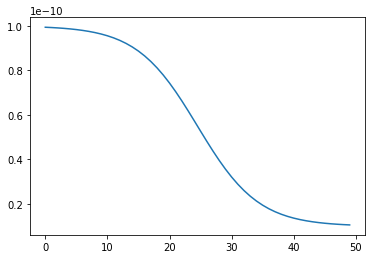

In [3]:
def get_init_means(start, end, jump):
    numlist = (list(range(-end, -start + 1, jump)) + list(range(start, end + 1, jump)))
    return [x/100.0 for x in numlist]
    
mean_mult = np.array(list(range(retraining_epochs))) - (retraining_epochs-1)/2
mean_mult = 5 * mean_mult/mean_mult.max()
mean_mult = (0.1 + 0.9 * (1.0/(1.0 + np.exp(mean_mult)))) * 1e-10
plt.plot(mean_mult)


In [4]:

mean = 20000
var = 2
zmean = 20000
zvar = 10
#means = get_init_means(8, 60, 9)
#print (means)
mixtures = 15
temp = 5
tau = 1e-8
def layer_exp(mean, var, zmean, zvar, mixtures, temp, tau, layer = 1, loss_type = 'MSEHA'):
    data_size = 'search'
    model_name = 'LeNet_300_100'

    beta = mean/var
    alpha = mean * beta
    ab = (alpha, beta)
    zbeta = zmean/zvar
    zalpha = zmean * zbeta
    zab = (zalpha, beta)
    
    #tau_scd = np.array(list(range(retraining_epochs))) - (retraining_epochs-1)/2
    #tau_scd = 5 * tau_scd/tau_scd.max()
    #tau_scd = (0.1 + 0.9 * (1.0/(1.0 + np.exp(tau_scd)))) * 1e-10

    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    full_model = torch.load(model_load_dir + model_file + ".m")

    (x_start, x_end) = (40000, 50000)
    if(layer == 1):
        layer_model = model_archs.LeNet_300_100FC1().cuda()
        input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
        output = (get_targets(model_file, 0, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
    if(layer == 2):
        layer_model = model_archs.LeNet_300_100FC2().cuda()
        input = (get_targets(model_file, 0, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
        input = nn.ReLU()(input)
        input = input/temp
        output = (get_targets(model_file, 0, ["fc2.out"])["fc2.out"][x_start:x_end]).cuda()
    #output = (get_targets(model_file, temp, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
    
    ###ReLU Check
    if (loss_type == 'MSEHA' or loss_type =='CESH'):
        output = nn.ReLU()(output)
    if (loss_type == 'CESH'):
        output = nn.Softmax(dim=1)(output/temp)

    test_data_full = Variable(test_data(fetch = "data")).cuda()
    test_labels_full = Variable(test_data(fetch = "labels")).cuda()
    val_data_full = Variable(search_validation_data(fetch = "data")).cuda()
    val_labels_full = Variable(search_validation_data(fetch = "labels")).cuda()

    dataset = torch.utils.data.TensorDataset(input.data, output.data)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    state_dict = copy.deepcopy(layer_model.state_dict())
    for layer in state_dict:
        state_dict[layer] = full_model.state_dict()[layer]
    layer_model.load_state_dict(state_dict)

    exp_name = "{}_a{}_za{}_r{}_t{}_m{}_kdT{}_{}".format(layer_model.name, ab[0], zab[0], retraining_epochs, tau, int(mixtures), int(temp), data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in layer_model.parameters()], 0.99, zero_ab = (zalpha, zbeta), ab = (alpha, beta), scaling = False)
    gmp.print_batch = False
    criterion = nn.MSELoss()
    opt = torch.optim.Adam([
        {'params': layer_model.parameters(), 'lr': 1e-4},
        {'params': [gmp.means], 'lr': 3e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])#log precisions and mixing proportions

    for epoch in range(50):
        #mean = mean_mult[epoch]
        #mean = 50000
        #beta = mean/var
        #alpha = mean * beta
        #gmp.ab = (alpha, beta)

        layer_model, loss = retrain_sws_epoch(layer_model, gmp, opt, criterion, loader, tau, temp, loss_type)

        if (trueAfterN(epoch, 25)):
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            show_sws_weights(model = layer_model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
            res = layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)
            
    res_test = layer_accuracy(layer_model, gmp, full_model, val_data_full, val_labels_full)
    res_val = layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)
    res = {}
    res['compress_test'] = res_test[0]
    res['compress_val'] = res_val[0]
    res['prune_test'] = res_test[2]
    res['prune_val'] = res_val[2]
    res['sparsity'] = res_val[3]
    return layer_model, gmp, res

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 10. Loss: -1.19


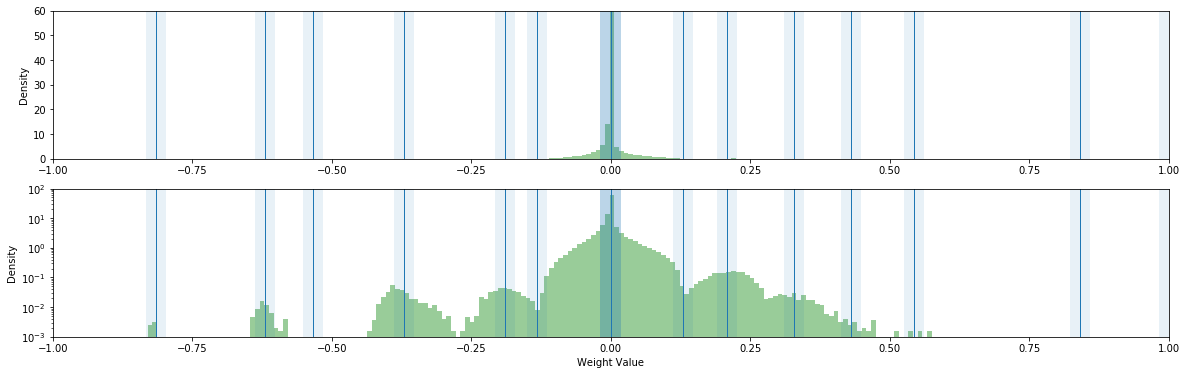

Original: 98.26% - Retrain: 94.84% - Prune: 84.53% - Quantize: 87.49% - Sparsity: 91.71%
Epoch: 20. Loss: -1.14


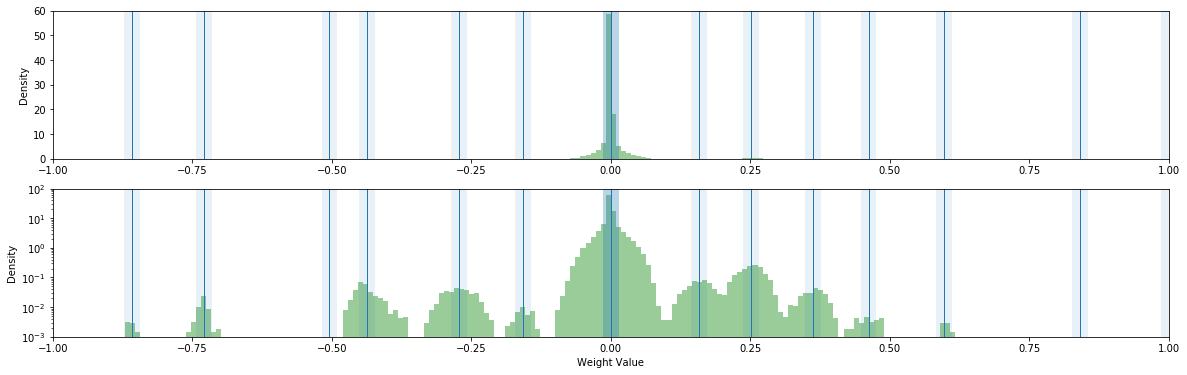

Original: 98.26% - Retrain: 93.21% - Prune: 64.43% - Quantize: 64.21% - Sparsity: 97.16%
Epoch: 30. Loss: -1.23


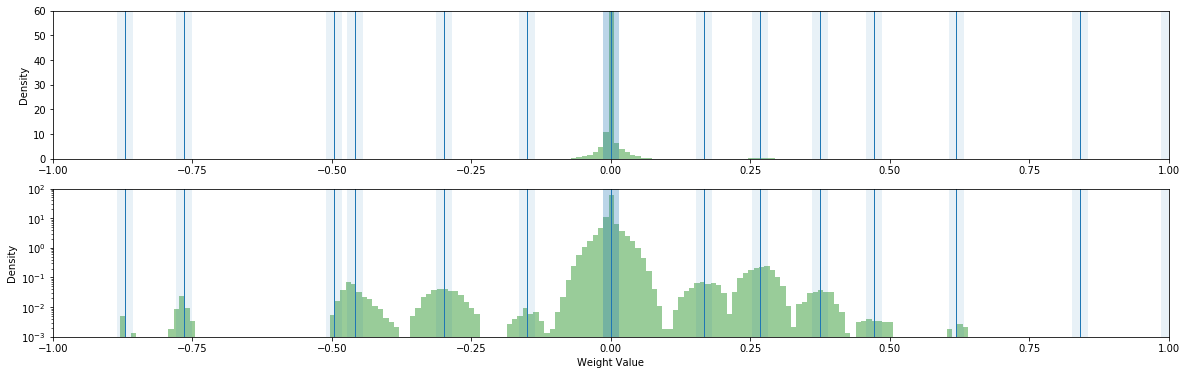

Original: 98.26% - Retrain: 93.19% - Prune: 64.59% - Quantize: 65.01% - Sparsity: 97.15%
Epoch: 40. Loss: -1.23


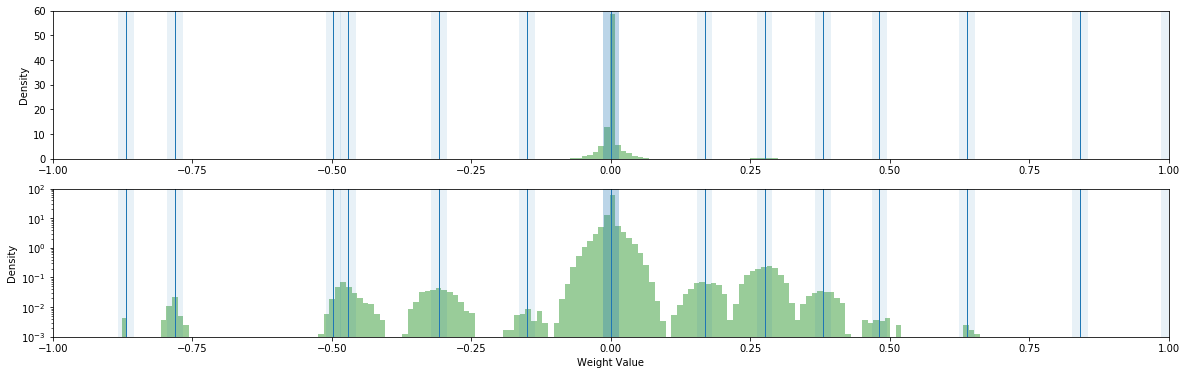

Original: 98.26% - Retrain: 93.84% - Prune: 64.04% - Quantize: 64.34% - Sparsity: 97.16%
Epoch: 50. Loss: -1.18


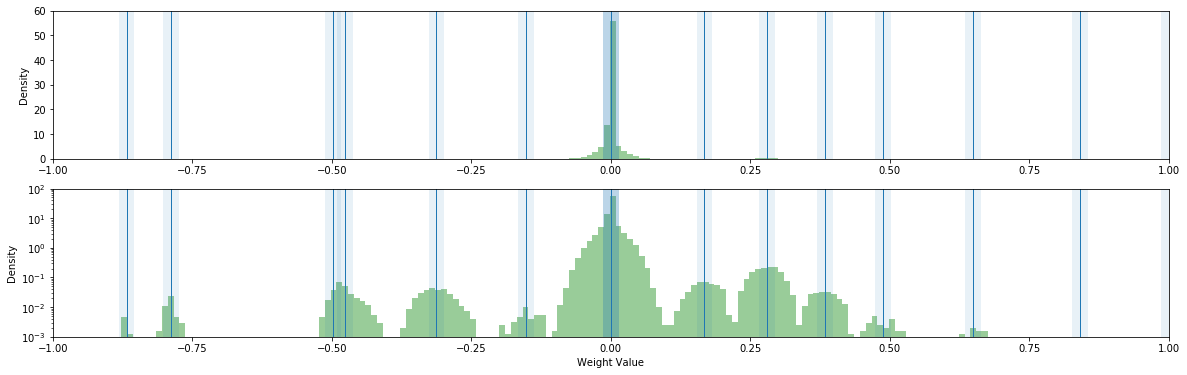

Original: 98.26% - Retrain: 93.21% - Prune: 64.08% - Quantize: 64.43% - Sparsity: 97.16%
Original: 98.26% - Retrain: 93.21% - Prune: 64.08% - Quantize: 64.43% - Sparsity: 97.16%
93.21|64.08_64.43|97.16


In [16]:
layer_model, gmp, res = layer_exp(5000, 2, 5000, 10, 15, 1, 1e-9, 1, 'CESH')
print (res)

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -0.13


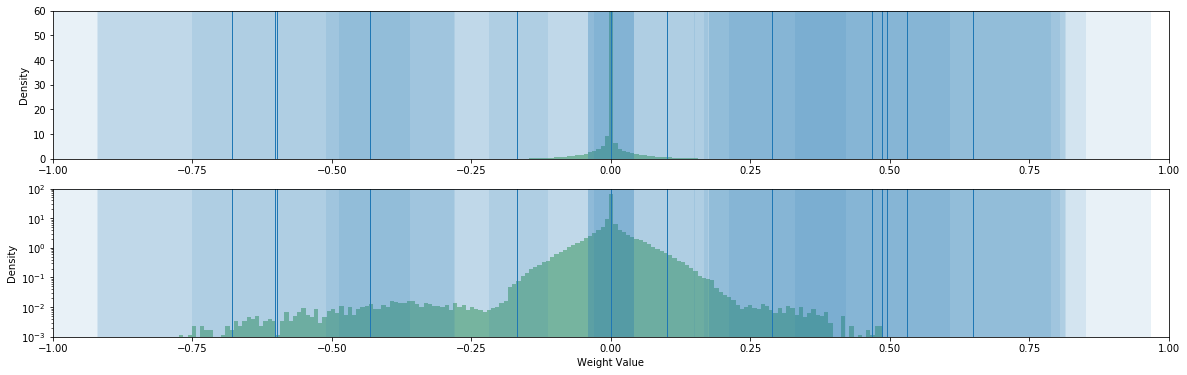

Original: 98.26% - Retrain: 98.10% - Prune: 95.25% - Quantize: 95.82% - Sparsity: 88.39%
Epoch: 50. Loss: -0.32


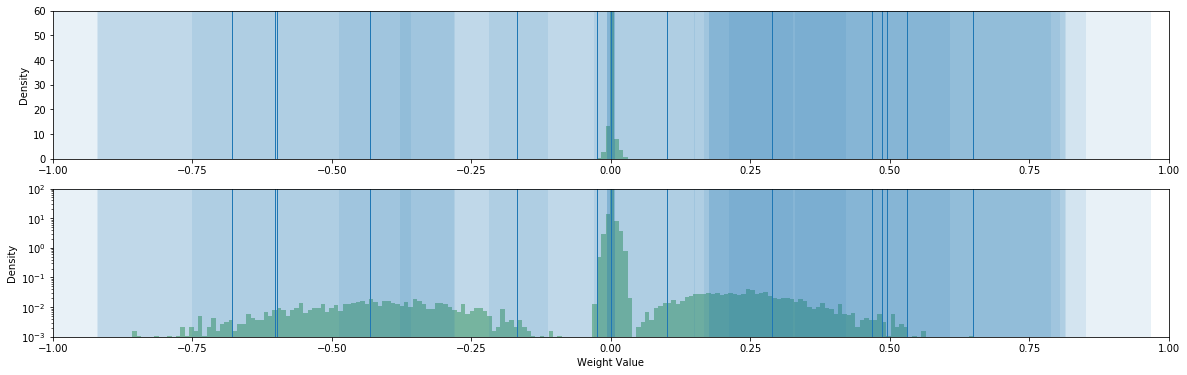

Original: 98.26% - Retrain: 95.41% - Prune: 85.72% - Quantize: 88.81% - Sparsity: 98.70%
Original: 98.15% - Retrain: 95.18% - Prune: 85.76% - Quantize: 89.01% - Sparsity: 98.70%
Original: 98.26% - Retrain: 95.41% - Prune: 85.72% - Quantize: 88.81% - Sparsity: 98.70%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -0.02


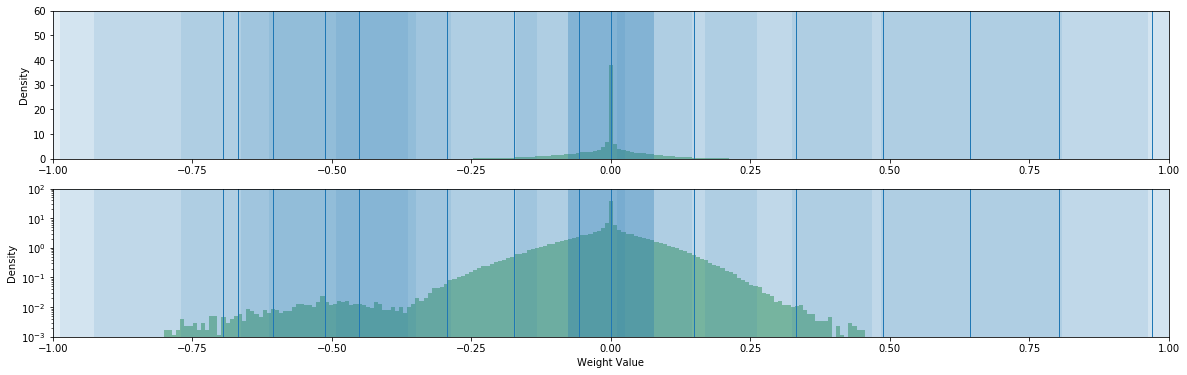

Original: 98.26% - Retrain: 98.30% - Prune: 97.45% - Quantize: 97.95% - Sparsity: 62.42%
Epoch: 50. Loss: -0.04


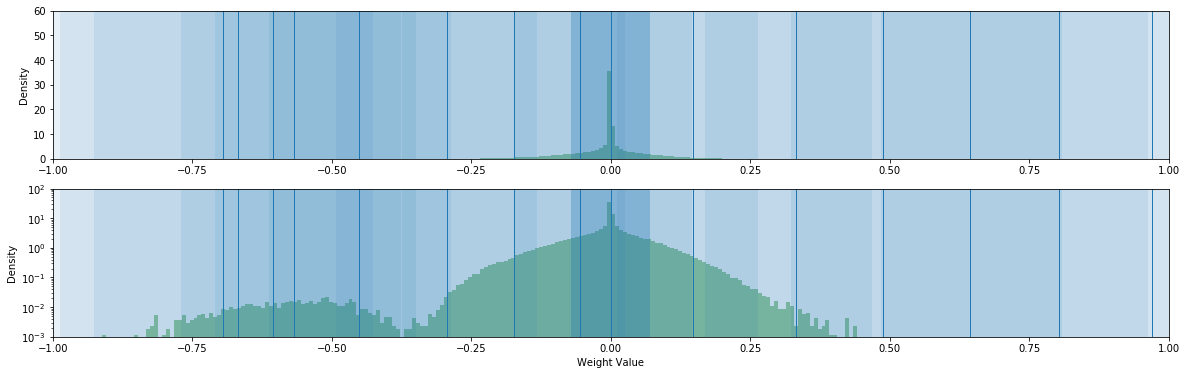

Original: 98.26% - Retrain: 98.30% - Prune: 97.42% - Quantize: 97.96% - Sparsity: 64.07%
Original: 98.15% - Retrain: 98.25% - Prune: 97.48% - Quantize: 98.11% - Sparsity: 64.07%
Original: 98.26% - Retrain: 98.30% - Prune: 97.42% - Quantize: 97.96% - Sparsity: 64.07%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.37


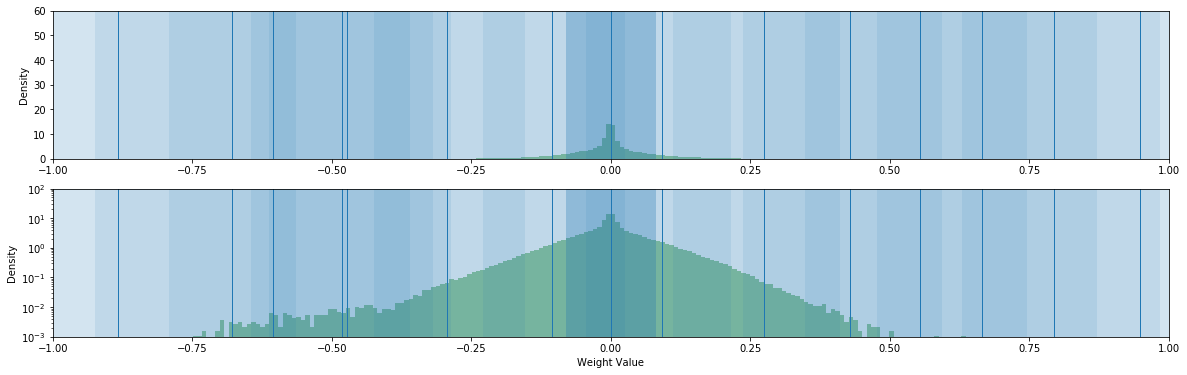

Original: 98.26% - Retrain: 98.20% - Prune: 98.10% - Quantize: 98.12% - Sparsity: 60.82%
Epoch: 50. Loss: 0.03


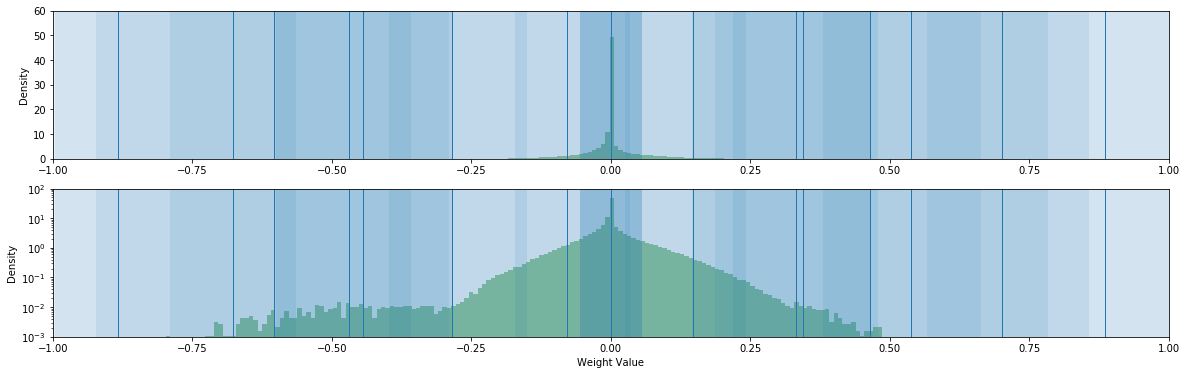

Original: 98.26% - Retrain: 98.02% - Prune: 97.90% - Quantize: 97.40% - Sparsity: 77.26%
Original: 98.15% - Retrain: 97.91% - Prune: 97.89% - Quantize: 97.57% - Sparsity: 77.26%
Original: 98.26% - Retrain: 98.02% - Prune: 97.90% - Quantize: 97.40% - Sparsity: 77.26%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -0.15


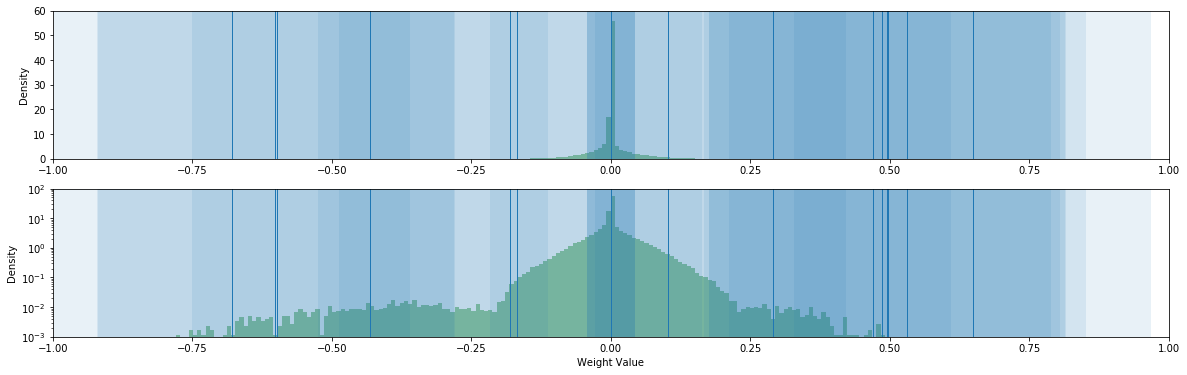

Original: 98.26% - Retrain: 98.10% - Prune: 95.26% - Quantize: 95.84% - Sparsity: 88.29%
Epoch: 50. Loss: -0.24


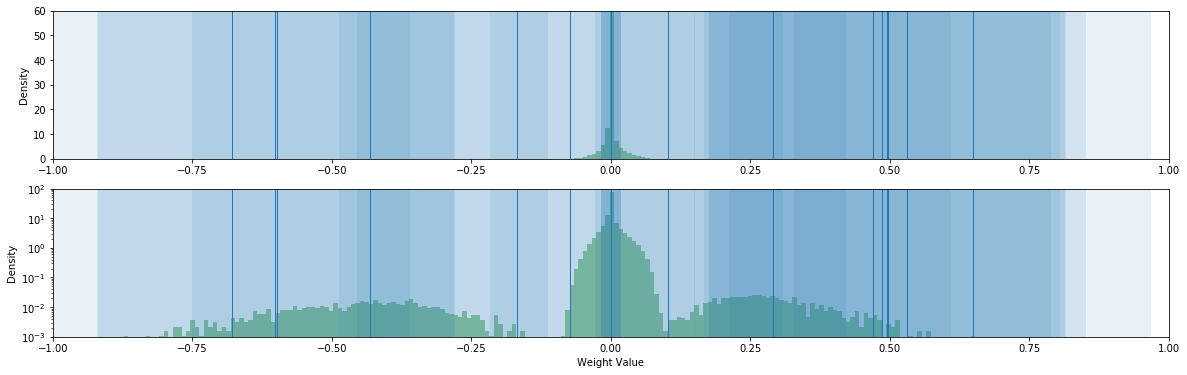

Original: 98.26% - Retrain: 96.98% - Prune: 93.21% - Quantize: 95.42% - Sparsity: 95.73%
Original: 98.15% - Retrain: 96.81% - Prune: 93.24% - Quantize: 95.60% - Sparsity: 95.73%
Original: 98.26% - Retrain: 96.98% - Prune: 93.21% - Quantize: 95.42% - Sparsity: 95.73%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -0.02


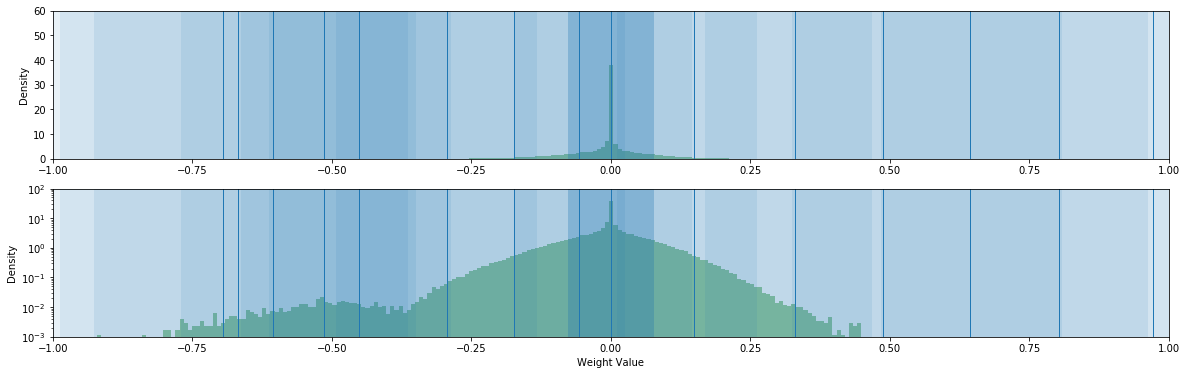

Original: 98.26% - Retrain: 98.30% - Prune: 97.55% - Quantize: 97.91% - Sparsity: 62.43%
Epoch: 50. Loss: -0.04


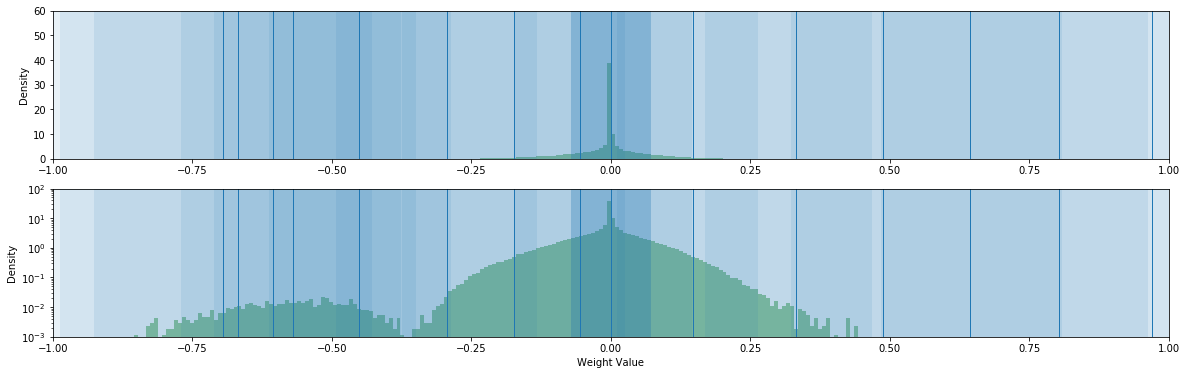

Original: 98.26% - Retrain: 98.31% - Prune: 97.43% - Quantize: 97.89% - Sparsity: 64.02%
Original: 98.15% - Retrain: 98.25% - Prune: 97.50% - Quantize: 98.12% - Sparsity: 64.02%
Original: 98.26% - Retrain: 98.31% - Prune: 97.43% - Quantize: 97.89% - Sparsity: 64.02%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.03


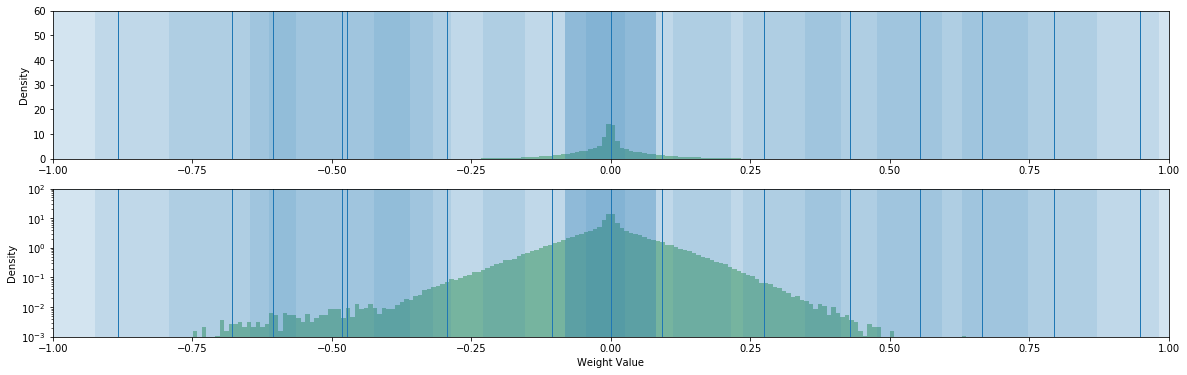

Original: 98.26% - Retrain: 98.17% - Prune: 98.12% - Quantize: 98.08% - Sparsity: 60.83%
Epoch: 50. Loss: 0.04


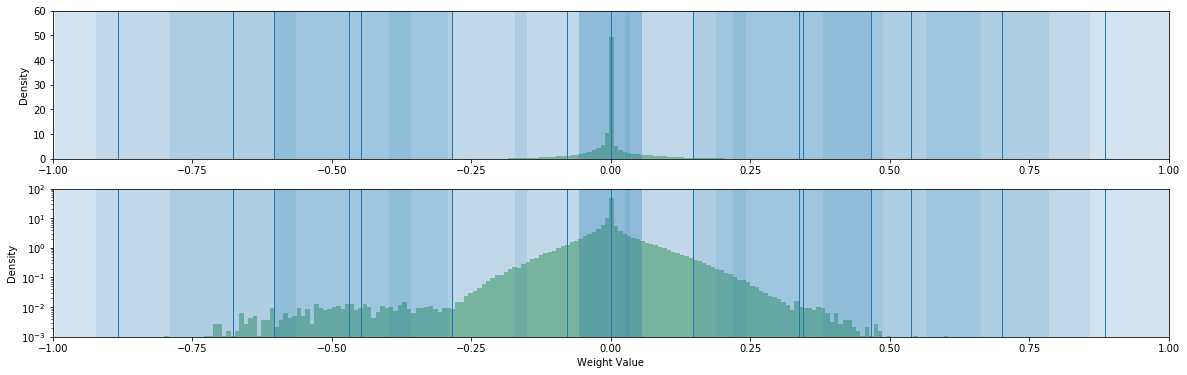

Original: 98.26% - Retrain: 98.01% - Prune: 97.89% - Quantize: 97.51% - Sparsity: 77.18%
Original: 98.15% - Retrain: 97.92% - Prune: 97.89% - Quantize: 97.59% - Sparsity: 77.18%
Original: 98.26% - Retrain: 98.01% - Prune: 97.89% - Quantize: 97.51% - Sparsity: 77.18%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -0.77


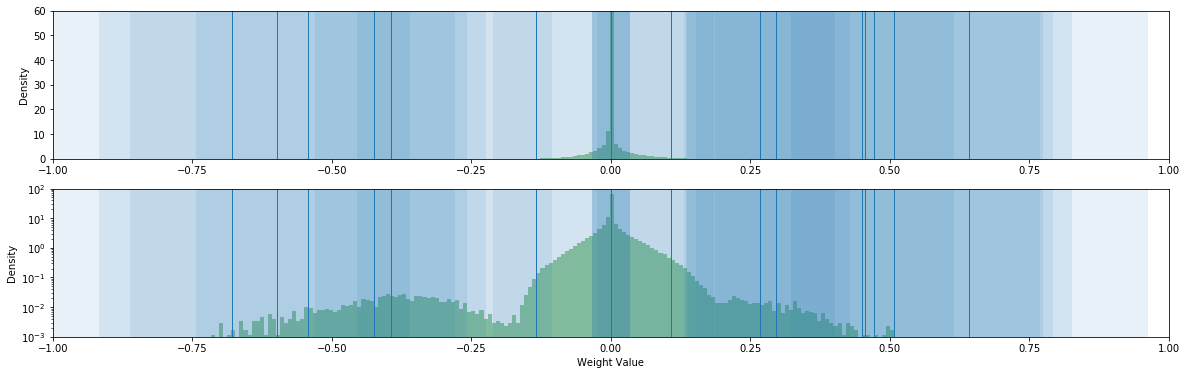

Original: 98.26% - Retrain: 97.93% - Prune: 96.56% - Quantize: 96.94% - Sparsity: 89.97%
Epoch: 50. Loss: -0.82


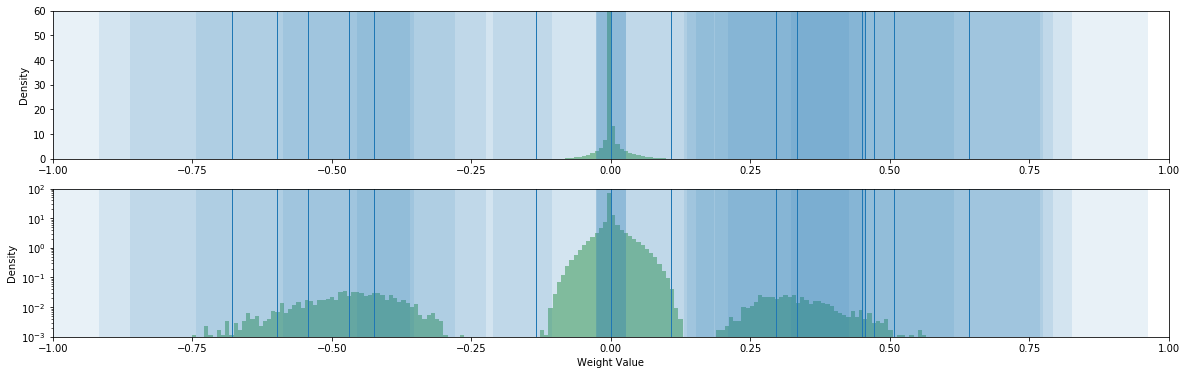

Original: 98.26% - Retrain: 97.37% - Prune: 93.62% - Quantize: 94.86% - Sparsity: 95.60%
Original: 98.15% - Retrain: 97.29% - Prune: 93.34% - Quantize: 94.70% - Sparsity: 95.60%
Original: 98.26% - Retrain: 97.37% - Prune: 93.62% - Quantize: 94.86% - Sparsity: 95.60%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -0.56


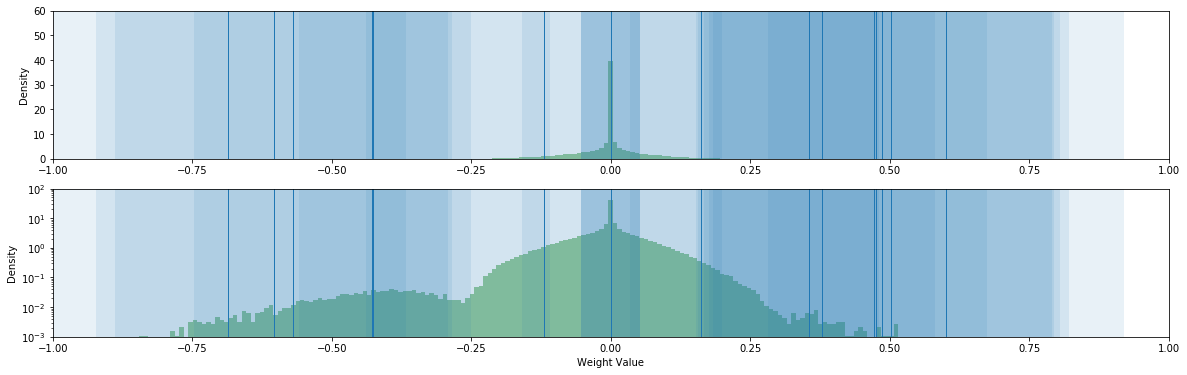

Original: 98.26% - Retrain: 98.29% - Prune: 97.86% - Quantize: 98.06% - Sparsity: 75.71%
Epoch: 50. Loss: -0.58


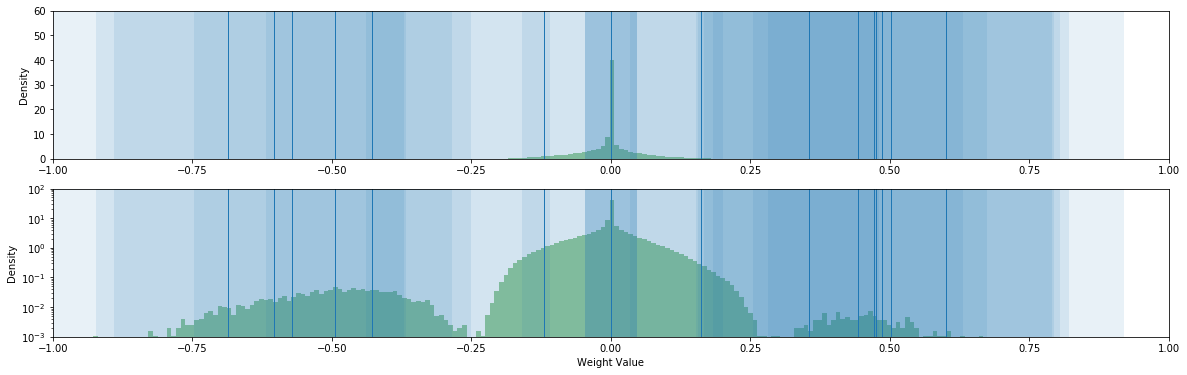

Original: 98.26% - Retrain: 98.29% - Prune: 97.69% - Quantize: 98.08% - Sparsity: 78.50%
Original: 98.15% - Retrain: 98.20% - Prune: 97.68% - Quantize: 98.13% - Sparsity: 78.50%
Original: 98.26% - Retrain: 98.29% - Prune: 97.69% - Quantize: 98.08% - Sparsity: 78.50%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.10


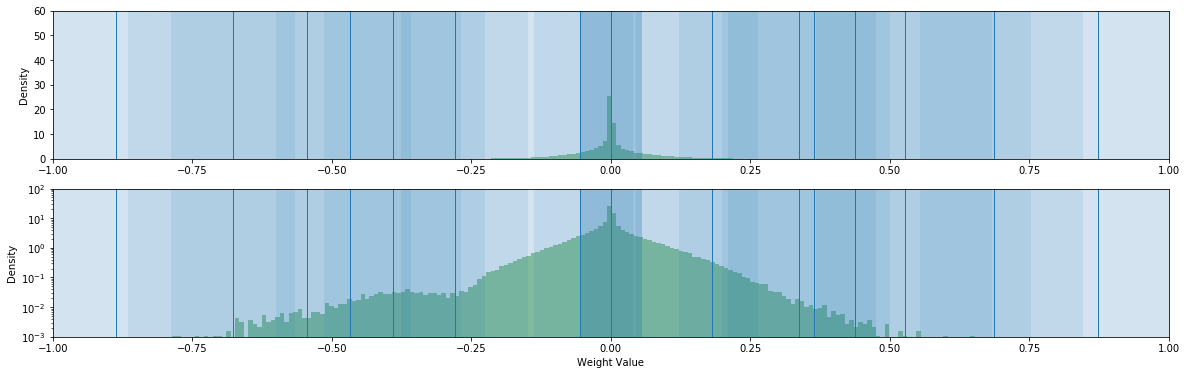

Original: 98.26% - Retrain: 98.12% - Prune: 96.69% - Quantize: 97.52% - Sparsity: 67.21%
Epoch: 50. Loss: 0.03


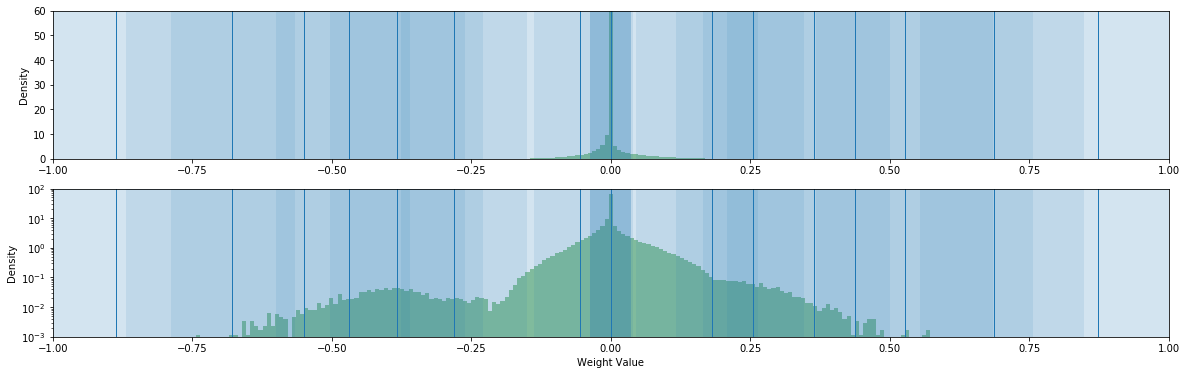

Original: 98.26% - Retrain: 97.83% - Prune: 95.85% - Quantize: 96.87% - Sparsity: 81.24%
Original: 98.15% - Retrain: 97.80% - Prune: 96.32% - Quantize: 96.99% - Sparsity: 81.24%
Original: 98.26% - Retrain: 97.83% - Prune: 95.85% - Quantize: 96.87% - Sparsity: 81.24%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -79.42


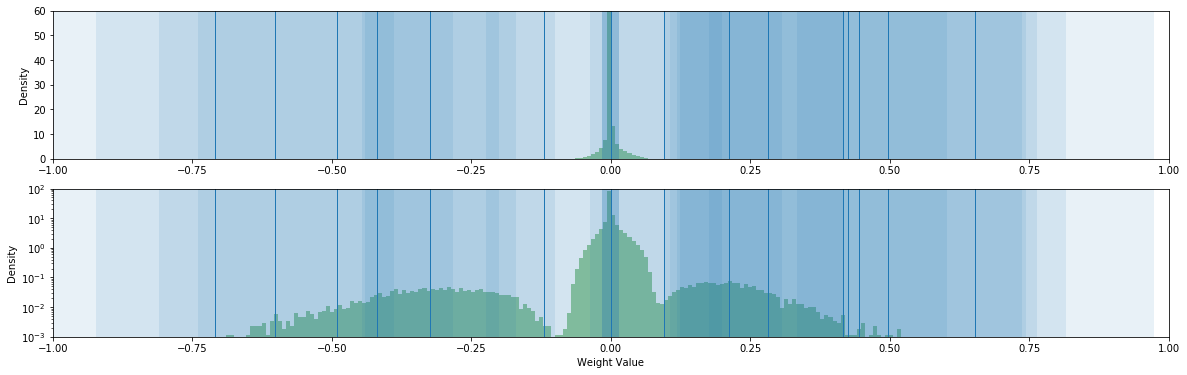

Original: 98.26% - Retrain: 97.35% - Prune: 92.29% - Quantize: 93.39% - Sparsity: 96.15%
Epoch: 50. Loss: -82.48


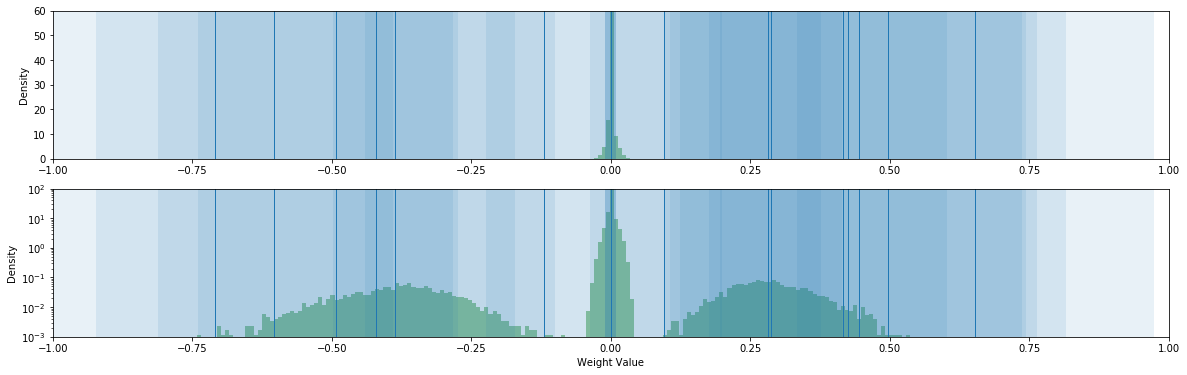

Original: 98.26% - Retrain: 96.67% - Prune: 92.56% - Quantize: 92.48% - Sparsity: 97.74%
Original: 98.15% - Retrain: 96.67% - Prune: 92.60% - Quantize: 92.81% - Sparsity: 97.74%
Original: 98.26% - Retrain: 96.67% - Prune: 92.56% - Quantize: 92.48% - Sparsity: 97.74%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -78.94


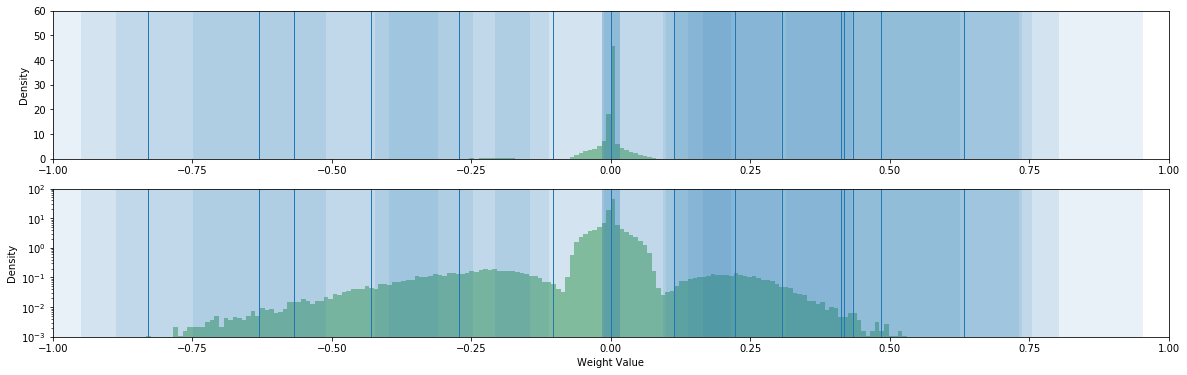

Original: 98.26% - Retrain: 98.19% - Prune: 97.19% - Quantize: 97.46% - Sparsity: 88.39%
Epoch: 50. Loss: -82.20


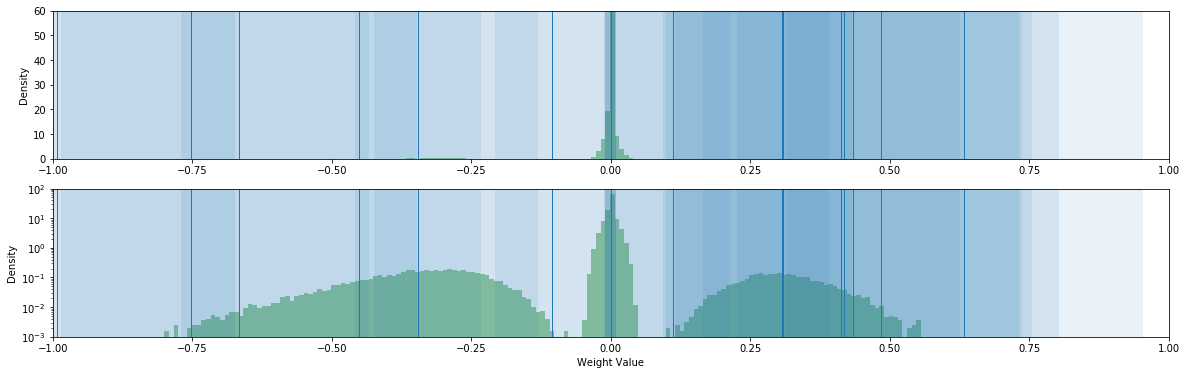

Original: 98.26% - Retrain: 98.05% - Prune: 97.48% - Quantize: 97.49% - Sparsity: 93.18%
Original: 98.15% - Retrain: 98.07% - Prune: 97.57% - Quantize: 97.62% - Sparsity: 93.18%
Original: 98.26% - Retrain: 98.05% - Prune: 97.48% - Quantize: 97.49% - Sparsity: 93.18%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.02


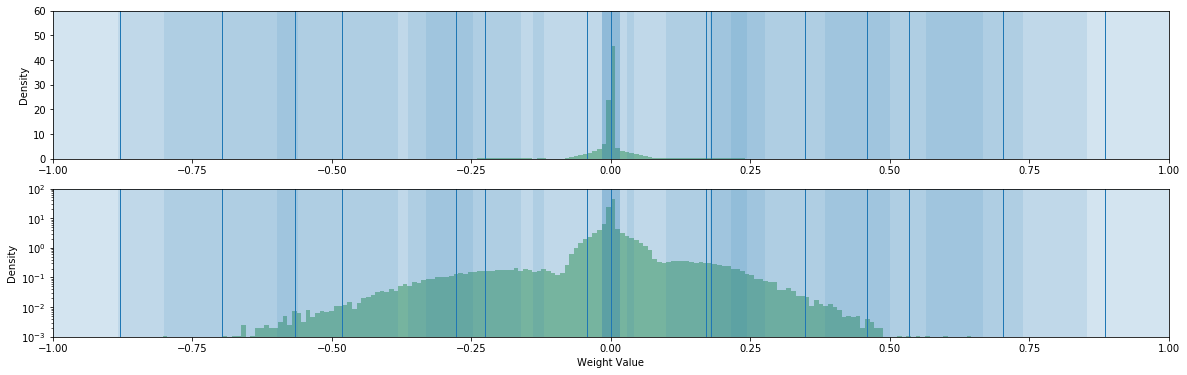

Original: 98.26% - Retrain: 97.99% - Prune: 96.98% - Quantize: 97.22% - Sparsity: 81.19%
Epoch: 50. Loss: 0.11


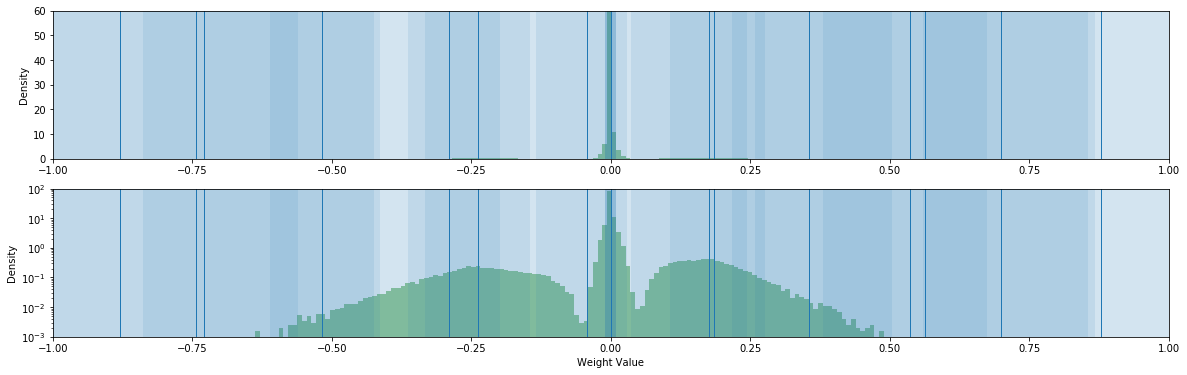

Original: 98.26% - Retrain: 97.81% - Prune: 97.57% - Quantize: 97.03% - Sparsity: 89.39%
Original: 98.15% - Retrain: 97.80% - Prune: 97.67% - Quantize: 97.33% - Sparsity: 89.39%
Original: 98.26% - Retrain: 97.81% - Prune: 97.57% - Quantize: 97.03% - Sparsity: 89.39%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -8598.72


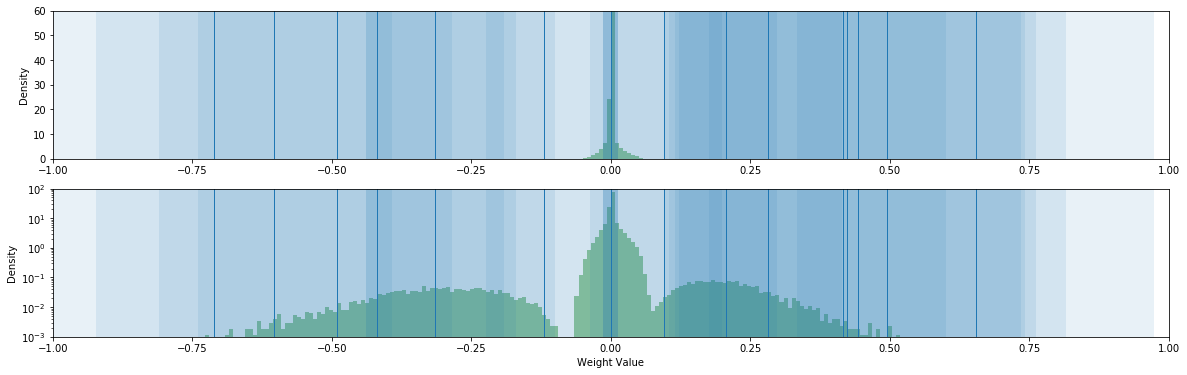

Original: 98.26% - Retrain: 97.17% - Prune: 91.44% - Quantize: 92.00% - Sparsity: 96.85%
Epoch: 50. Loss: -10513.51


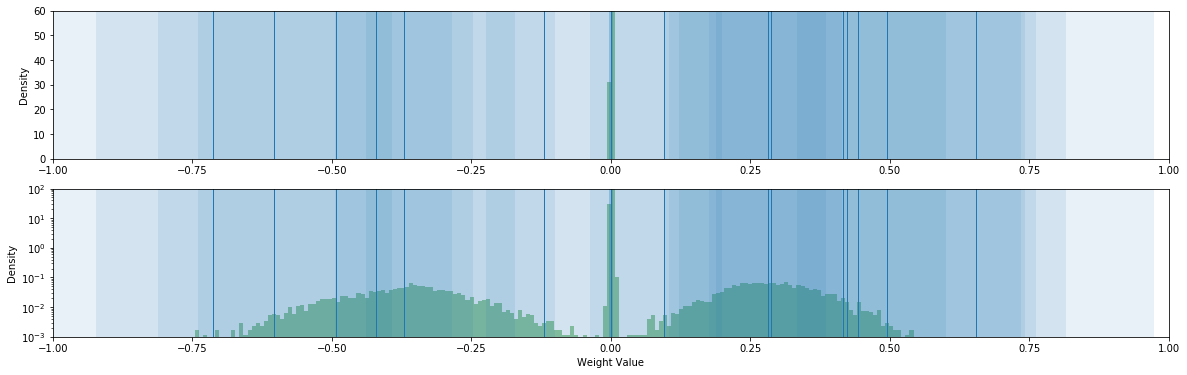

Original: 98.26% - Retrain: 95.99% - Prune: 95.58% - Quantize: 95.52% - Sparsity: 97.54%
Original: 98.15% - Retrain: 95.76% - Prune: 95.52% - Quantize: 95.38% - Sparsity: 97.54%
Original: 98.26% - Retrain: 95.99% - Prune: 95.58% - Quantize: 95.52% - Sparsity: 97.54%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -8598.27


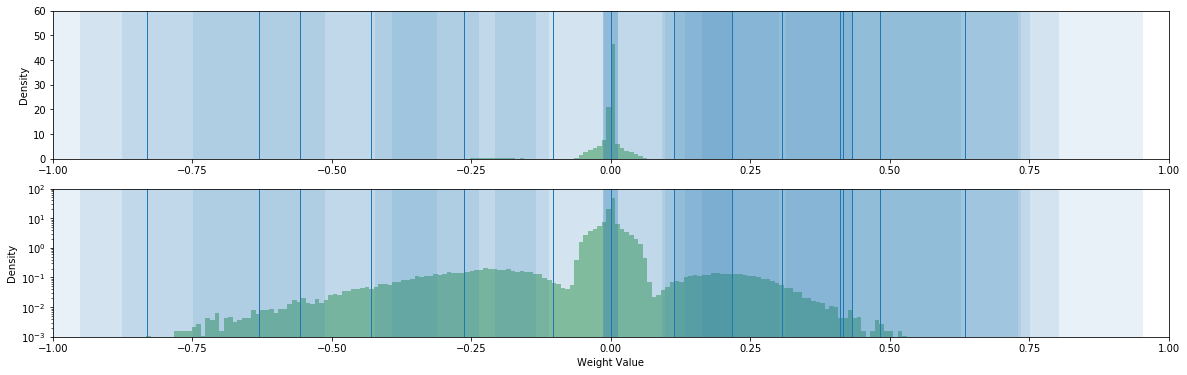

Original: 98.26% - Retrain: 98.08% - Prune: 96.99% - Quantize: 97.03% - Sparsity: 91.04%
Epoch: 50. Loss: -10513.21


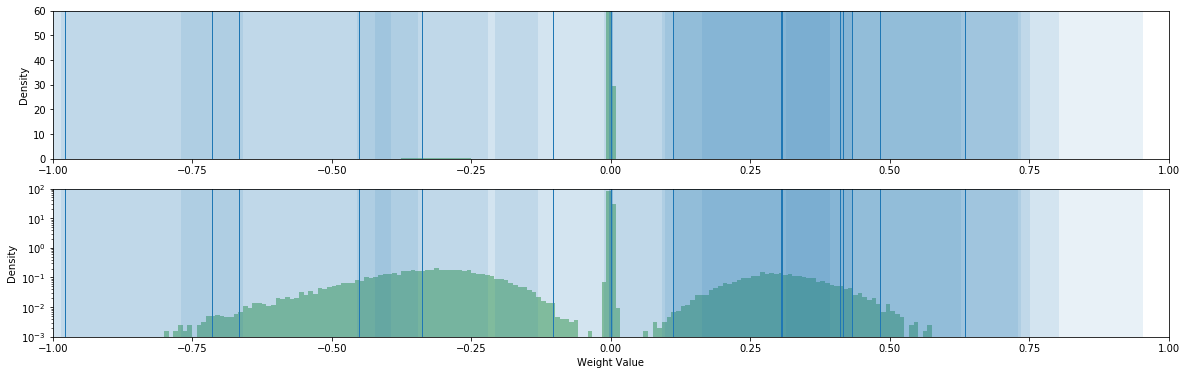

Original: 98.26% - Retrain: 97.75% - Prune: 97.73% - Quantize: 97.68% - Sparsity: 92.55%
Original: 98.15% - Retrain: 98.04% - Prune: 97.97% - Quantize: 97.89% - Sparsity: 92.55%
Original: 98.26% - Retrain: 97.75% - Prune: 97.73% - Quantize: 97.68% - Sparsity: 92.55%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: -8.57


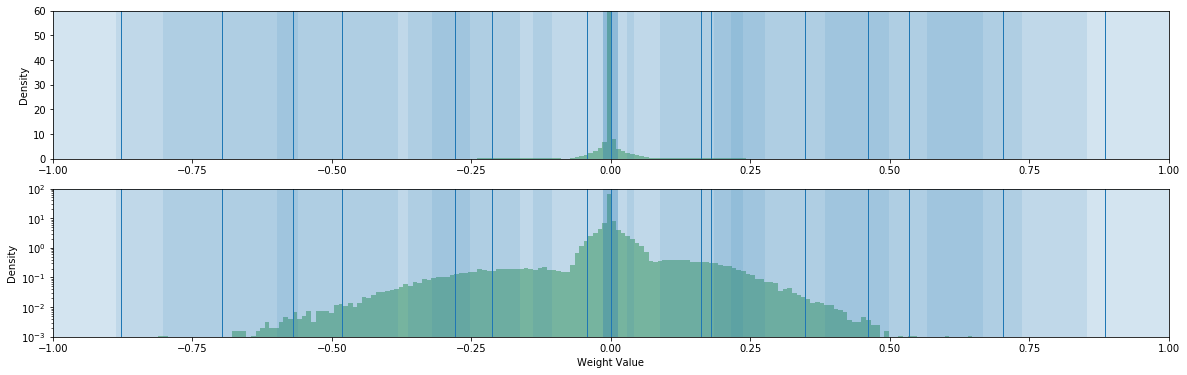

Original: 98.26% - Retrain: 97.98% - Prune: 97.51% - Quantize: 97.54% - Sparsity: 82.04%
Epoch: 50. Loss: -10.41


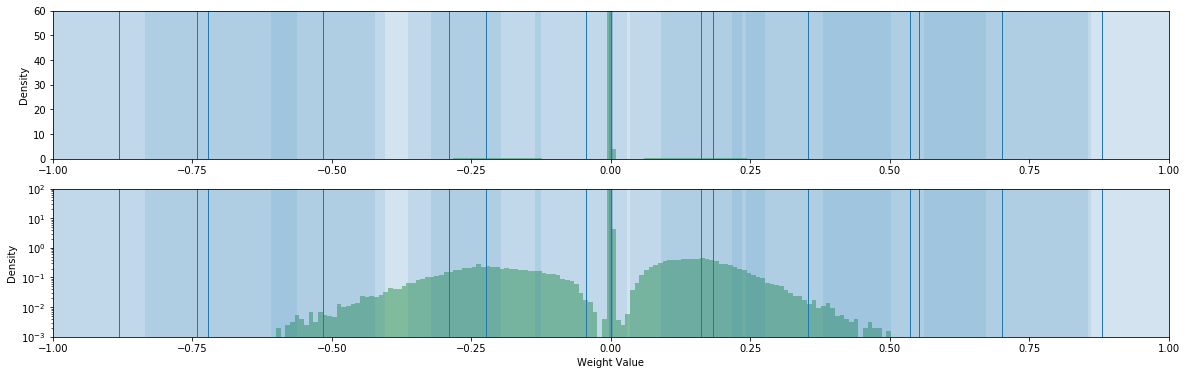

Original: 98.26% - Retrain: 97.61% - Prune: 97.69% - Quantize: 97.22% - Sparsity: 88.42%
Original: 98.15% - Retrain: 97.67% - Prune: 97.76% - Quantize: 97.30% - Sparsity: 88.42%
Original: 98.26% - Retrain: 97.61% - Prune: 97.69% - Quantize: 97.22% - Sparsity: 88.42%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -0.41


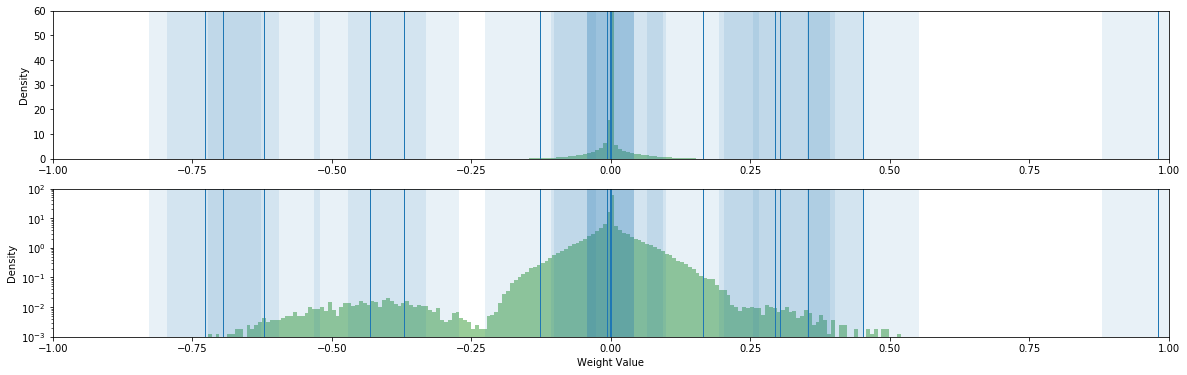

Original: 98.26% - Retrain: 98.02% - Prune: 94.29% - Quantize: 97.28% - Sparsity: 81.74%
Epoch: 50. Loss: -0.47


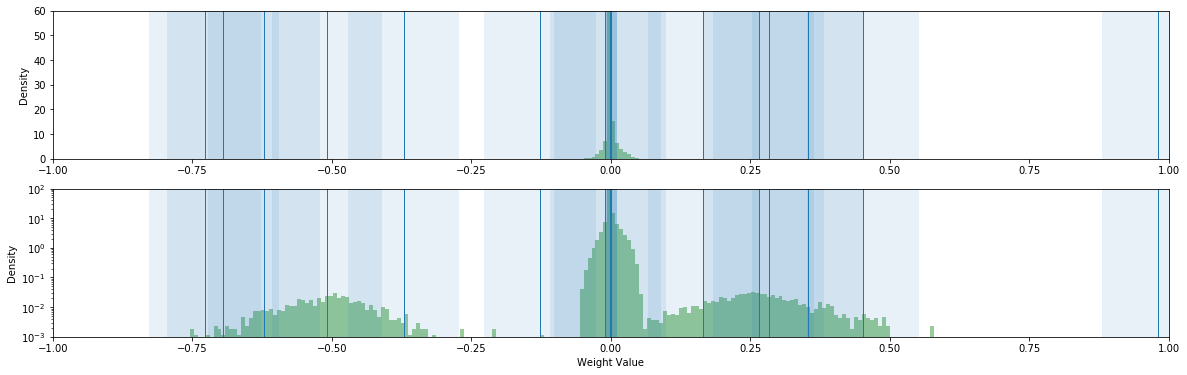

Original: 98.26% - Retrain: 95.82% - Prune: 76.06% - Quantize: 64.20% - Sparsity: 97.56%
Original: 98.15% - Retrain: 95.66% - Prune: 76.13% - Quantize: 64.31% - Sparsity: 97.56%
Original: 98.26% - Retrain: 95.82% - Prune: 76.06% - Quantize: 64.20% - Sparsity: 97.56%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -0.28


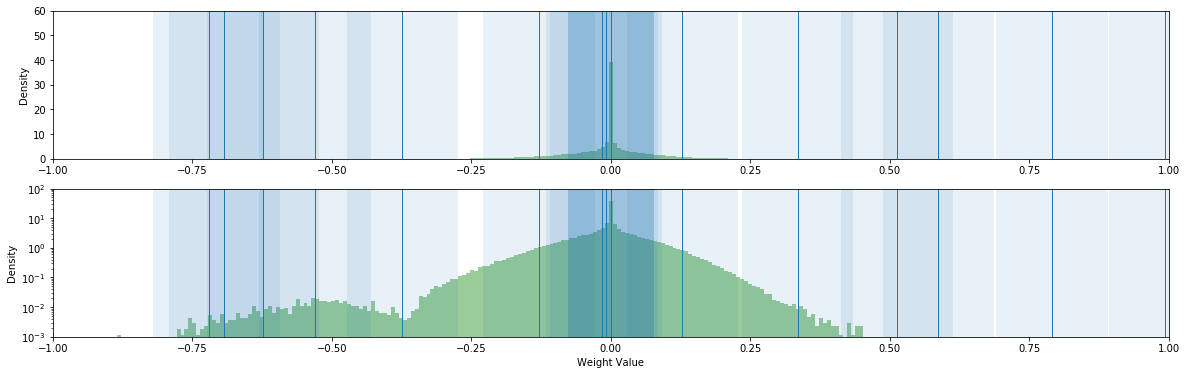

Original: 98.26% - Retrain: 98.29% - Prune: 97.90% - Quantize: 98.11% - Sparsity: 59.31%
Epoch: 50. Loss: -0.28


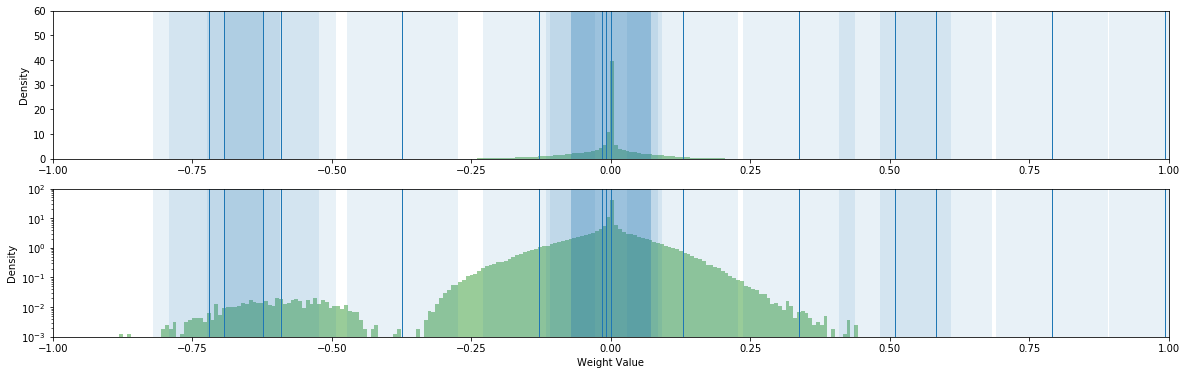

Original: 98.26% - Retrain: 98.31% - Prune: 97.90% - Quantize: 98.18% - Sparsity: 61.24%
Original: 98.15% - Retrain: 98.26% - Prune: 97.92% - Quantize: 98.09% - Sparsity: 61.24%
Original: 98.26% - Retrain: 98.31% - Prune: 97.90% - Quantize: 98.18% - Sparsity: 61.24%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: 0.35


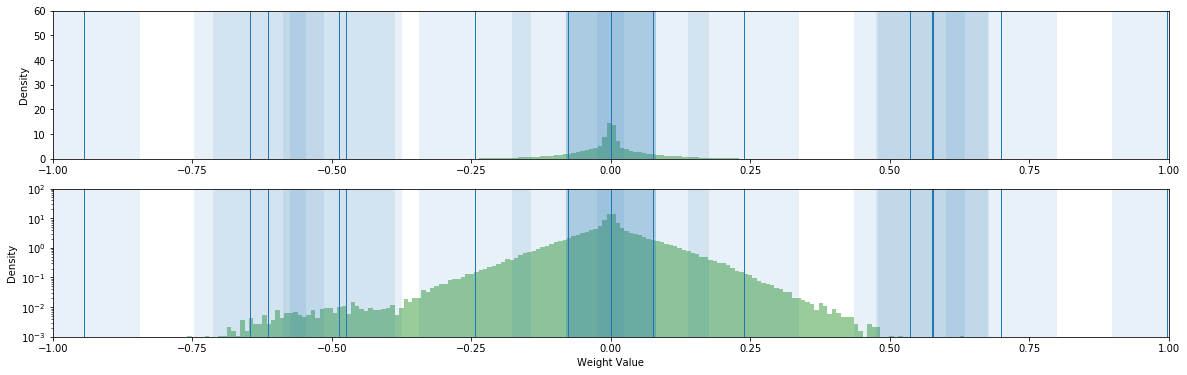

Original: 98.26% - Retrain: 98.18% - Prune: 98.13% - Quantize: 98.09% - Sparsity: 53.72%
Epoch: 50. Loss: 0.16


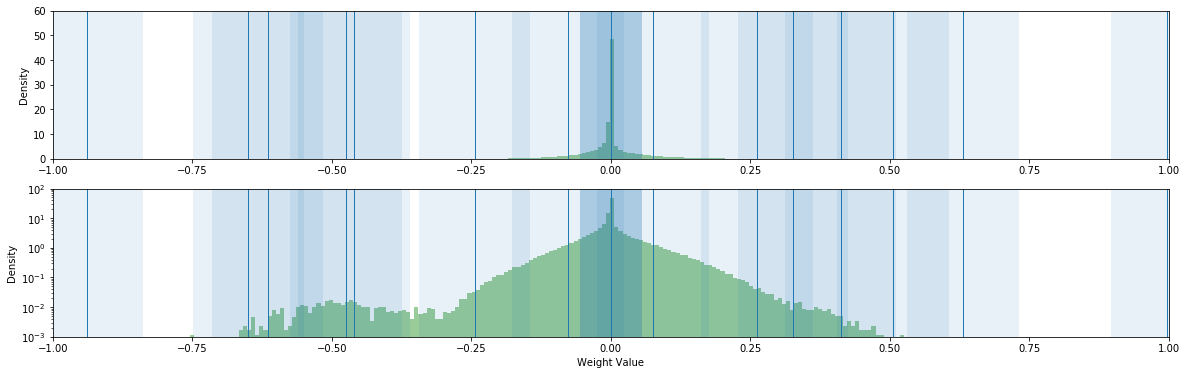

Original: 98.26% - Retrain: 97.96% - Prune: 98.02% - Quantize: 97.88% - Sparsity: 70.84%
Original: 98.15% - Retrain: 97.90% - Prune: 97.89% - Quantize: 97.84% - Sparsity: 70.84%
Original: 98.26% - Retrain: 97.96% - Prune: 98.02% - Quantize: 97.88% - Sparsity: 70.84%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -0.41


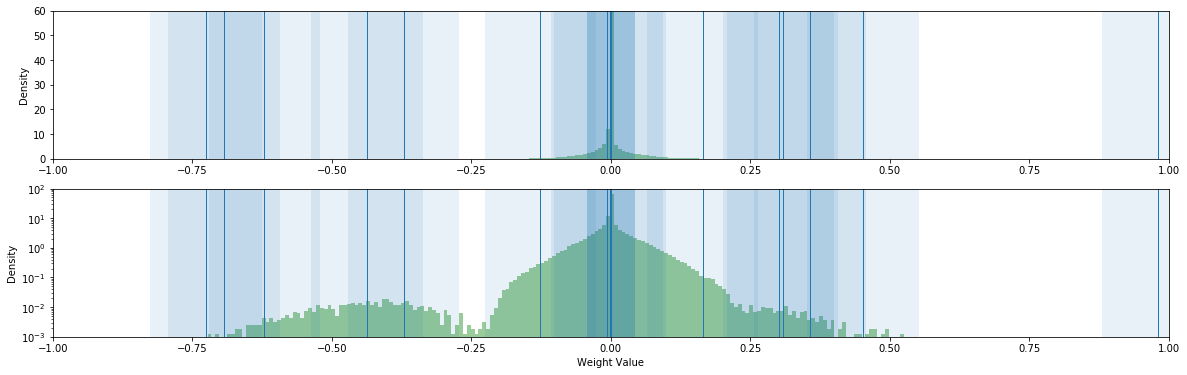

Original: 98.26% - Retrain: 98.06% - Prune: 94.70% - Quantize: 97.31% - Sparsity: 81.40%
Epoch: 50. Loss: -0.51


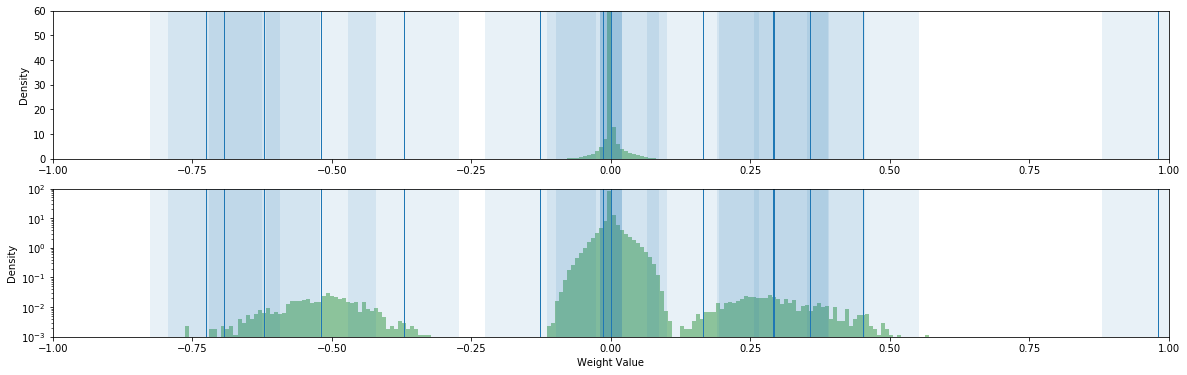

Original: 98.26% - Retrain: 96.85% - Prune: 96.61% - Quantize: 64.56% - Sparsity: 86.34%
Original: 98.15% - Retrain: 96.88% - Prune: 96.53% - Quantize: 64.76% - Sparsity: 86.34%
Original: 98.26% - Retrain: 96.85% - Prune: 96.61% - Quantize: 64.56% - Sparsity: 86.34%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -0.29


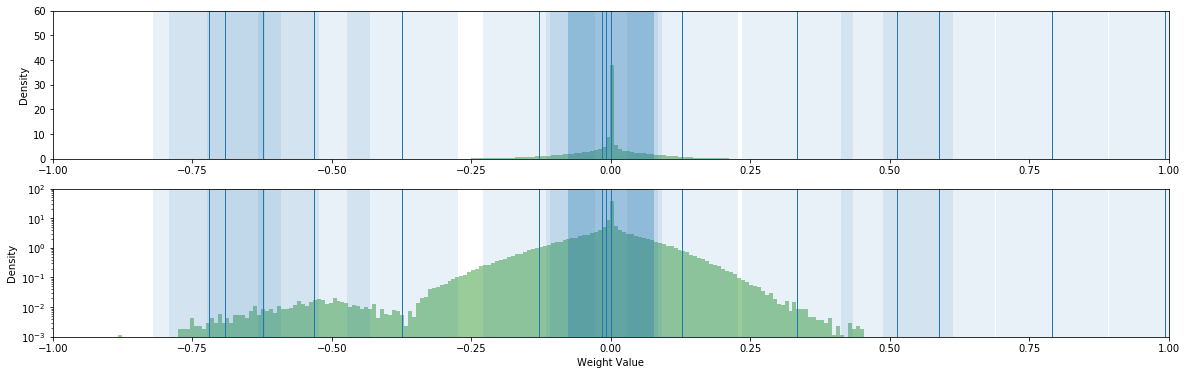

Original: 98.26% - Retrain: 98.29% - Prune: 97.89% - Quantize: 98.13% - Sparsity: 59.26%
Epoch: 50. Loss: -0.30


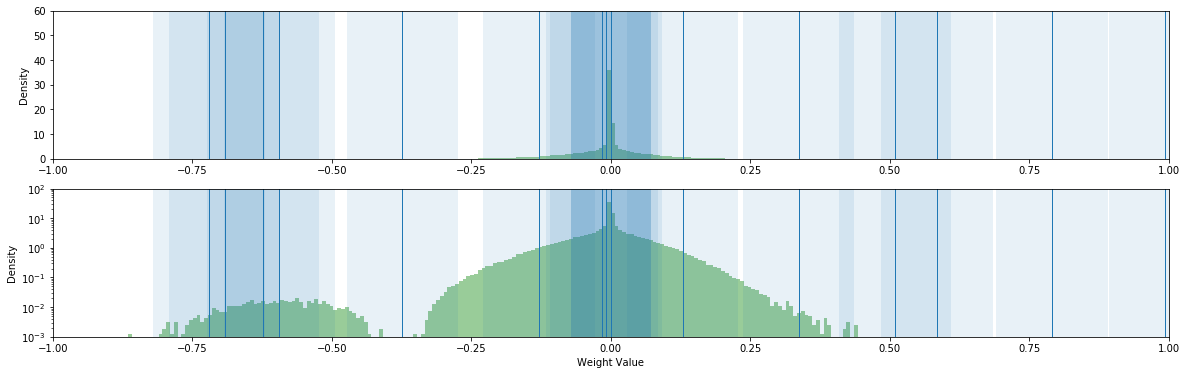

Original: 98.26% - Retrain: 98.32% - Prune: 97.87% - Quantize: 98.11% - Sparsity: 61.19%
Original: 98.15% - Retrain: 98.25% - Prune: 97.91% - Quantize: 98.08% - Sparsity: 61.19%
Original: 98.26% - Retrain: 98.32% - Prune: 97.87% - Quantize: 98.11% - Sparsity: 61.19%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: 0.01


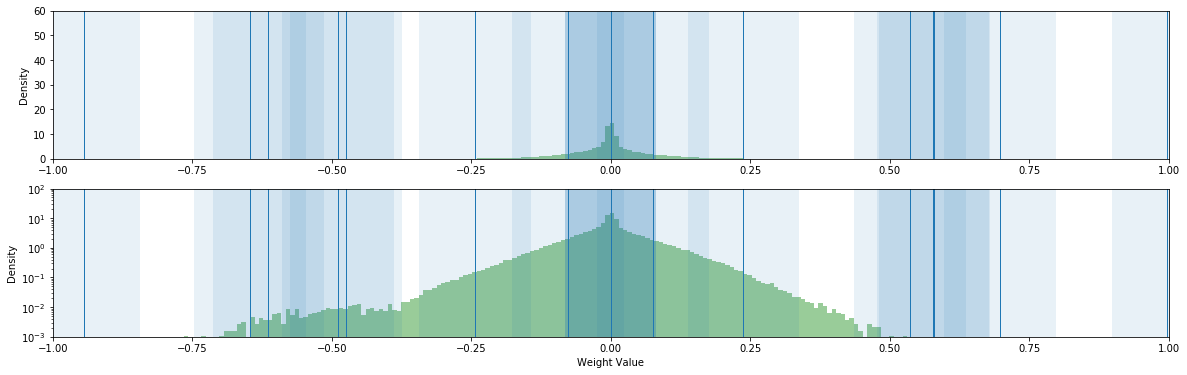

Original: 98.26% - Retrain: 98.19% - Prune: 98.11% - Quantize: 98.07% - Sparsity: 53.68%
Epoch: 50. Loss: 0.01


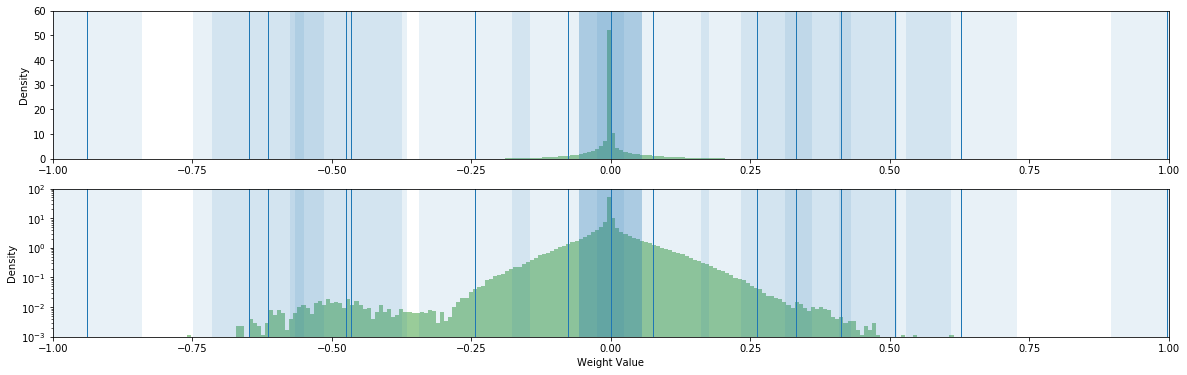

Original: 98.26% - Retrain: 98.00% - Prune: 98.04% - Quantize: 97.88% - Sparsity: 70.70%
Original: 98.15% - Retrain: 97.92% - Prune: 97.88% - Quantize: 97.89% - Sparsity: 70.70%
Original: 98.26% - Retrain: 98.00% - Prune: 98.04% - Quantize: 97.88% - Sparsity: 70.70%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -1.03


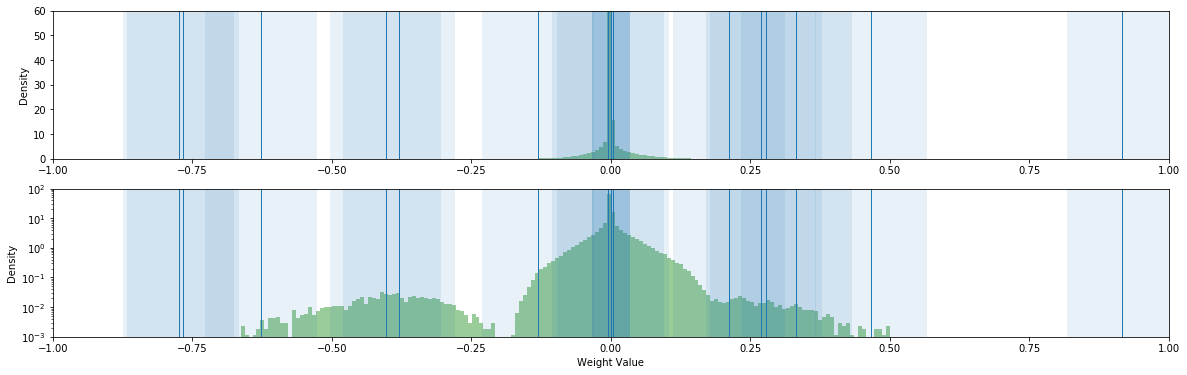

Original: 98.26% - Retrain: 97.90% - Prune: 97.87% - Quantize: 91.44% - Sparsity: 74.74%
Epoch: 50. Loss: -1.05


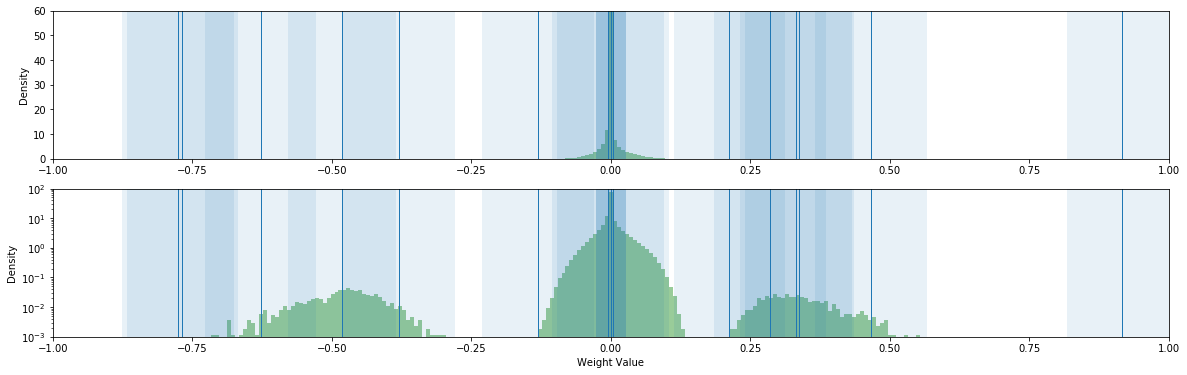

Original: 98.26% - Retrain: 97.36% - Prune: 97.24% - Quantize: 68.12% - Sparsity: 82.94%
Original: 98.15% - Retrain: 97.27% - Prune: 97.15% - Quantize: 68.42% - Sparsity: 82.94%
Original: 98.26% - Retrain: 97.36% - Prune: 97.24% - Quantize: 68.12% - Sparsity: 82.94%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -0.82


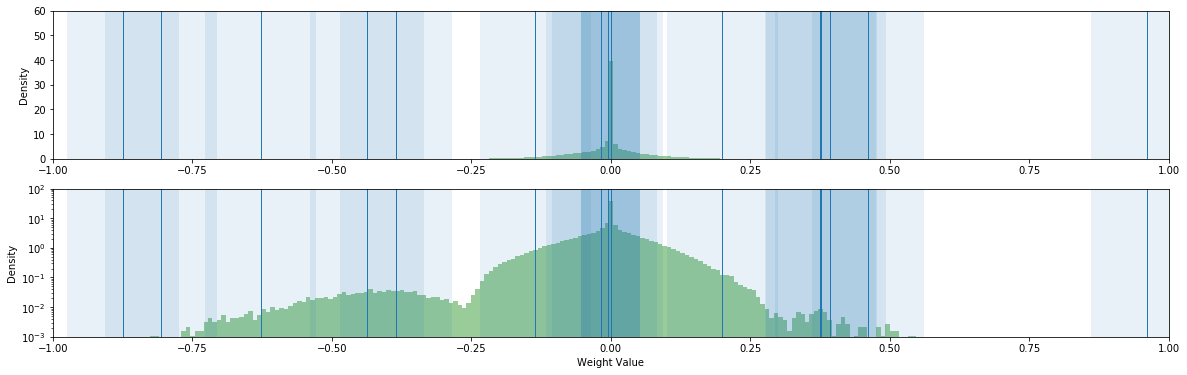

Original: 98.26% - Retrain: 98.30% - Prune: 93.43% - Quantize: 98.02% - Sparsity: 68.19%
Epoch: 50. Loss: -0.85


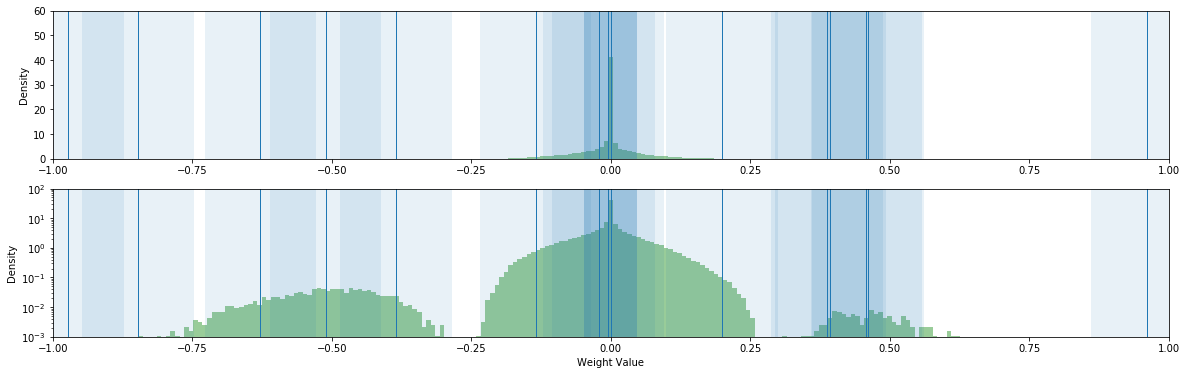

Original: 98.26% - Retrain: 98.28% - Prune: 92.33% - Quantize: 97.70% - Sparsity: 70.39%
Original: 98.15% - Retrain: 98.18% - Prune: 93.37% - Quantize: 97.77% - Sparsity: 70.39%
Original: 98.26% - Retrain: 98.28% - Prune: 92.33% - Quantize: 97.70% - Sparsity: 70.39%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: 0.07


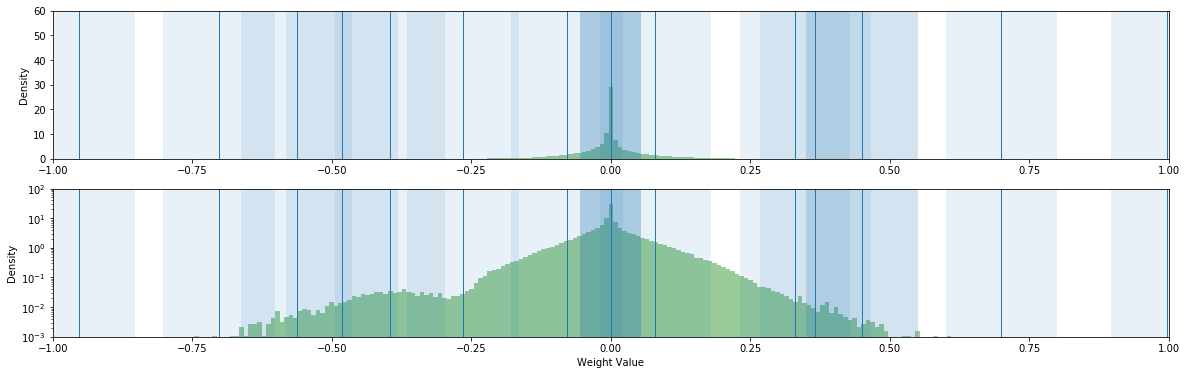

Original: 98.26% - Retrain: 98.15% - Prune: 98.17% - Quantize: 97.90% - Sparsity: 61.59%
Epoch: 50. Loss: 0.24


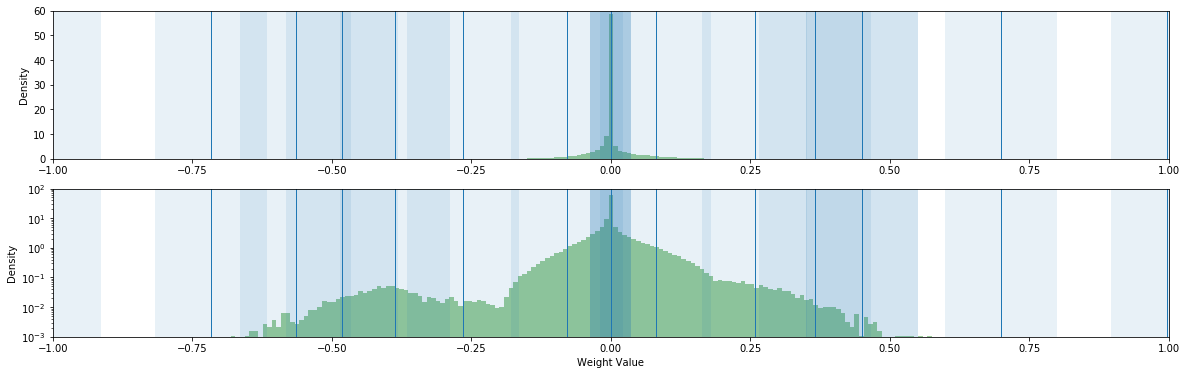

Original: 98.26% - Retrain: 97.83% - Prune: 97.72% - Quantize: 97.58% - Sparsity: 77.44%
Original: 98.15% - Retrain: 97.77% - Prune: 97.76% - Quantize: 97.52% - Sparsity: 77.44%
Original: 98.26% - Retrain: 97.83% - Prune: 97.72% - Quantize: 97.58% - Sparsity: 77.44%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -79.70


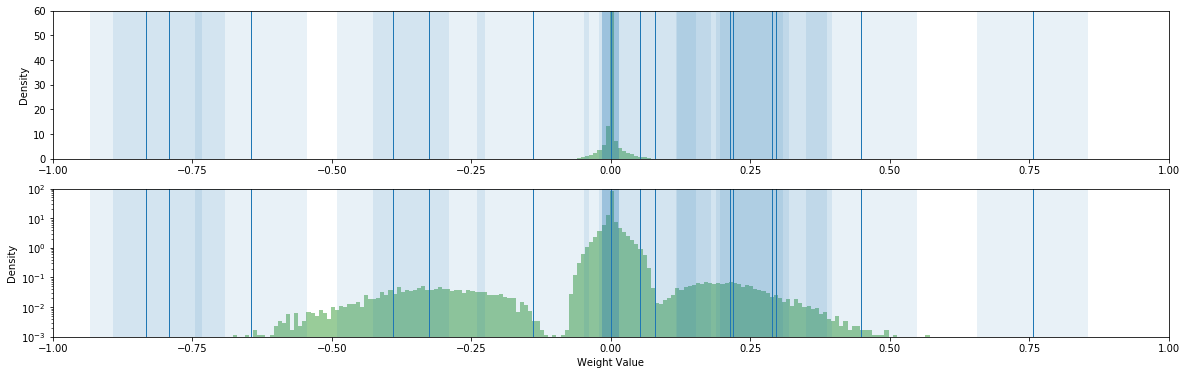

Original: 98.26% - Retrain: 97.32% - Prune: 91.91% - Quantize: 90.67% - Sparsity: 91.93%
Epoch: 50. Loss: -82.70


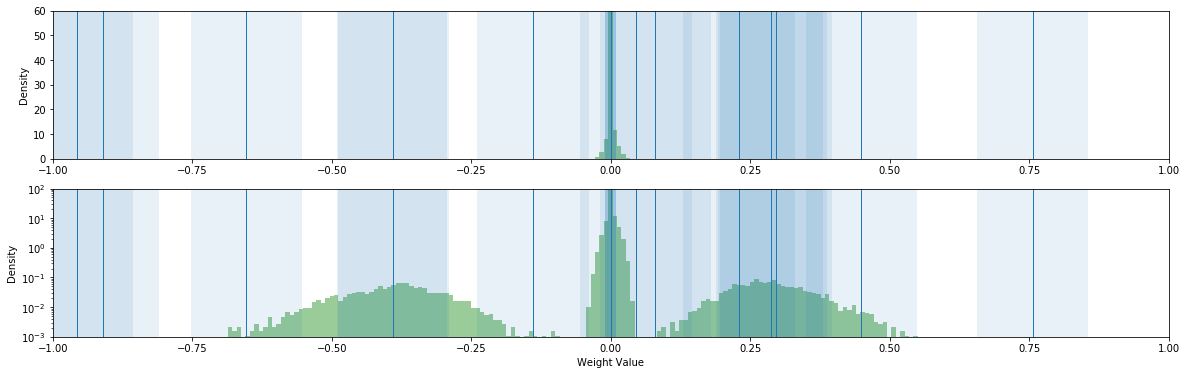

Original: 98.26% - Retrain: 96.74% - Prune: 93.51% - Quantize: 94.33% - Sparsity: 97.27%
Original: 98.15% - Retrain: 96.56% - Prune: 93.32% - Quantize: 93.84% - Sparsity: 97.27%
Original: 98.26% - Retrain: 96.74% - Prune: 93.51% - Quantize: 94.33% - Sparsity: 97.27%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -79.25


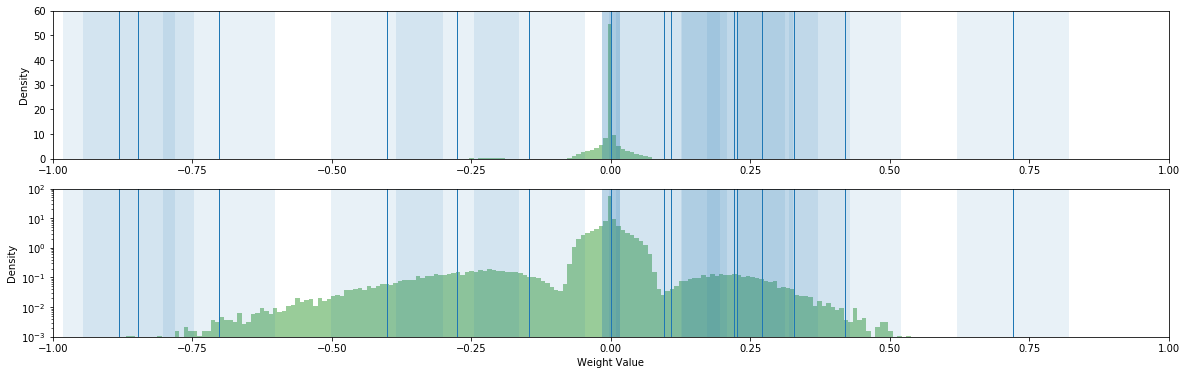

Original: 98.26% - Retrain: 98.19% - Prune: 97.25% - Quantize: 97.18% - Sparsity: 89.90%
Epoch: 50. Loss: -82.43


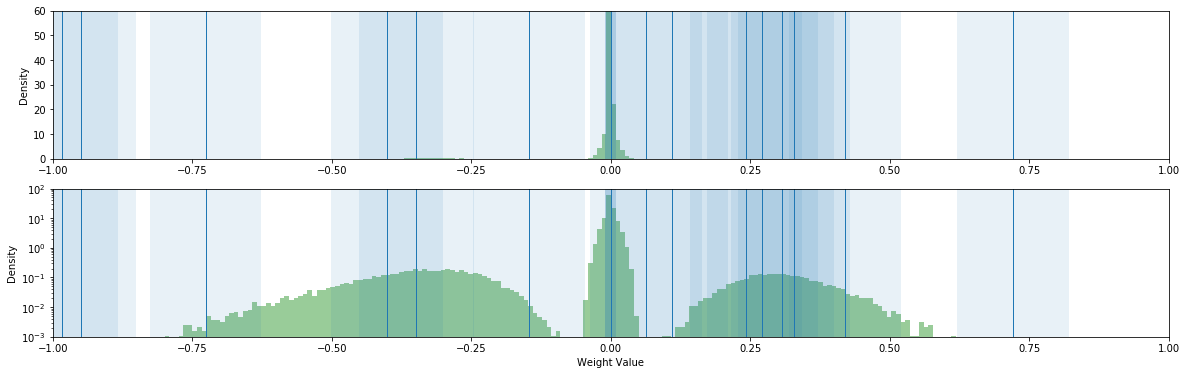

Original: 98.26% - Retrain: 98.07% - Prune: 97.47% - Quantize: 97.59% - Sparsity: 93.00%
Original: 98.15% - Retrain: 98.10% - Prune: 97.63% - Quantize: 97.69% - Sparsity: 93.00%
Original: 98.26% - Retrain: 98.07% - Prune: 97.47% - Quantize: 97.59% - Sparsity: 93.00%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: 0.19


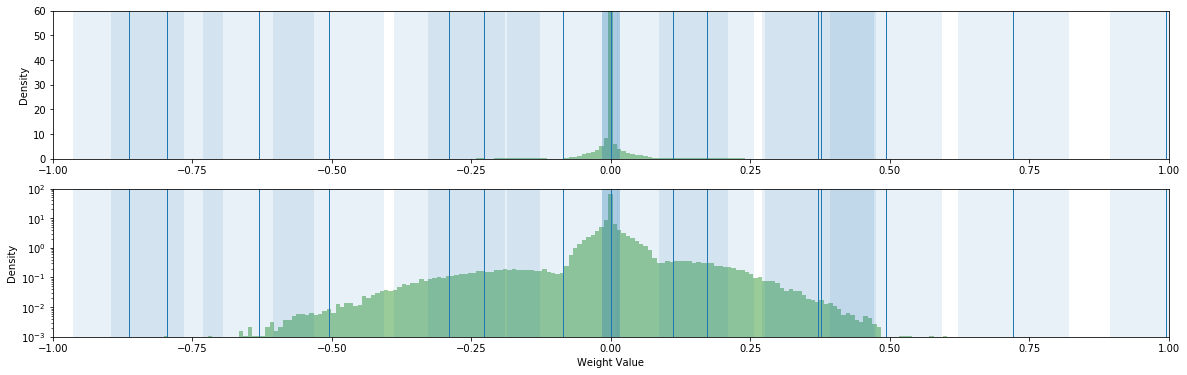

Original: 98.26% - Retrain: 98.03% - Prune: 97.85% - Quantize: 97.85% - Sparsity: 83.69%
Epoch: 50. Loss: -0.07


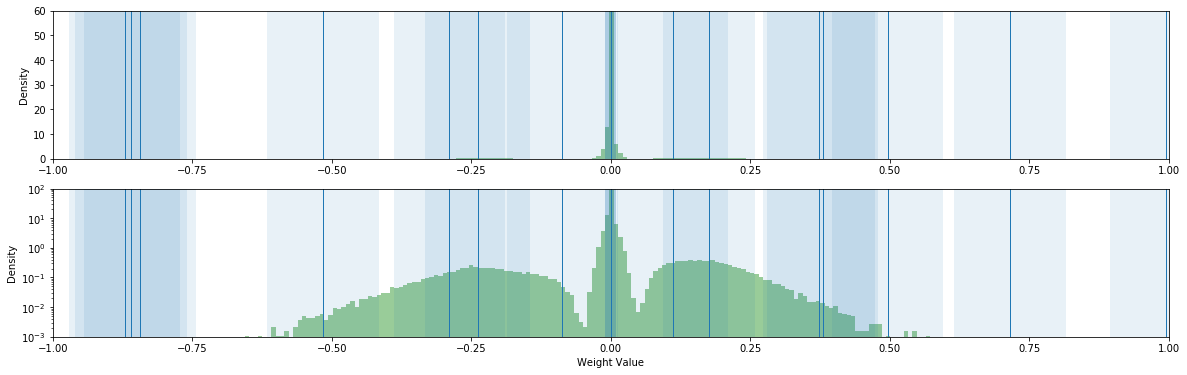

Original: 98.26% - Retrain: 97.77% - Prune: 97.40% - Quantize: 97.23% - Sparsity: 89.37%
Original: 98.15% - Retrain: 97.78% - Prune: 97.52% - Quantize: 97.42% - Sparsity: 89.37%
Original: 98.26% - Retrain: 97.77% - Prune: 97.40% - Quantize: 97.23% - Sparsity: 89.37%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -8598.99


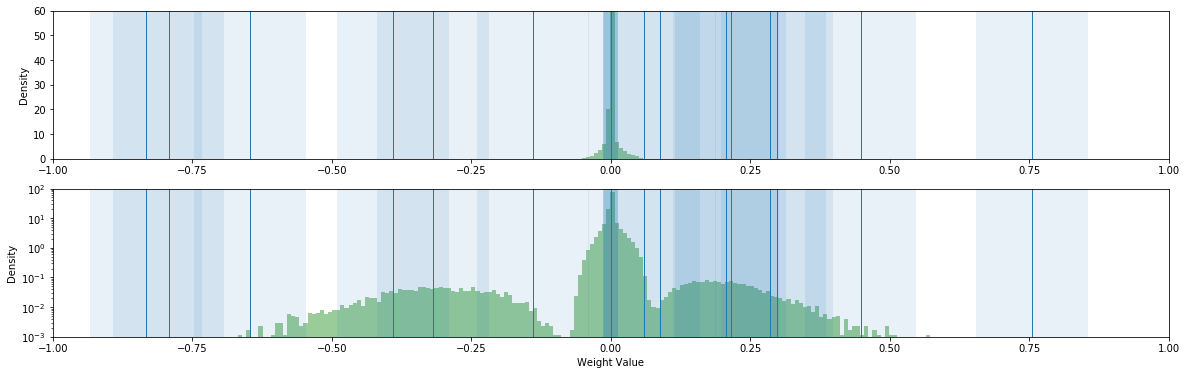

Original: 98.26% - Retrain: 97.19% - Prune: 92.94% - Quantize: 92.61% - Sparsity: 94.00%
Epoch: 50. Loss: -10513.78


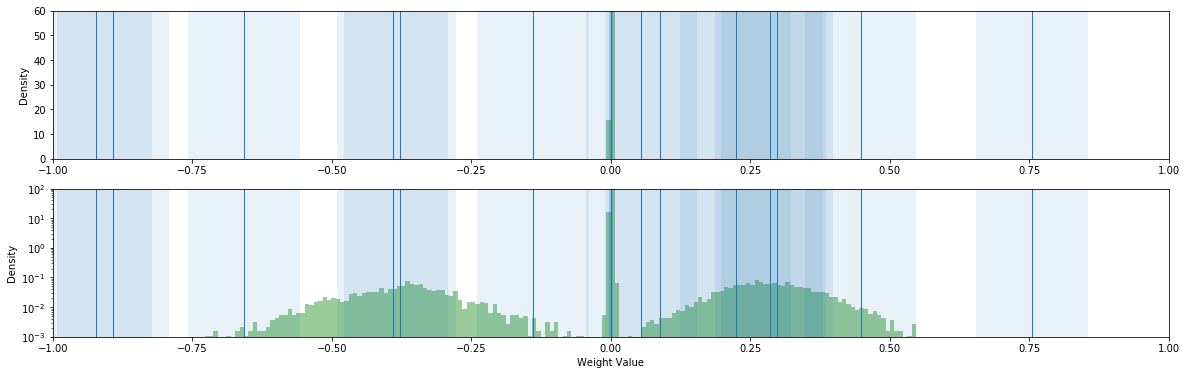

Original: 98.26% - Retrain: 95.97% - Prune: 95.37% - Quantize: 95.11% - Sparsity: 97.59%
Original: 98.15% - Retrain: 95.84% - Prune: 95.47% - Quantize: 95.31% - Sparsity: 97.59%
Original: 98.26% - Retrain: 95.97% - Prune: 95.37% - Quantize: 95.11% - Sparsity: 97.59%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -8598.27


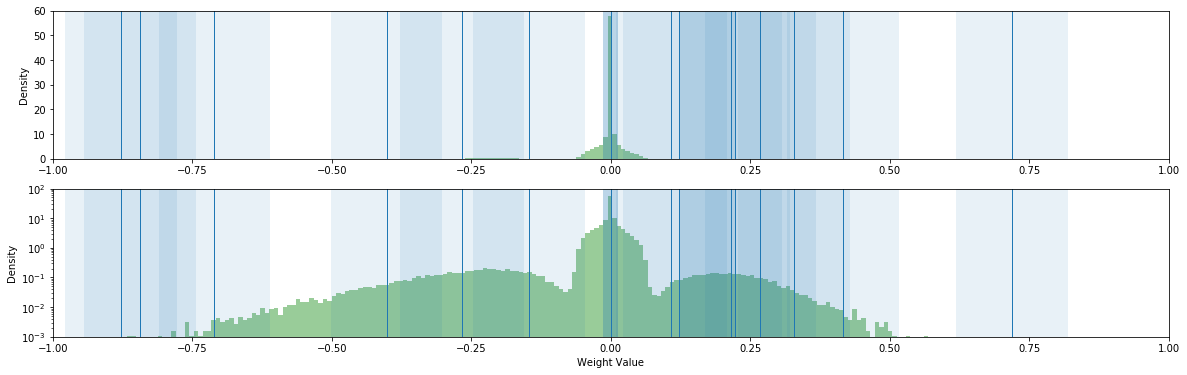

Original: 98.26% - Retrain: 98.10% - Prune: 96.86% - Quantize: 97.00% - Sparsity: 92.01%
Epoch: 50. Loss: -10513.42


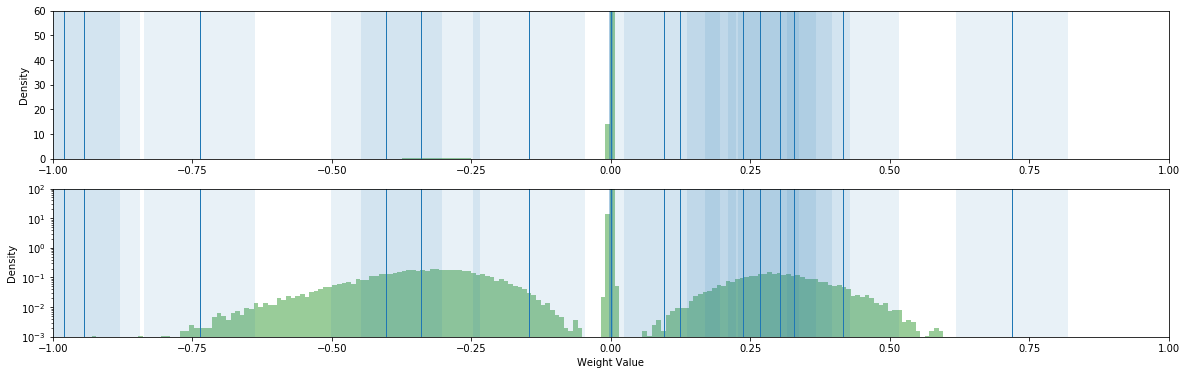

Original: 98.26% - Retrain: 97.75% - Prune: 97.71% - Quantize: 97.71% - Sparsity: 92.60%
Original: 98.15% - Retrain: 98.05% - Prune: 97.98% - Quantize: 97.93% - Sparsity: 92.60%
Original: 98.26% - Retrain: 97.75% - Prune: 97.71% - Quantize: 97.71% - Sparsity: 92.60%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 25. Loss: -8.50


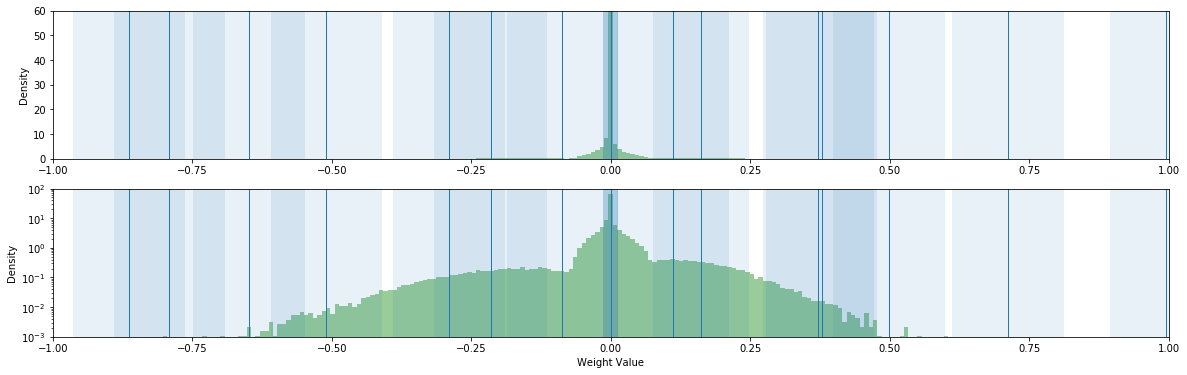

Original: 98.26% - Retrain: 97.97% - Prune: 97.79% - Quantize: 97.83% - Sparsity: 85.34%
Epoch: 50. Loss: -10.19


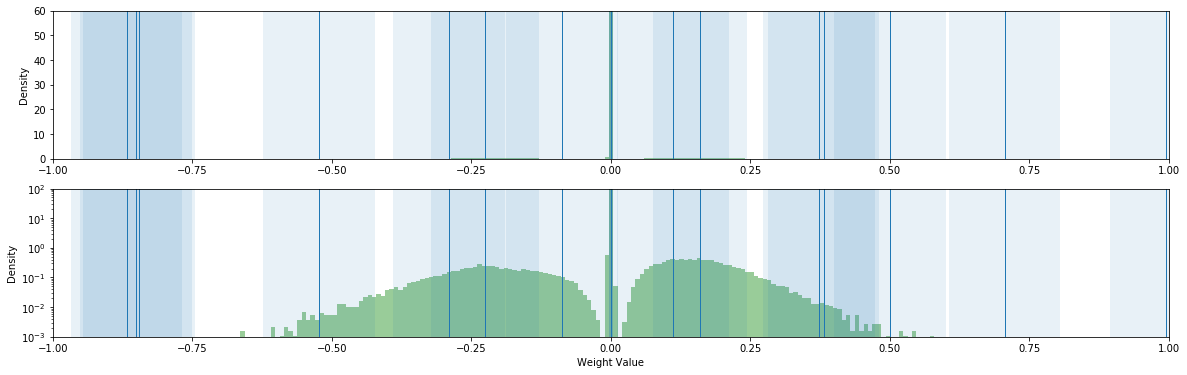

Original: 98.26% - Retrain: 97.64% - Prune: 97.63% - Quantize: 97.49% - Sparsity: 87.91%
Original: 98.15% - Retrain: 97.70% - Prune: 97.68% - Quantize: 97.63% - Sparsity: 87.91%
Original: 98.26% - Retrain: 97.64% - Prune: 97.63% - Quantize: 97.49% - Sparsity: 87.91%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -41.50


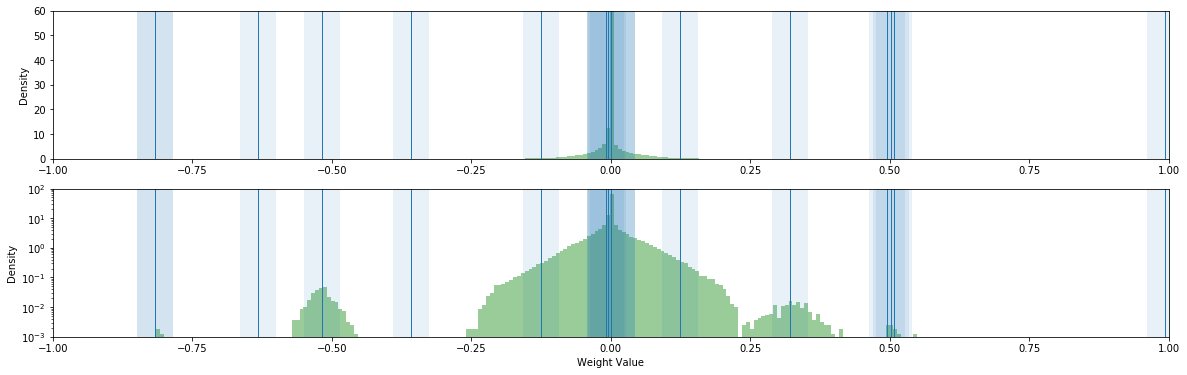

Original: 98.26% - Retrain: 98.05% - Prune: 97.45% - Quantize: 97.23% - Sparsity: 78.86%
Epoch: 50. Loss: -41.57


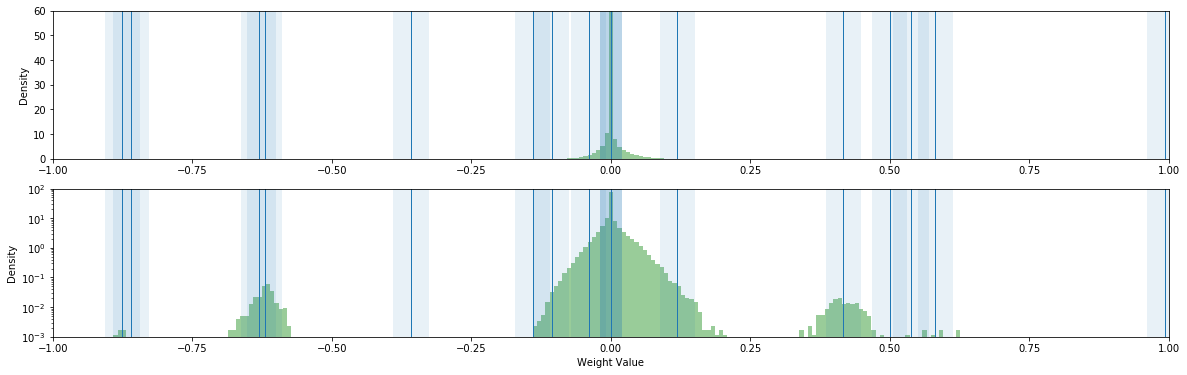

Original: 98.26% - Retrain: 96.53% - Prune: 90.73% - Quantize: 93.72% - Sparsity: 92.01%
Original: 98.15% - Retrain: 96.49% - Prune: 91.11% - Quantize: 94.12% - Sparsity: 92.01%
Original: 98.26% - Retrain: 96.53% - Prune: 90.73% - Quantize: 93.72% - Sparsity: 92.01%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -41.38


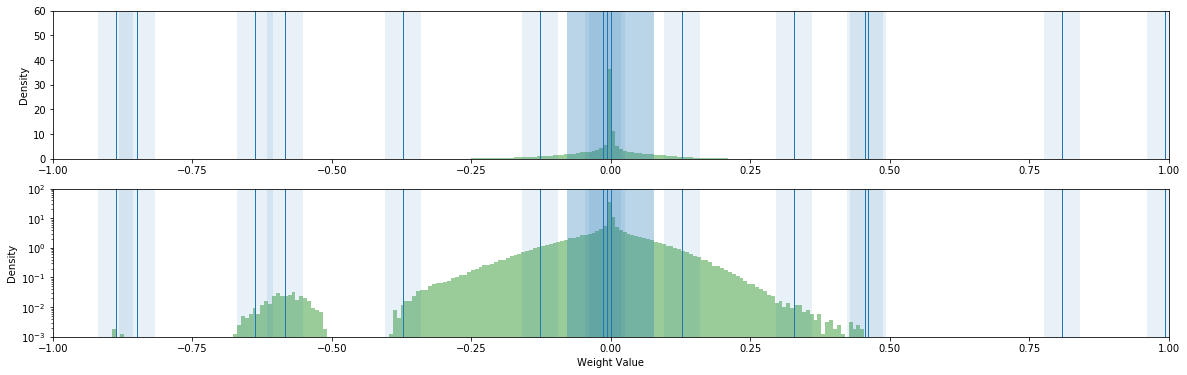

Original: 98.26% - Retrain: 98.27% - Prune: 97.90% - Quantize: 98.08% - Sparsity: 59.05%
Epoch: 50. Loss: -41.39


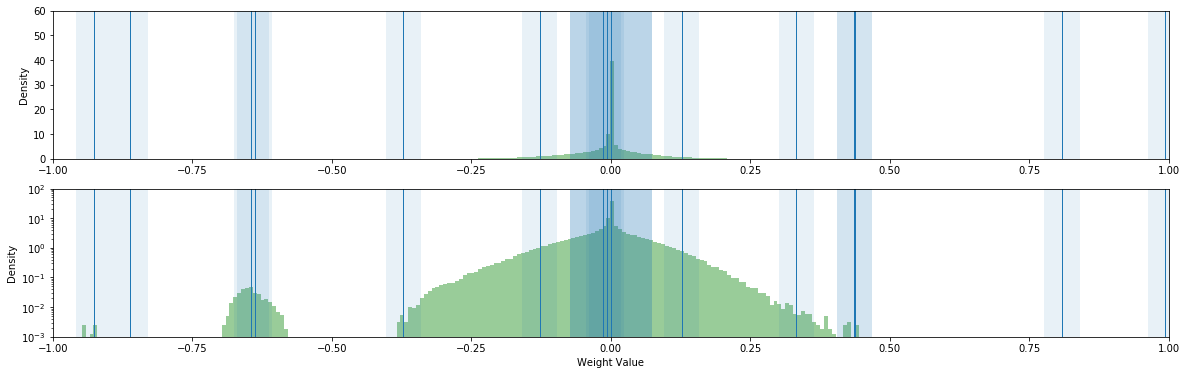

Original: 98.26% - Retrain: 98.28% - Prune: 97.92% - Quantize: 98.18% - Sparsity: 60.82%
Original: 98.15% - Retrain: 98.25% - Prune: 97.91% - Quantize: 98.04% - Sparsity: 60.82%
Original: 98.26% - Retrain: 98.28% - Prune: 97.92% - Quantize: 98.18% - Sparsity: 60.82%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: 0.13


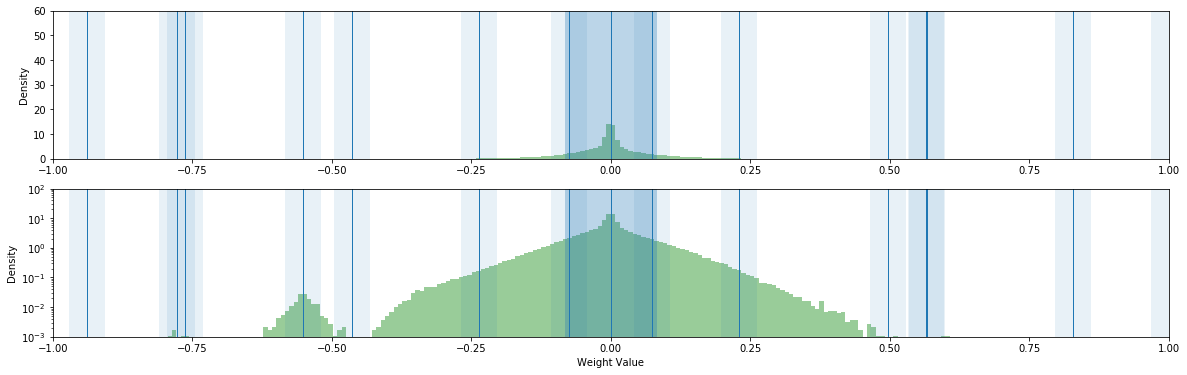

Original: 98.26% - Retrain: 98.20% - Prune: 98.13% - Quantize: 98.09% - Sparsity: 53.21%
Epoch: 50. Loss: -0.02


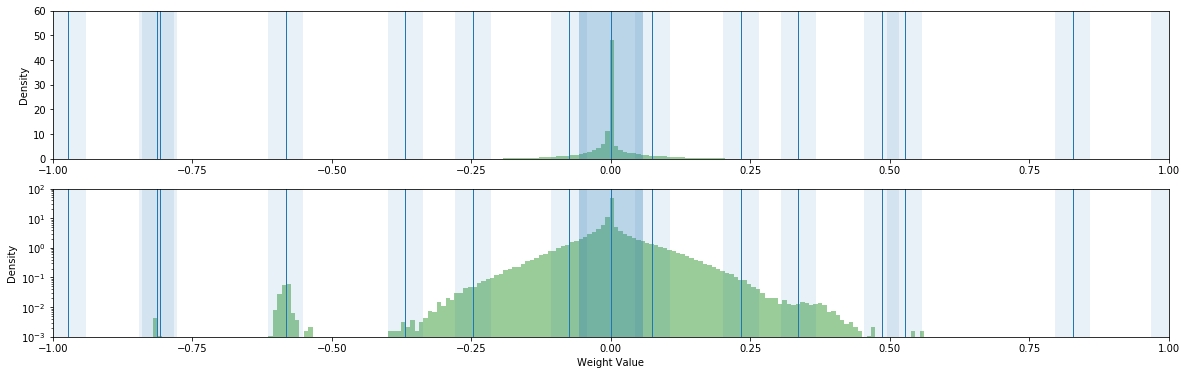

Original: 98.26% - Retrain: 98.00% - Prune: 98.02% - Quantize: 97.79% - Sparsity: 70.08%
Original: 98.15% - Retrain: 97.88% - Prune: 97.88% - Quantize: 97.71% - Sparsity: 70.08%
Original: 98.26% - Retrain: 98.00% - Prune: 98.02% - Quantize: 97.79% - Sparsity: 70.08%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -41.50


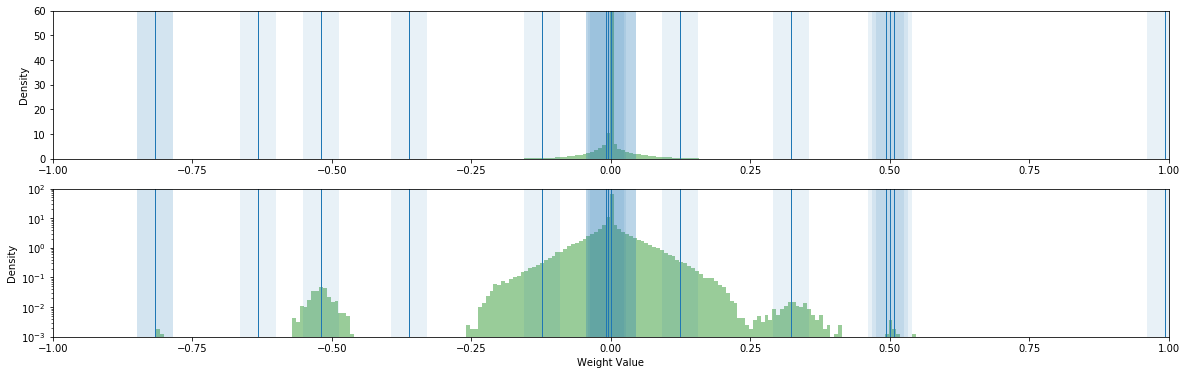

Original: 98.26% - Retrain: 98.09% - Prune: 97.51% - Quantize: 97.25% - Sparsity: 78.64%
Epoch: 50. Loss: -41.56


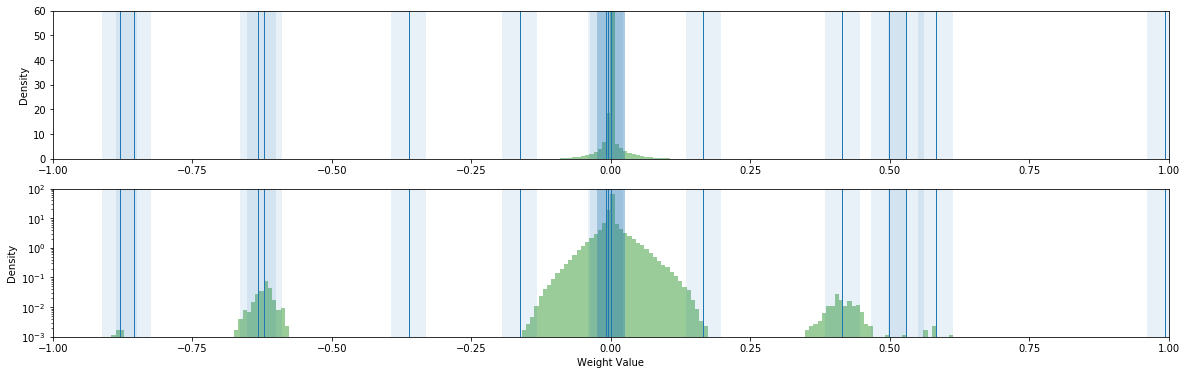

Original: 98.26% - Retrain: 97.00% - Prune: 74.31% - Quantize: 80.63% - Sparsity: 91.32%
Original: 98.15% - Retrain: 96.87% - Prune: 75.18% - Quantize: 80.65% - Sparsity: 91.32%
Original: 98.26% - Retrain: 97.00% - Prune: 74.31% - Quantize: 80.63% - Sparsity: 91.32%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -41.38


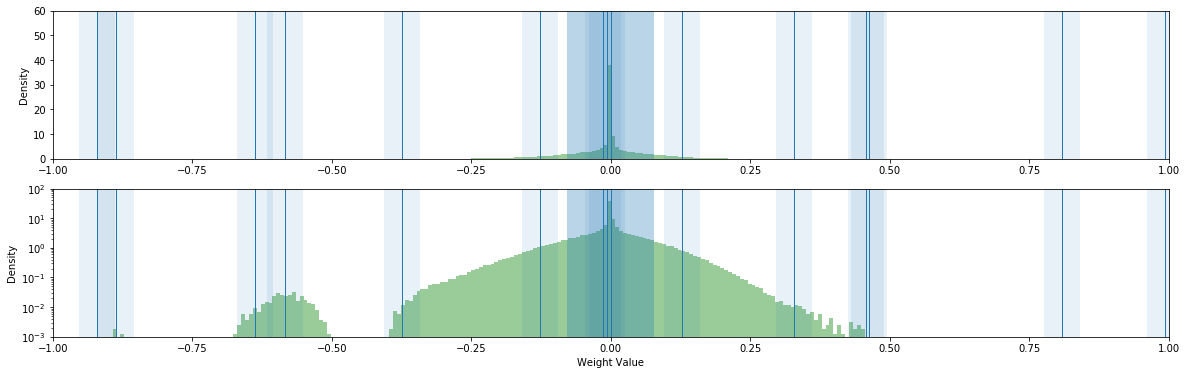

Original: 98.26% - Retrain: 98.28% - Prune: 97.91% - Quantize: 98.06% - Sparsity: 58.97%
Epoch: 50. Loss: -41.39


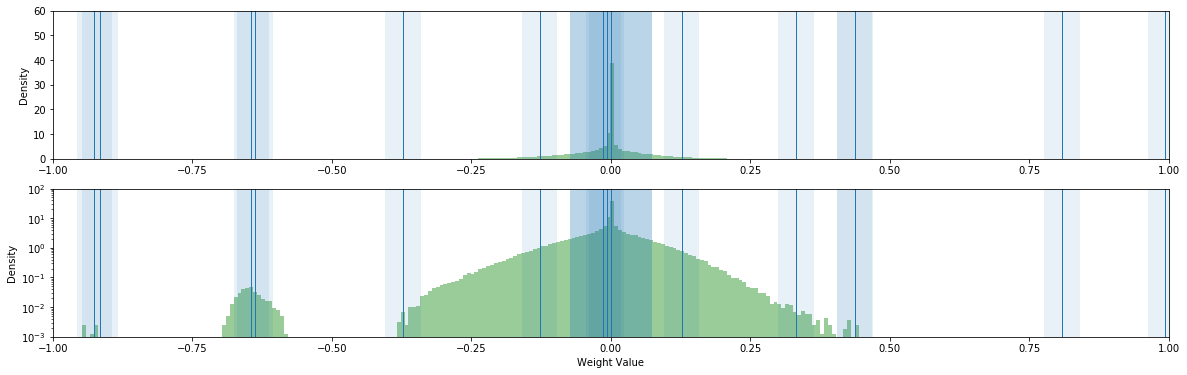

Original: 98.26% - Retrain: 98.29% - Prune: 97.89% - Quantize: 98.14% - Sparsity: 60.77%
Original: 98.15% - Retrain: 98.25% - Prune: 97.90% - Quantize: 98.02% - Sparsity: 60.77%
Original: 98.26% - Retrain: 98.29% - Prune: 97.89% - Quantize: 98.14% - Sparsity: 60.77%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: 0.09


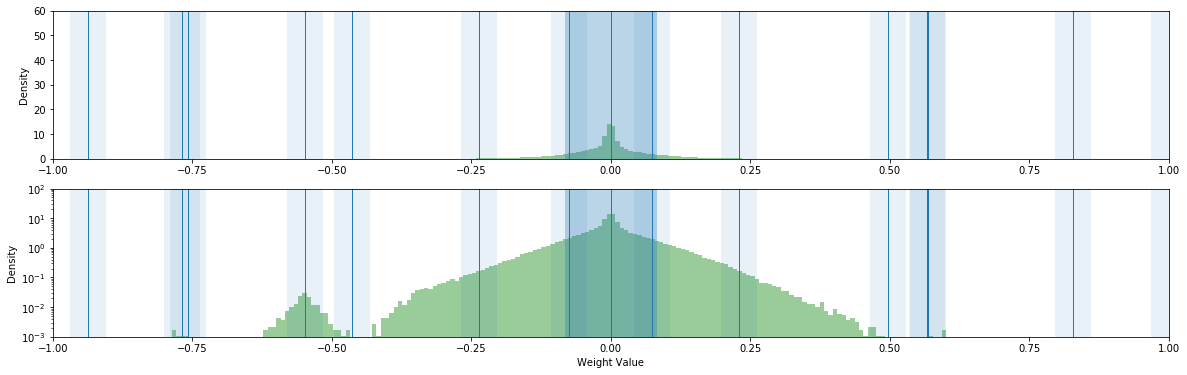

Original: 98.26% - Retrain: 98.21% - Prune: 98.10% - Quantize: 98.13% - Sparsity: 53.23%
Epoch: 50. Loss: 0.11


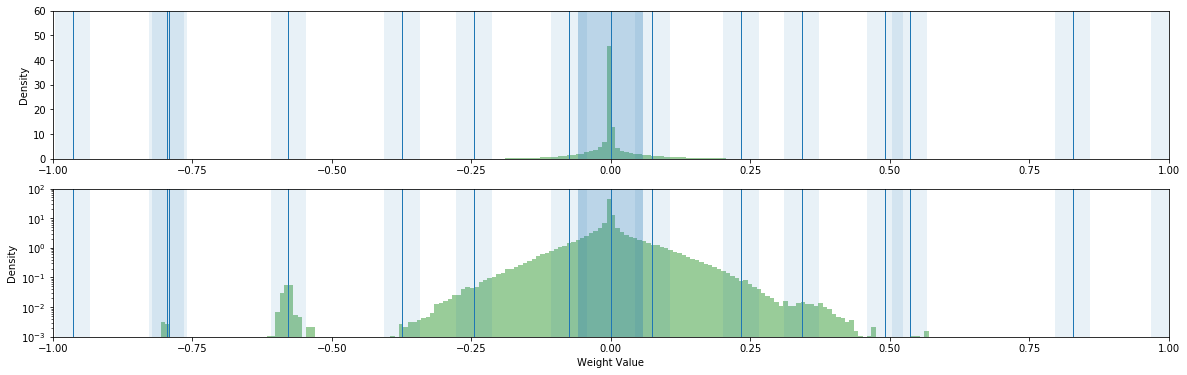

Original: 98.26% - Retrain: 98.00% - Prune: 98.00% - Quantize: 97.88% - Sparsity: 69.97%
Original: 98.15% - Retrain: 97.90% - Prune: 97.88% - Quantize: 97.74% - Sparsity: 69.97%
Original: 98.26% - Retrain: 98.00% - Prune: 98.00% - Quantize: 97.88% - Sparsity: 69.97%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -42.11


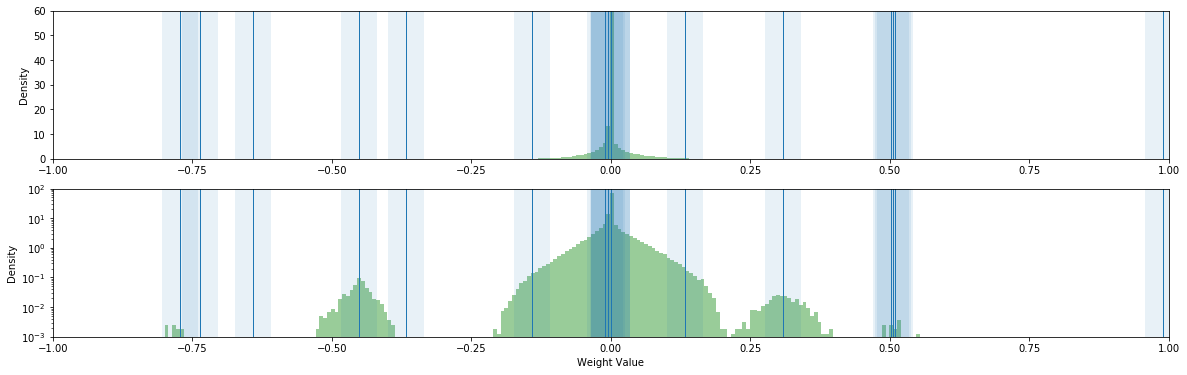

Original: 98.26% - Retrain: 97.80% - Prune: 96.58% - Quantize: 96.64% - Sparsity: 82.87%
Epoch: 50. Loss: -42.16


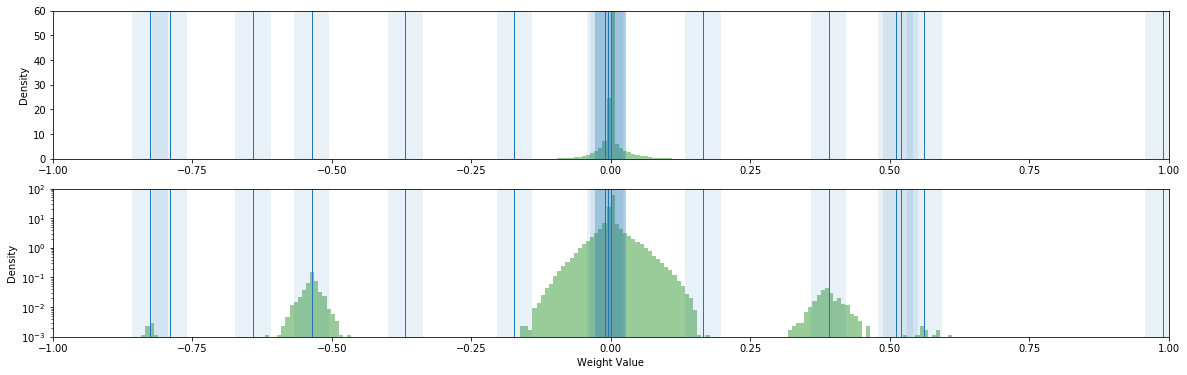

Original: 98.26% - Retrain: 97.35% - Prune: 78.31% - Quantize: 85.97% - Sparsity: 90.88%
Original: 98.15% - Retrain: 97.17% - Prune: 79.28% - Quantize: 85.63% - Sparsity: 90.88%
Original: 98.26% - Retrain: 97.35% - Prune: 78.31% - Quantize: 85.97% - Sparsity: 90.88%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -41.91


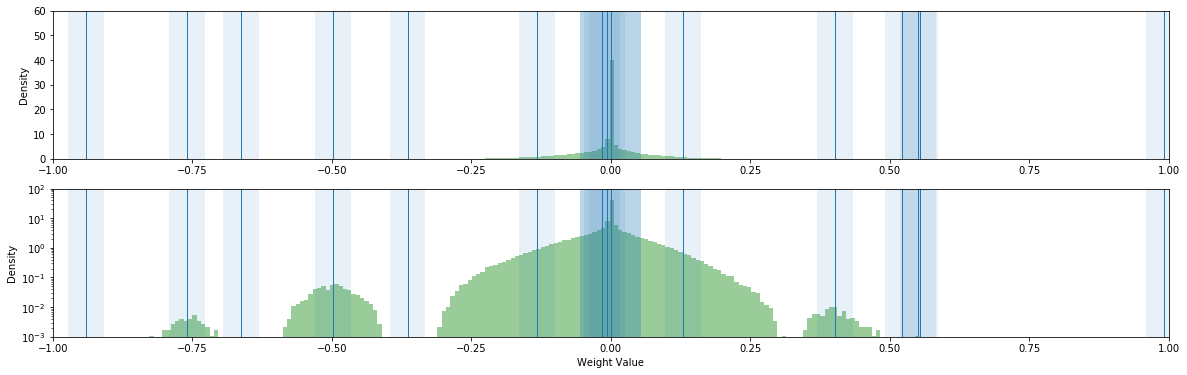

Original: 98.26% - Retrain: 98.28% - Prune: 97.76% - Quantize: 97.95% - Sparsity: 62.68%
Epoch: 50. Loss: -41.94


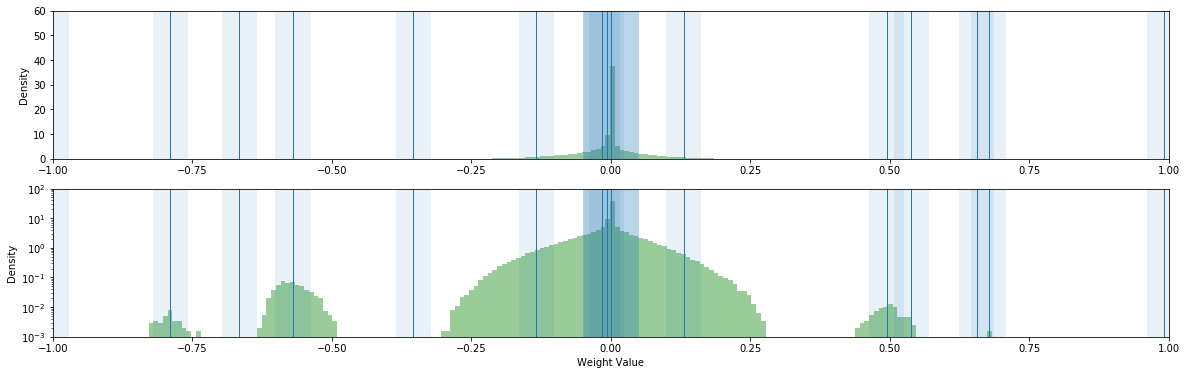

Original: 98.26% - Retrain: 98.28% - Prune: 97.73% - Quantize: 97.90% - Sparsity: 64.87%
Original: 98.15% - Retrain: 98.21% - Prune: 97.72% - Quantize: 97.91% - Sparsity: 64.87%
Original: 98.26% - Retrain: 98.28% - Prune: 97.73% - Quantize: 97.90% - Sparsity: 64.87%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: 0.07


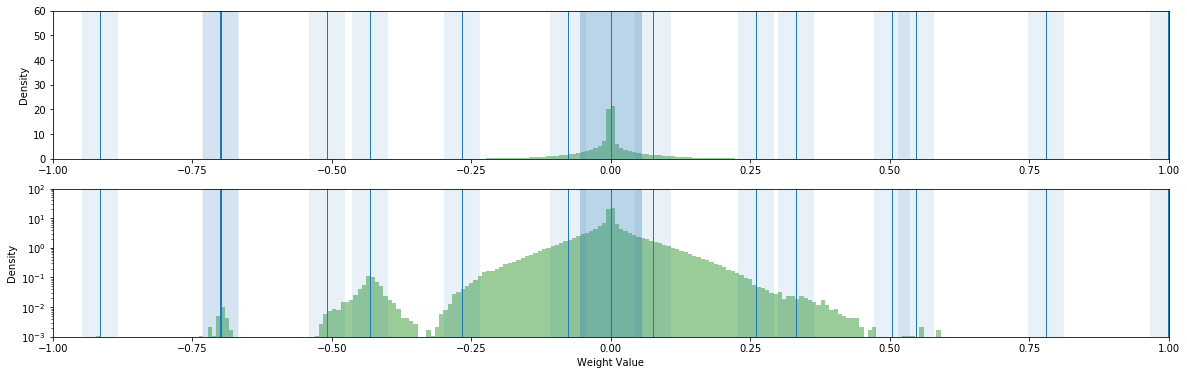

Original: 98.26% - Retrain: 98.15% - Prune: 98.06% - Quantize: 98.00% - Sparsity: 60.50%
Epoch: 50. Loss: -0.03


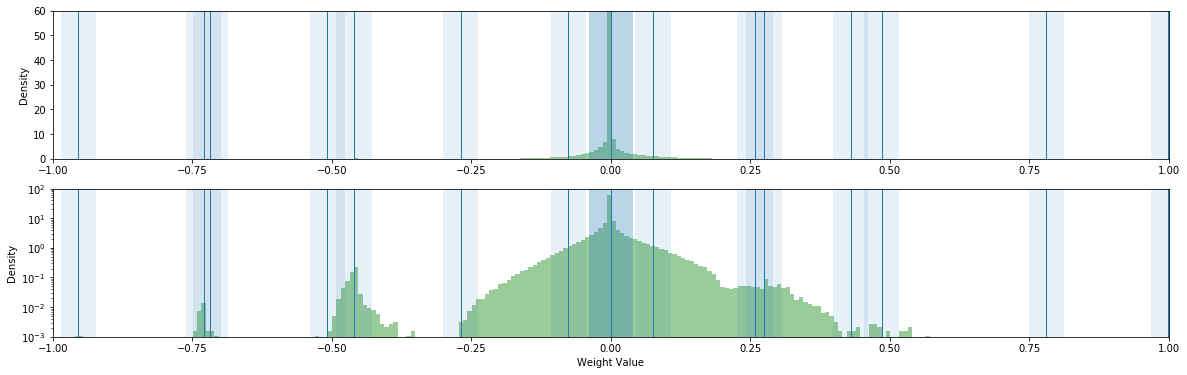

Original: 98.26% - Retrain: 97.84% - Prune: 97.82% - Quantize: 97.56% - Sparsity: 76.01%
Original: 98.15% - Retrain: 97.76% - Prune: 97.67% - Quantize: 97.54% - Sparsity: 76.01%
Original: 98.26% - Retrain: 97.84% - Prune: 97.82% - Quantize: 97.56% - Sparsity: 76.01%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -120.76


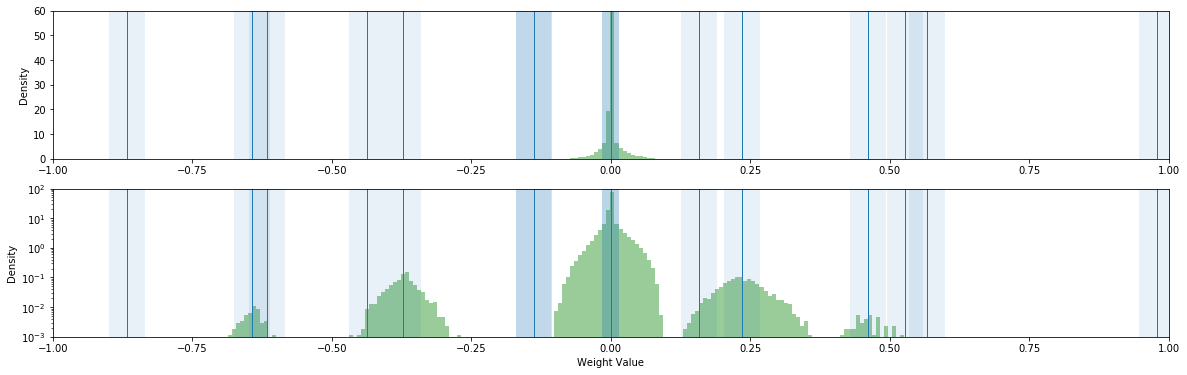

Original: 98.26% - Retrain: 97.09% - Prune: 78.80% - Quantize: 80.65% - Sparsity: 98.21%
Epoch: 50. Loss: -123.77


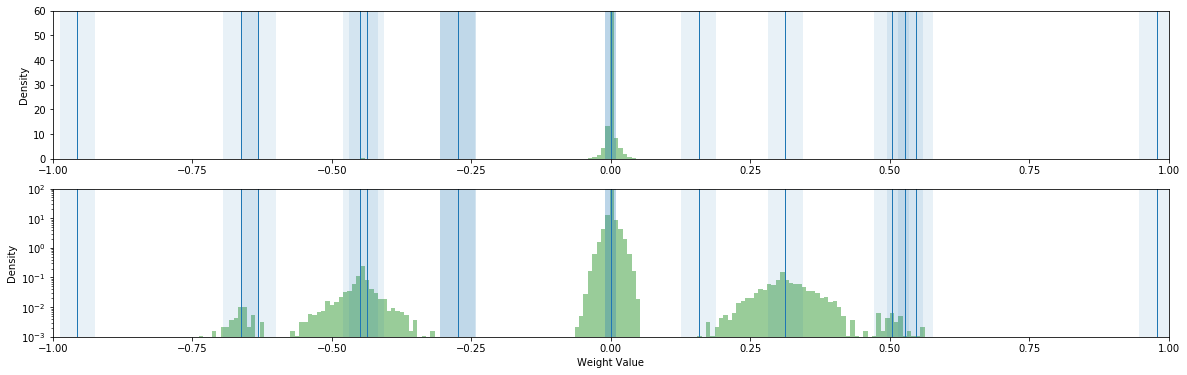

Original: 98.26% - Retrain: 96.09% - Prune: 81.79% - Quantize: 80.41% - Sparsity: 98.46%
Original: 98.15% - Retrain: 96.10% - Prune: 81.87% - Quantize: 80.29% - Sparsity: 98.46%
Original: 98.26% - Retrain: 96.09% - Prune: 81.79% - Quantize: 80.41% - Sparsity: 98.46%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -120.18


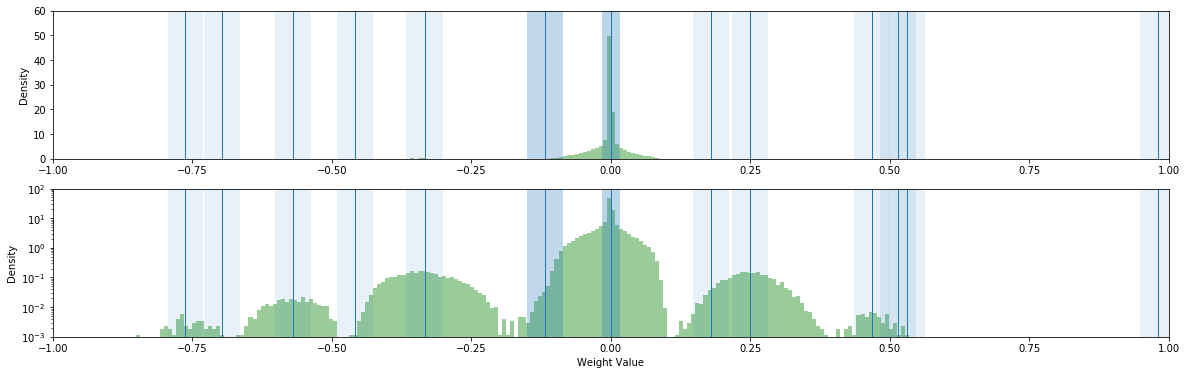

Original: 98.26% - Retrain: 98.16% - Prune: 94.20% - Quantize: 92.45% - Sparsity: 90.60%
Epoch: 50. Loss: -123.38


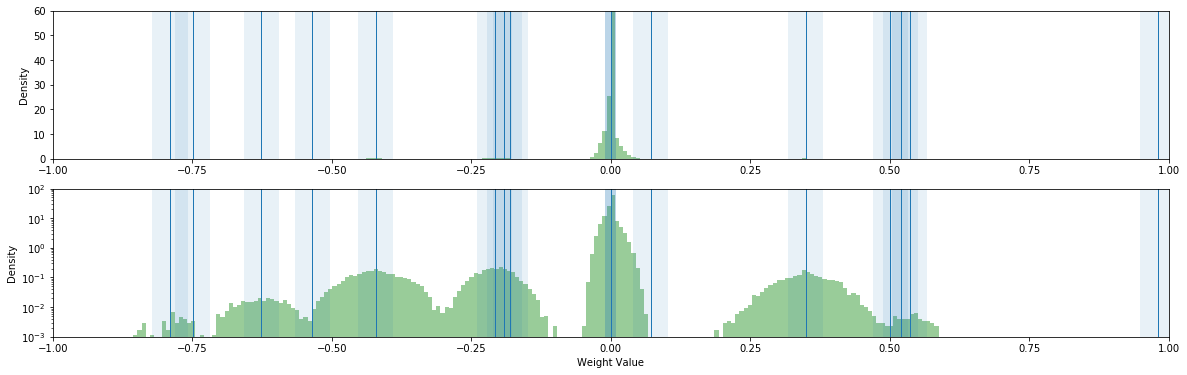

Original: 98.26% - Retrain: 97.87% - Prune: 96.95% - Quantize: 96.90% - Sparsity: 93.48%
Original: 98.15% - Retrain: 98.02% - Prune: 97.08% - Quantize: 96.88% - Sparsity: 93.48%
Original: 98.26% - Retrain: 97.87% - Prune: 96.95% - Quantize: 96.90% - Sparsity: 93.48%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: 0.02


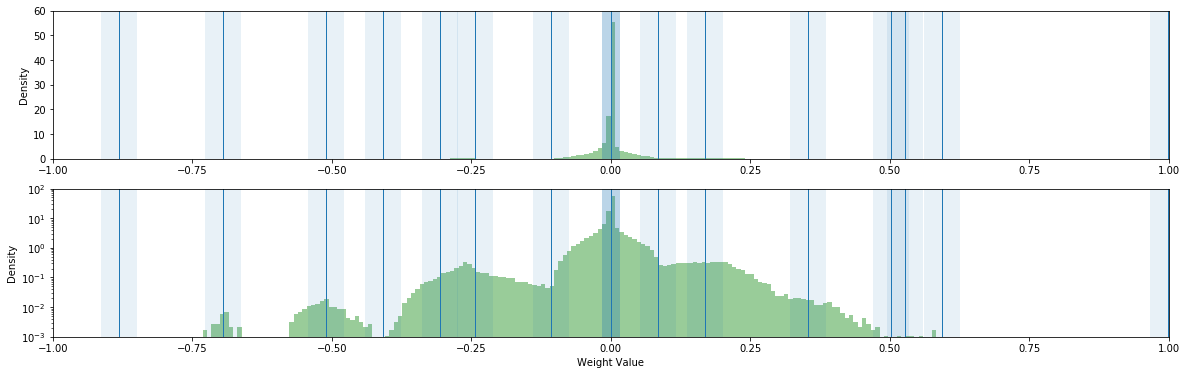

Original: 98.26% - Retrain: 97.94% - Prune: 96.98% - Quantize: 97.35% - Sparsity: 83.24%
Epoch: 50. Loss: -0.02


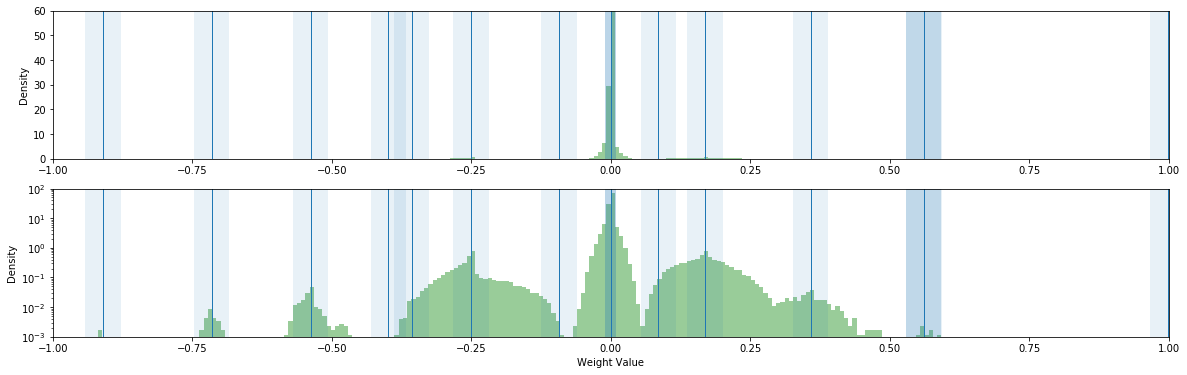

Original: 98.26% - Retrain: 97.29% - Prune: 96.34% - Quantize: 96.18% - Sparsity: 91.17%
Original: 98.15% - Retrain: 97.40% - Prune: 96.22% - Quantize: 96.03% - Sparsity: 91.17%
Original: 98.26% - Retrain: 97.29% - Prune: 96.34% - Quantize: 96.18% - Sparsity: 91.17%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -8639.99


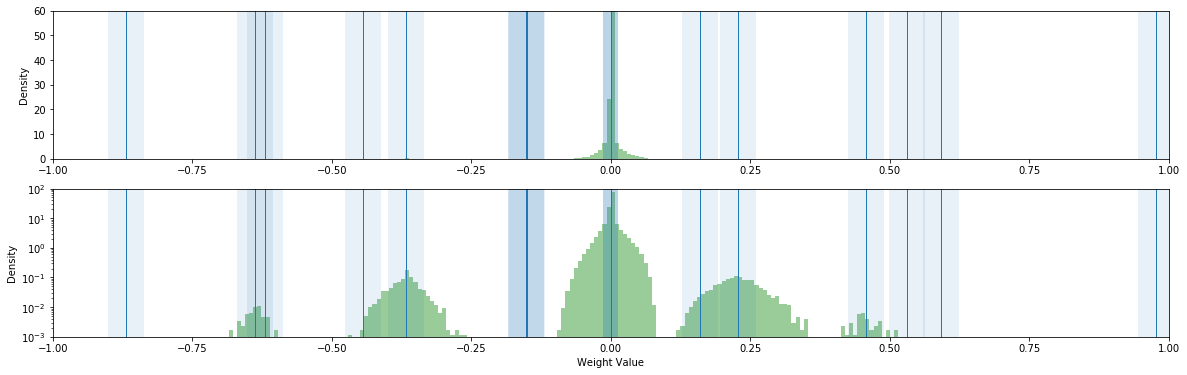

Original: 98.26% - Retrain: 96.88% - Prune: 80.38% - Quantize: 82.09% - Sparsity: 98.31%
Epoch: 50. Loss: -10554.77


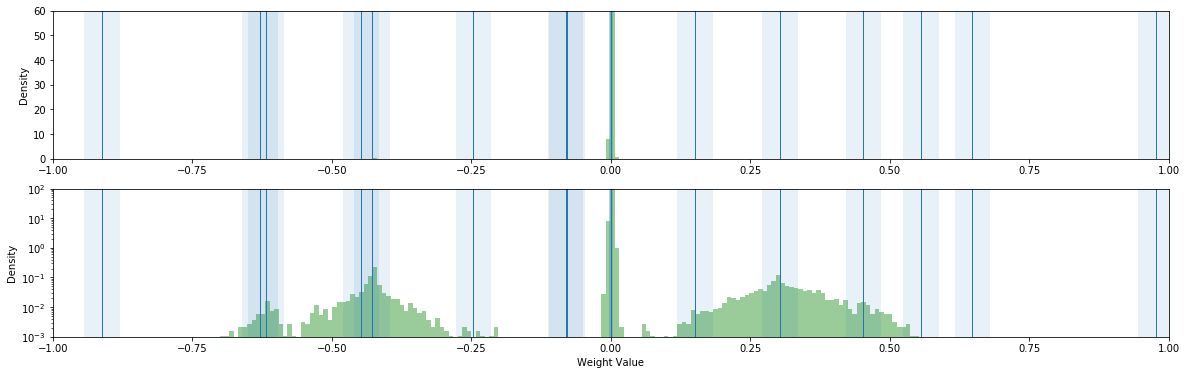

Original: 98.26% - Retrain: 93.90% - Prune: 89.06% - Quantize: 89.11% - Sparsity: 98.34%
Original: 98.15% - Retrain: 93.59% - Prune: 89.36% - Quantize: 89.44% - Sparsity: 98.34%
Original: 98.26% - Retrain: 93.90% - Prune: 89.06% - Quantize: 89.11% - Sparsity: 98.34%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -8639.31


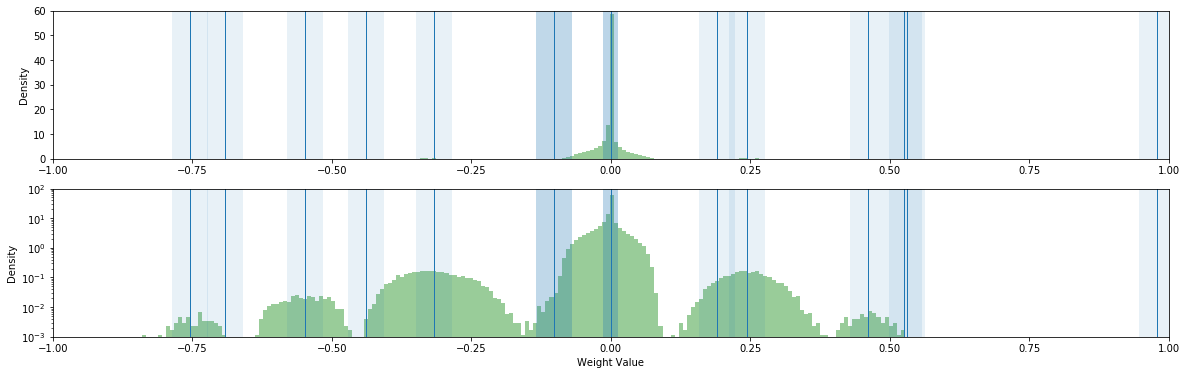

Original: 98.26% - Retrain: 98.16% - Prune: 95.20% - Quantize: 94.03% - Sparsity: 90.21%
Epoch: 50. Loss: -10554.30


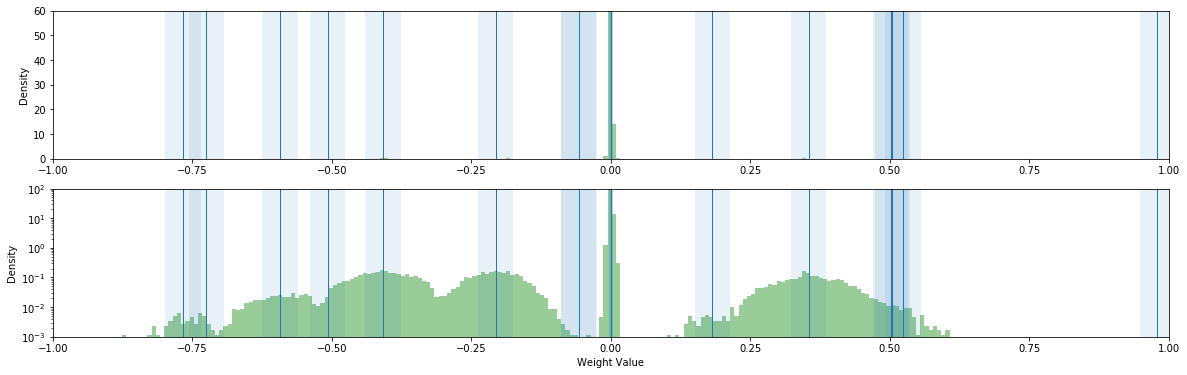

Original: 98.26% - Retrain: 97.53% - Prune: 97.36% - Quantize: 97.22% - Sparsity: 93.95%
Original: 98.15% - Retrain: 97.60% - Prune: 97.40% - Quantize: 97.26% - Sparsity: 93.95%
Original: 98.26% - Retrain: 97.53% - Prune: 97.36% - Quantize: 97.22% - Sparsity: 93.95%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 25. Loss: -8.63


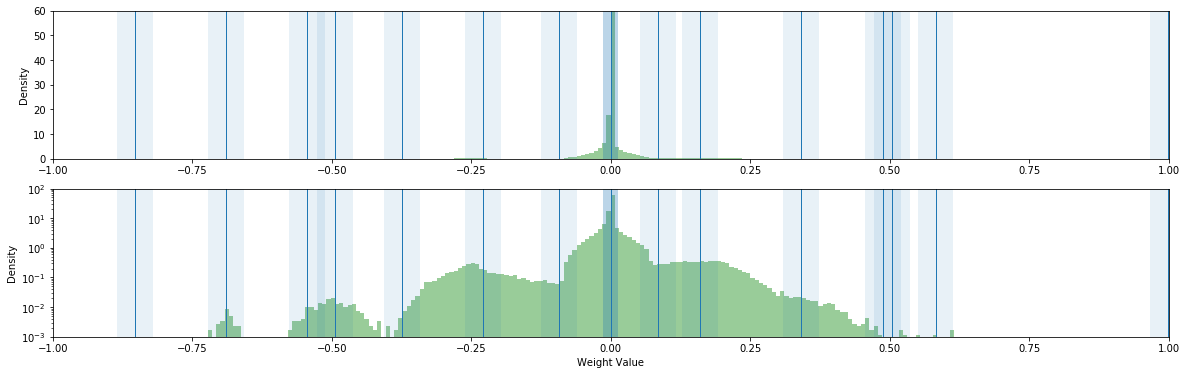

Original: 98.26% - Retrain: 97.90% - Prune: 97.25% - Quantize: 97.33% - Sparsity: 83.93%
Epoch: 50. Loss: -10.30


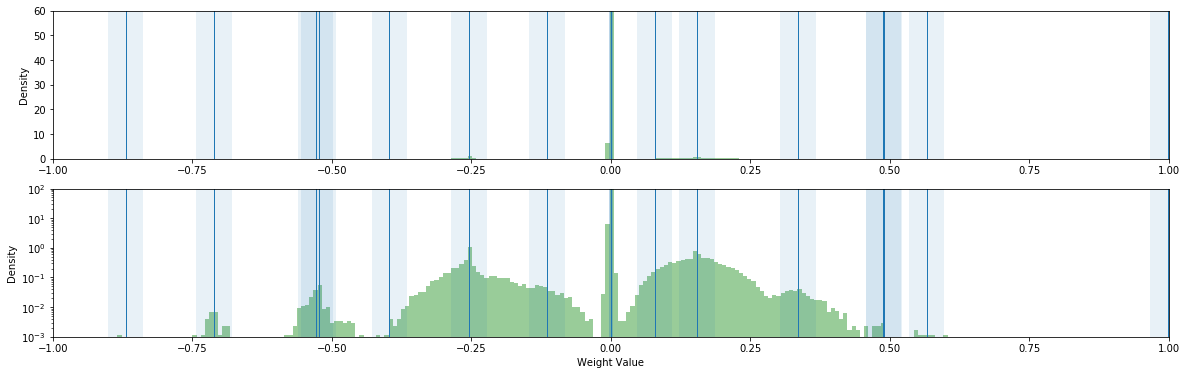

Original: 98.26% - Retrain: 97.07% - Prune: 96.73% - Quantize: 96.72% - Sparsity: 89.98%
Original: 98.15% - Retrain: 97.15% - Prune: 96.84% - Quantize: 96.76% - Sparsity: 89.98%
Original: 98.26% - Retrain: 97.07% - Prune: 96.73% - Quantize: 96.72% - Sparsity: 89.98%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5547.30


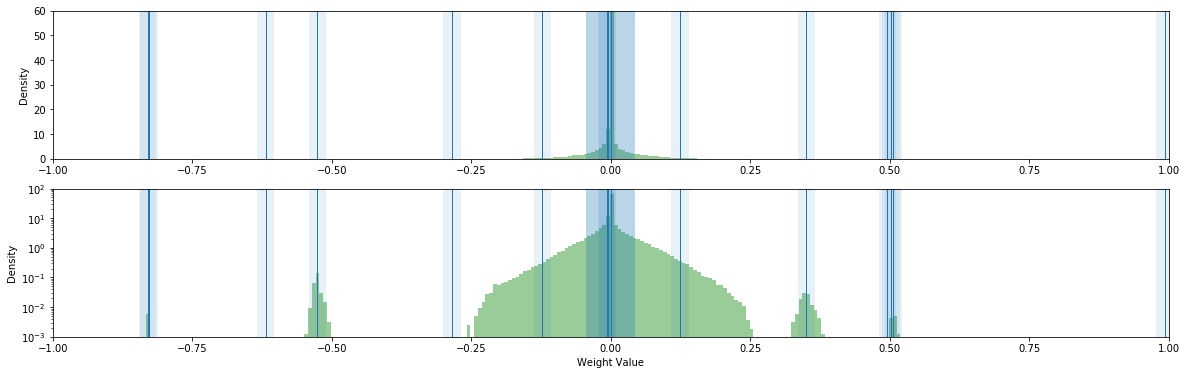

Original: 98.26% - Retrain: 98.07% - Prune: 97.49% - Quantize: 97.37% - Sparsity: 78.75%
Epoch: 50. Loss: -5747.45


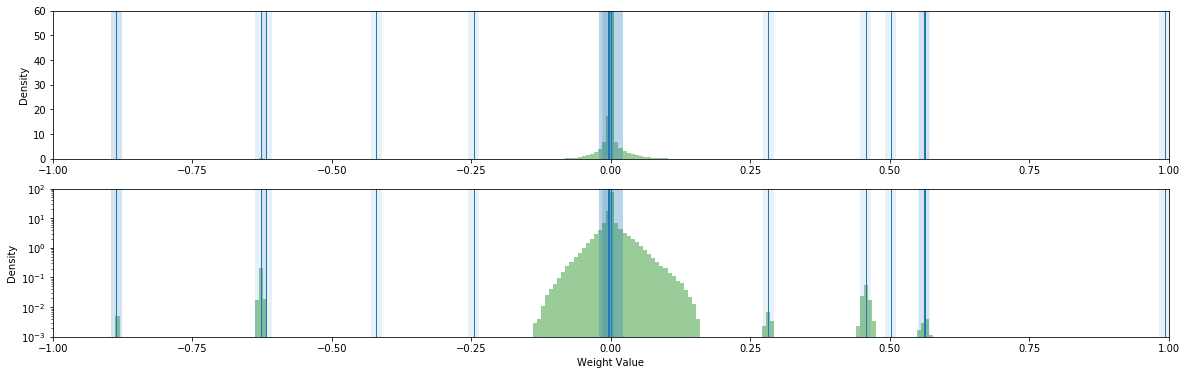

Original: 98.26% - Retrain: 96.71% - Prune: 20.12% - Quantize: 34.89% - Sparsity: 93.42%
Original: 98.15% - Retrain: 96.61% - Prune: 19.88% - Quantize: 34.47% - Sparsity: 93.42%
Original: 98.26% - Retrain: 96.71% - Prune: 20.12% - Quantize: 34.89% - Sparsity: 93.42%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5547.18


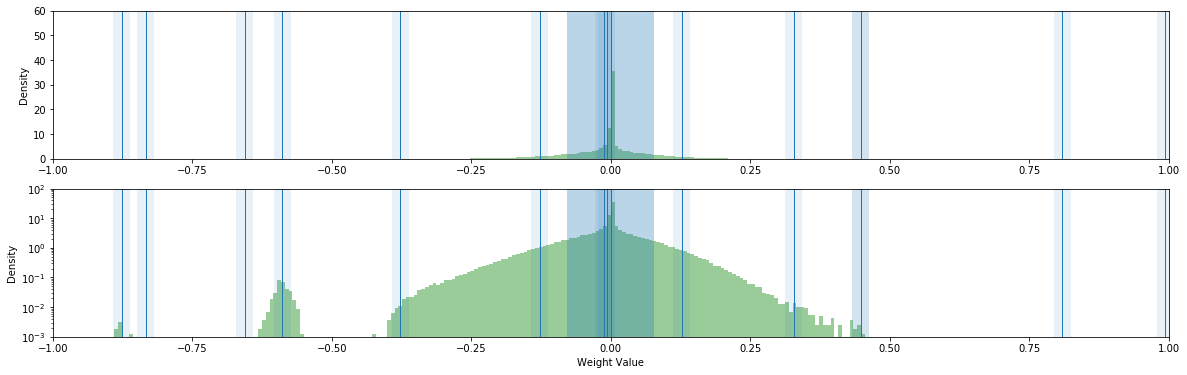

Original: 98.26% - Retrain: 98.29% - Prune: 97.91% - Quantize: 98.05% - Sparsity: 58.96%
Epoch: 50. Loss: -5747.26


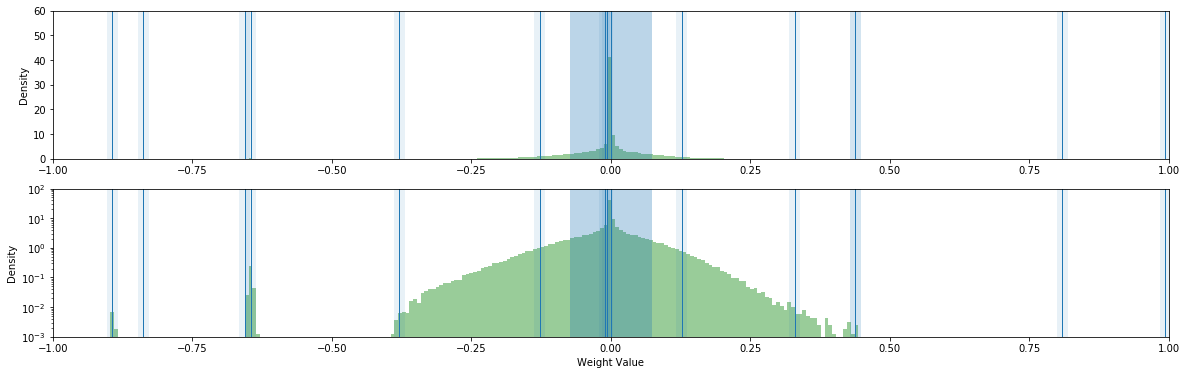

Original: 98.26% - Retrain: 98.29% - Prune: 97.87% - Quantize: 98.15% - Sparsity: 60.75%
Original: 98.15% - Retrain: 98.26% - Prune: 97.89% - Quantize: 98.05% - Sparsity: 60.75%
Original: 98.26% - Retrain: 98.29% - Prune: 97.87% - Quantize: 98.15% - Sparsity: 60.75%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5.45


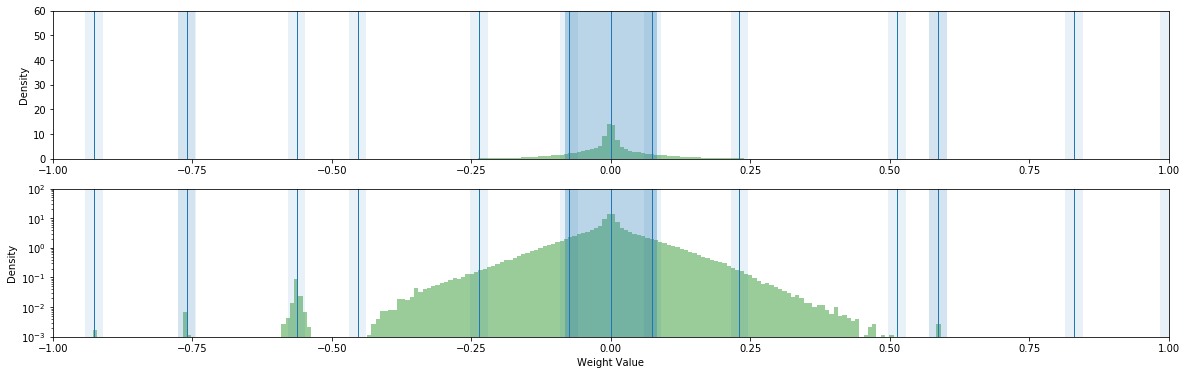

Original: 98.26% - Retrain: 98.18% - Prune: 98.13% - Quantize: 98.07% - Sparsity: 53.16%
Epoch: 50. Loss: -5.70


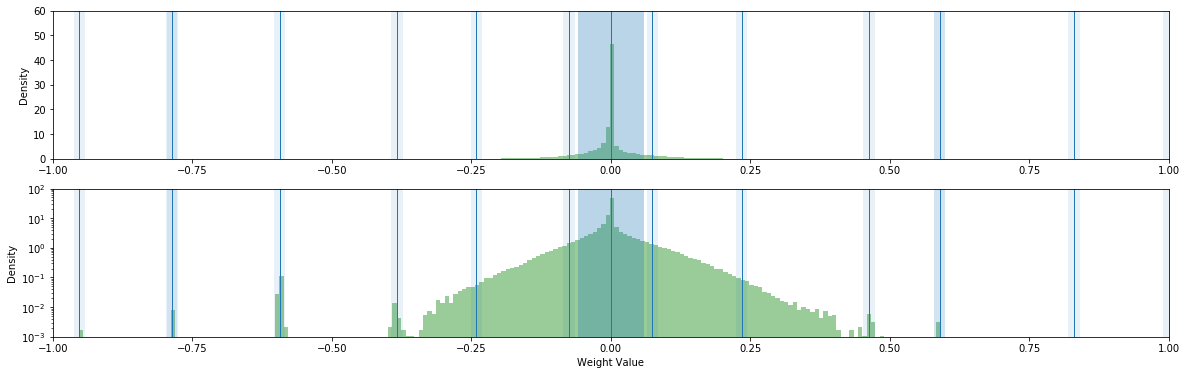

Original: 98.26% - Retrain: 98.00% - Prune: 98.00% - Quantize: 97.85% - Sparsity: 69.79%
Original: 98.15% - Retrain: 97.86% - Prune: 97.84% - Quantize: 97.89% - Sparsity: 69.79%
Original: 98.26% - Retrain: 98.00% - Prune: 98.00% - Quantize: 97.85% - Sparsity: 69.79%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5547.29


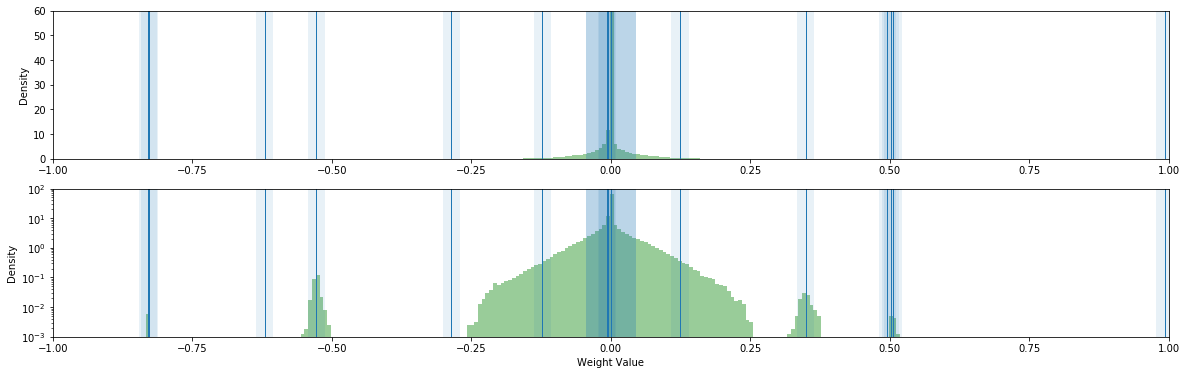

Original: 98.26% - Retrain: 98.09% - Prune: 97.56% - Quantize: 97.40% - Sparsity: 78.51%
Epoch: 50. Loss: -5747.46


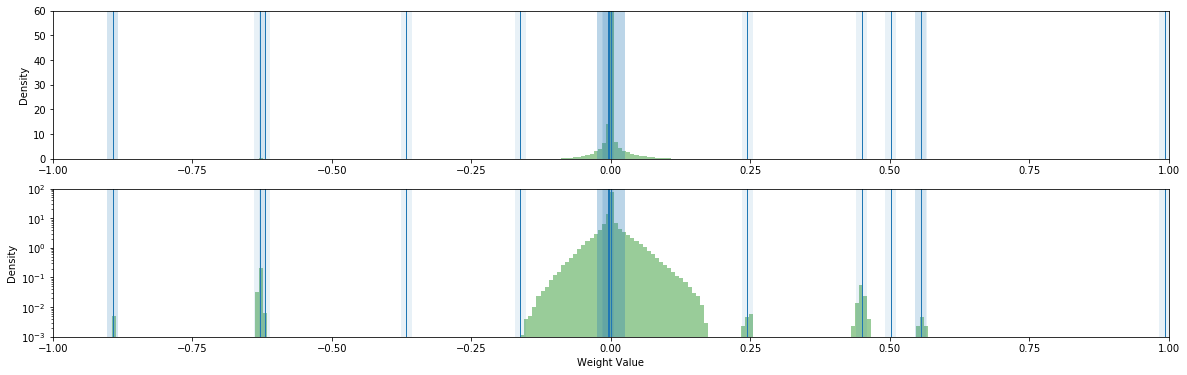

Original: 98.26% - Retrain: 96.99% - Prune: 33.71% - Quantize: 49.58% - Sparsity: 91.88%
Original: 98.15% - Retrain: 96.93% - Prune: 33.20% - Quantize: 49.86% - Sparsity: 91.88%
Original: 98.26% - Retrain: 96.99% - Prune: 33.71% - Quantize: 49.58% - Sparsity: 91.88%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5547.17


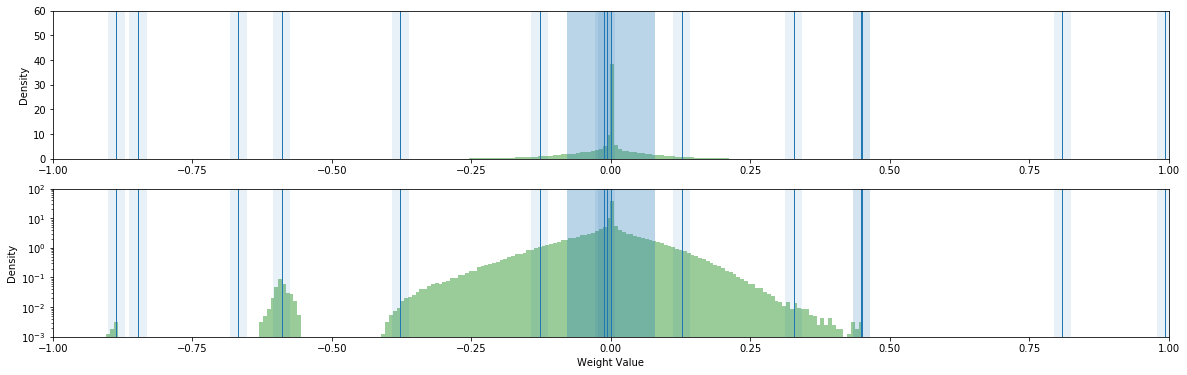

Original: 98.26% - Retrain: 98.27% - Prune: 97.93% - Quantize: 98.05% - Sparsity: 58.95%
Epoch: 50. Loss: -5747.28


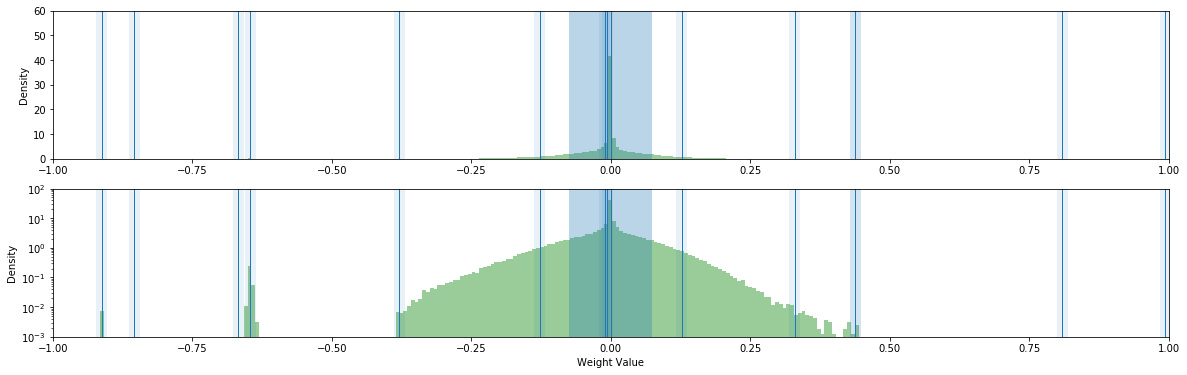

Original: 98.26% - Retrain: 98.28% - Prune: 97.90% - Quantize: 98.12% - Sparsity: 60.72%
Original: 98.15% - Retrain: 98.28% - Prune: 97.89% - Quantize: 98.05% - Sparsity: 60.72%
Original: 98.26% - Retrain: 98.28% - Prune: 97.90% - Quantize: 98.12% - Sparsity: 60.72%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5.51


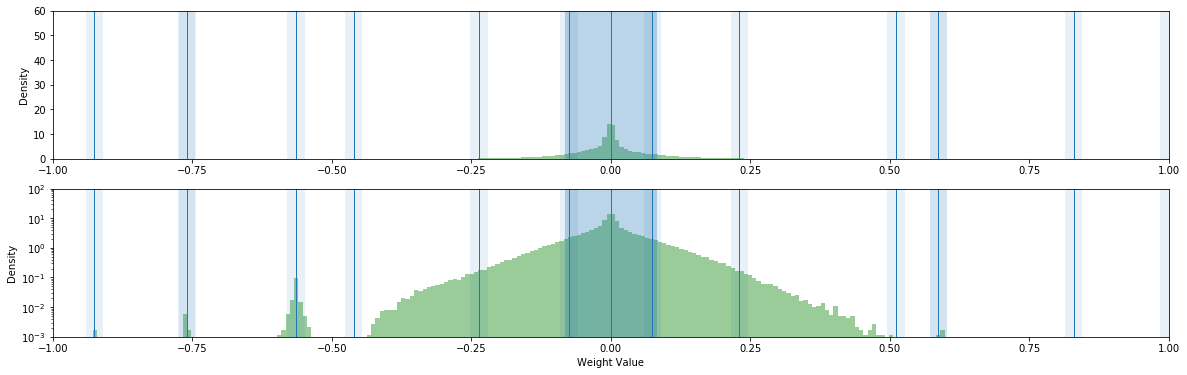

Original: 98.26% - Retrain: 98.20% - Prune: 98.11% - Quantize: 98.08% - Sparsity: 53.21%
Epoch: 50. Loss: -5.66


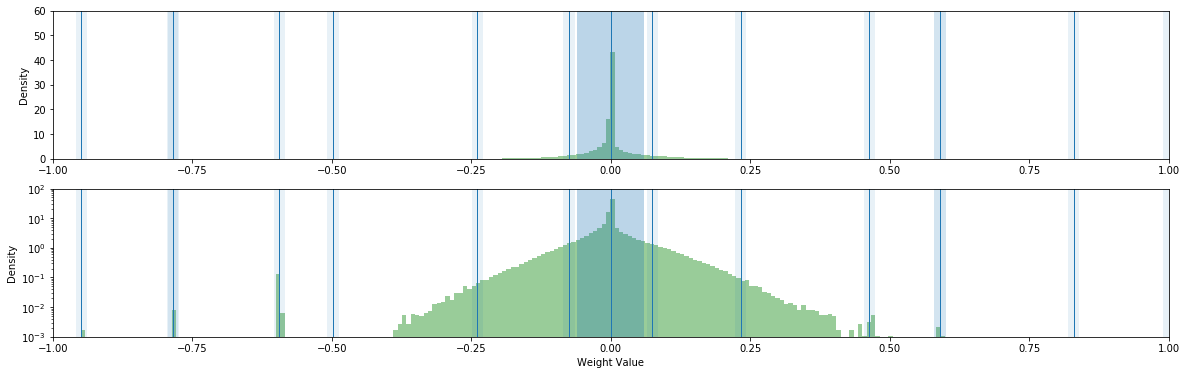

Original: 98.26% - Retrain: 97.96% - Prune: 97.99% - Quantize: 97.91% - Sparsity: 69.67%
Original: 98.15% - Retrain: 97.88% - Prune: 97.84% - Quantize: 97.83% - Sparsity: 69.67%
Original: 98.26% - Retrain: 97.96% - Prune: 97.99% - Quantize: 97.91% - Sparsity: 69.67%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5547.91


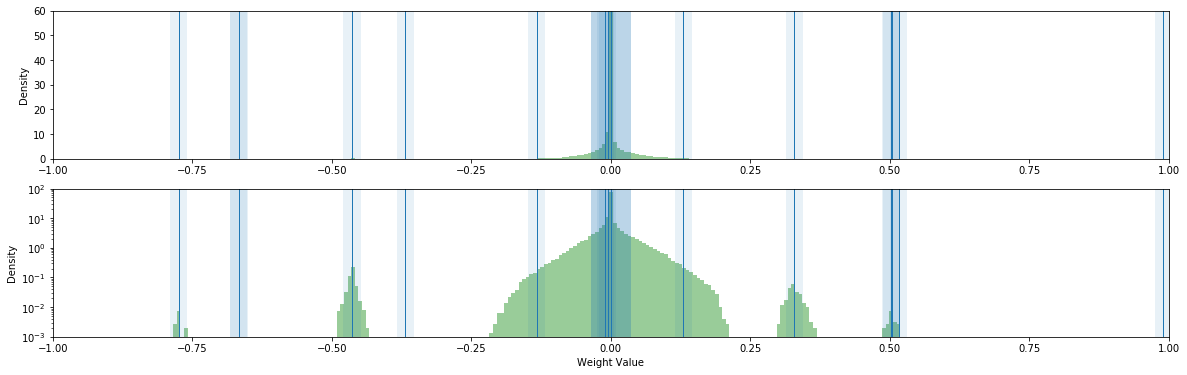

Original: 98.26% - Retrain: 97.78% - Prune: 96.80% - Quantize: 96.96% - Sparsity: 82.55%
Epoch: 50. Loss: -5748.03


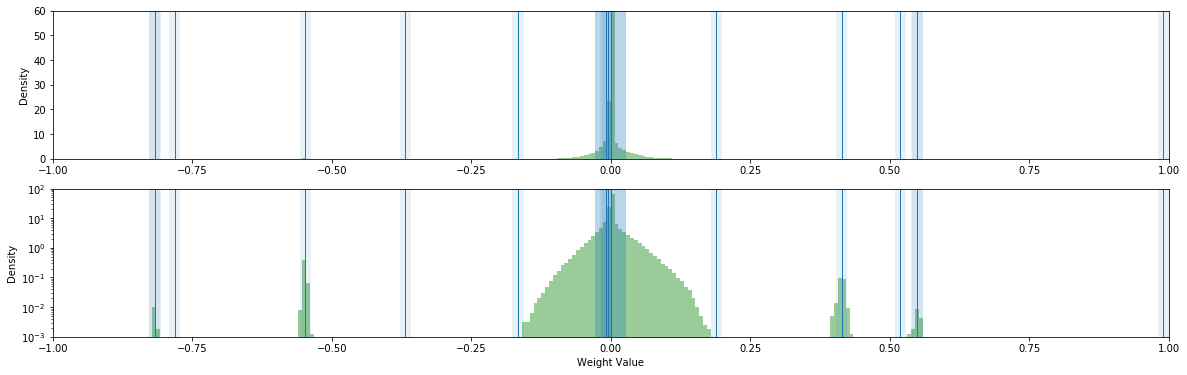

Original: 98.26% - Retrain: 97.21% - Prune: 64.54% - Quantize: 72.34% - Sparsity: 91.15%
Original: 98.15% - Retrain: 97.25% - Prune: 65.21% - Quantize: 72.54% - Sparsity: 91.15%
Original: 98.26% - Retrain: 97.21% - Prune: 64.54% - Quantize: 72.34% - Sparsity: 91.15%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5547.71


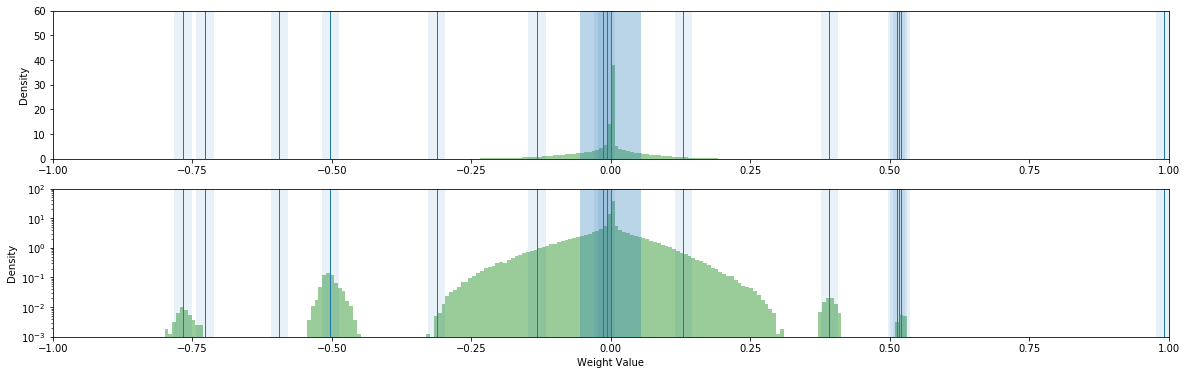

Original: 98.26% - Retrain: 98.30% - Prune: 97.75% - Quantize: 98.08% - Sparsity: 62.57%
Epoch: 50. Loss: -5747.83


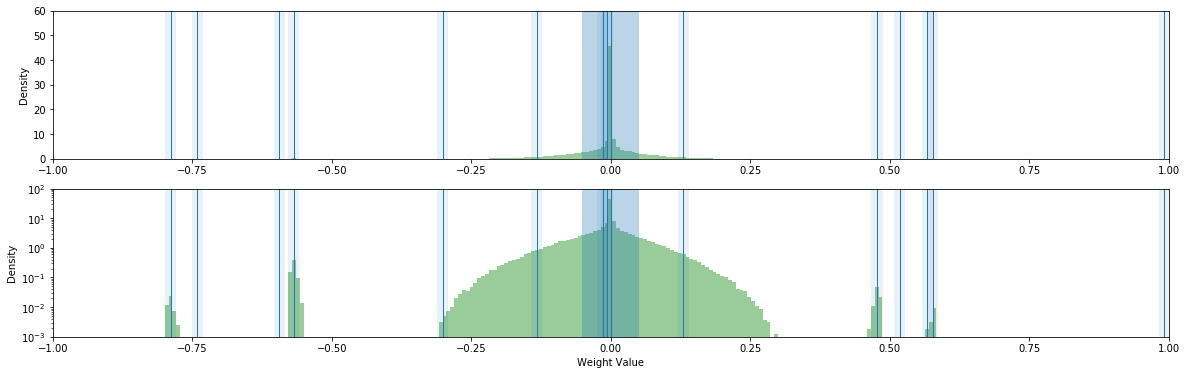

Original: 98.26% - Retrain: 98.30% - Prune: 97.66% - Quantize: 97.98% - Sparsity: 64.69%
Original: 98.15% - Retrain: 98.23% - Prune: 97.70% - Quantize: 98.03% - Sparsity: 64.69%
Original: 98.26% - Retrain: 98.30% - Prune: 97.66% - Quantize: 97.98% - Sparsity: 64.69%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5.49


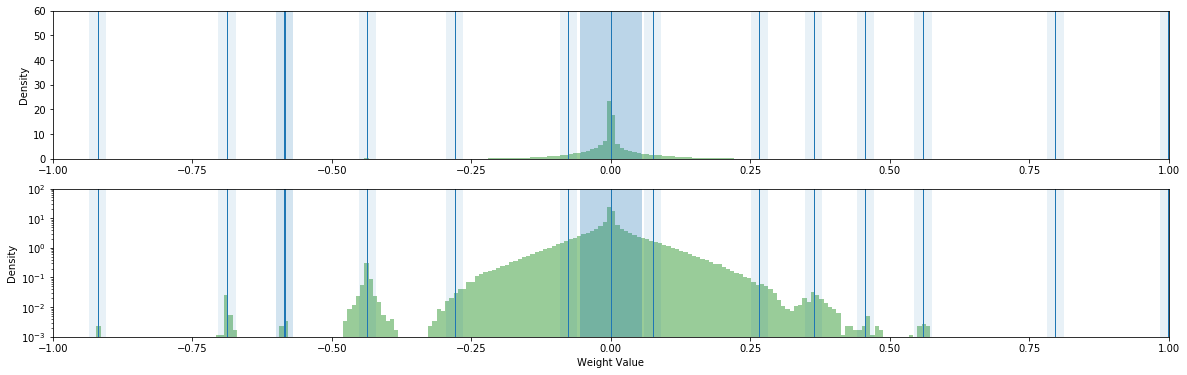

Original: 98.26% - Retrain: 98.12% - Prune: 98.11% - Quantize: 98.00% - Sparsity: 60.41%
Epoch: 50. Loss: -5.60


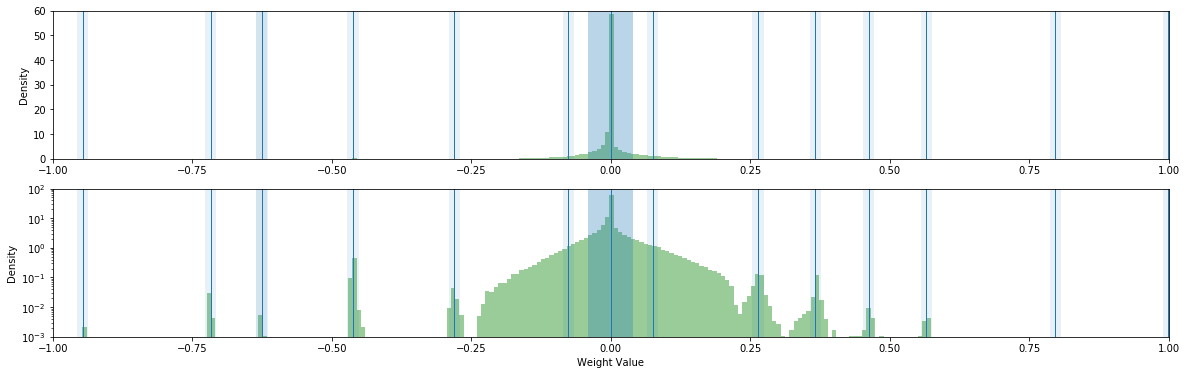

Original: 98.26% - Retrain: 97.86% - Prune: 97.83% - Quantize: 97.57% - Sparsity: 75.59%
Original: 98.15% - Retrain: 97.79% - Prune: 97.69% - Quantize: 97.54% - Sparsity: 75.59%
Original: 98.26% - Retrain: 97.86% - Prune: 97.83% - Quantize: 97.57% - Sparsity: 75.59%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5626.53


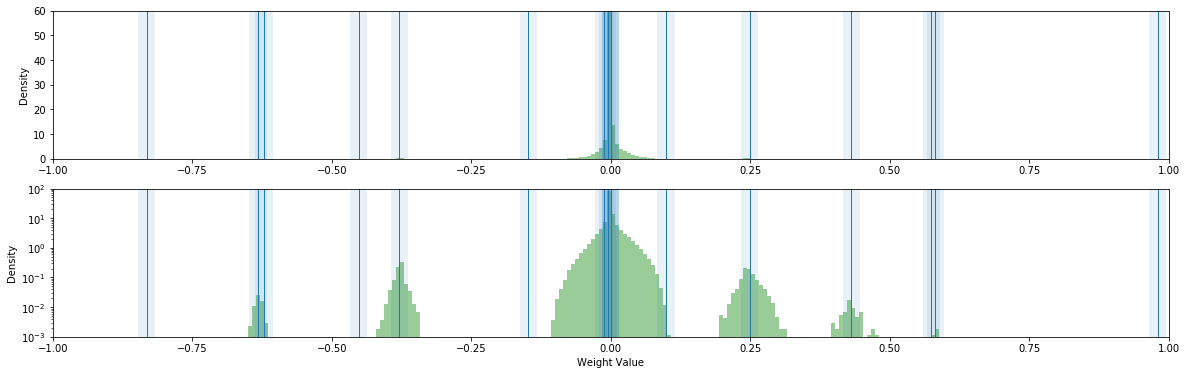

Original: 98.26% - Retrain: 97.10% - Prune: 95.23% - Quantize: 90.47% - Sparsity: 91.89%
Epoch: 50. Loss: -5829.63


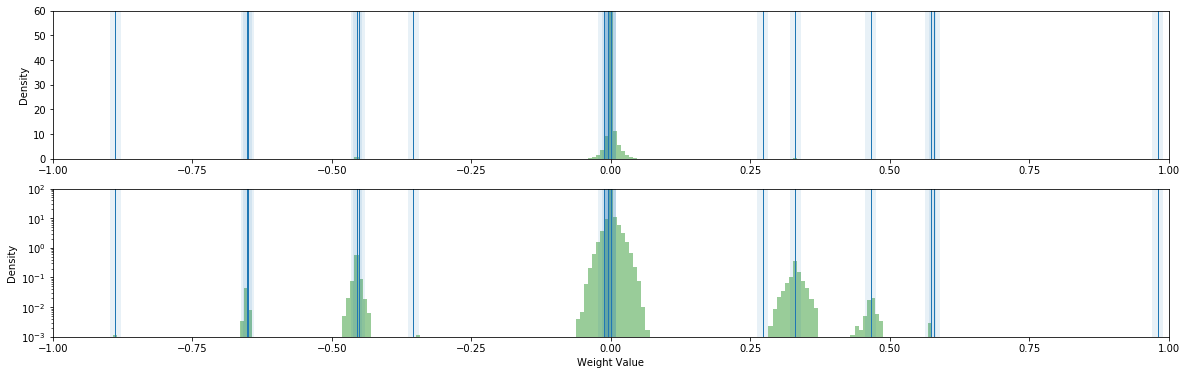

Original: 98.26% - Retrain: 95.74% - Prune: 79.10% - Quantize: 71.08% - Sparsity: 97.87%
Original: 98.15% - Retrain: 95.83% - Prune: 78.84% - Quantize: 70.44% - Sparsity: 97.87%
Original: 98.26% - Retrain: 95.74% - Prune: 79.10% - Quantize: 71.08% - Sparsity: 97.87%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5625.90


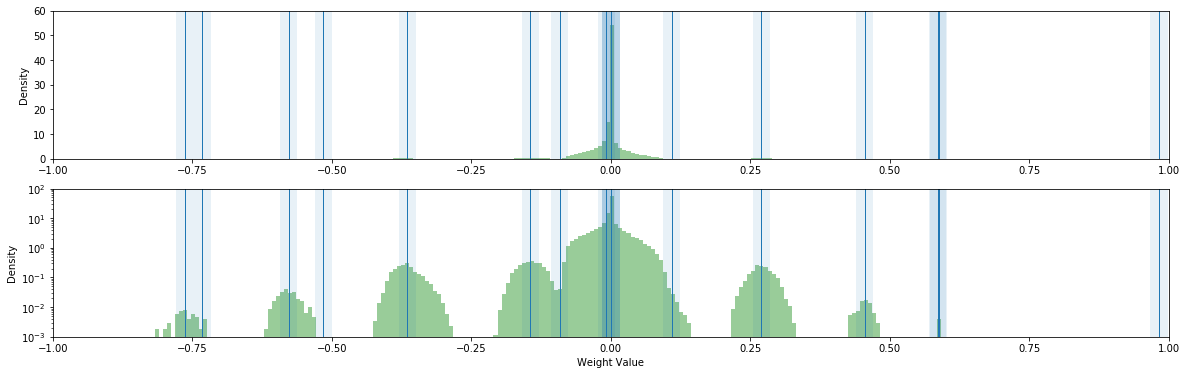

Original: 98.26% - Retrain: 98.16% - Prune: 97.04% - Quantize: 97.71% - Sparsity: 76.65%
Epoch: 50. Loss: -5829.22


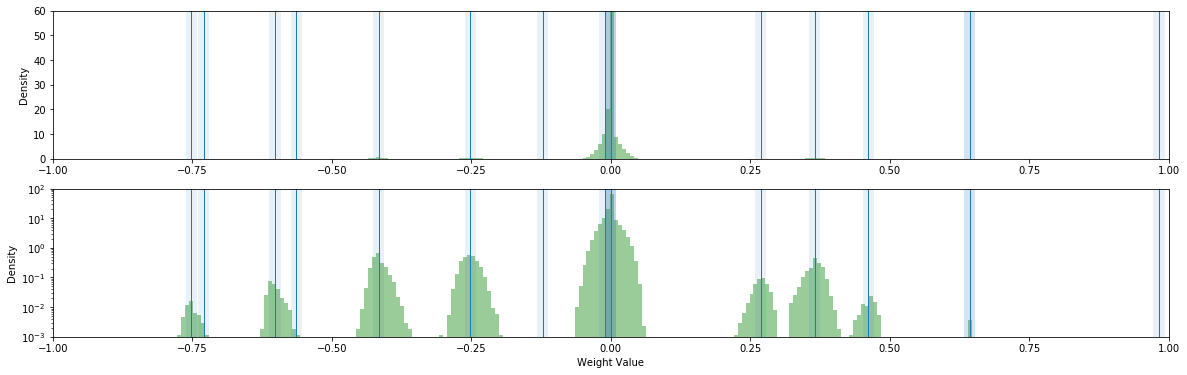

Original: 98.26% - Retrain: 97.76% - Prune: 96.00% - Quantize: 95.19% - Sparsity: 91.18%
Original: 98.15% - Retrain: 97.87% - Prune: 96.05% - Quantize: 95.19% - Sparsity: 91.18%
Original: 98.26% - Retrain: 97.76% - Prune: 96.00% - Quantize: 95.19% - Sparsity: 91.18%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -5.60


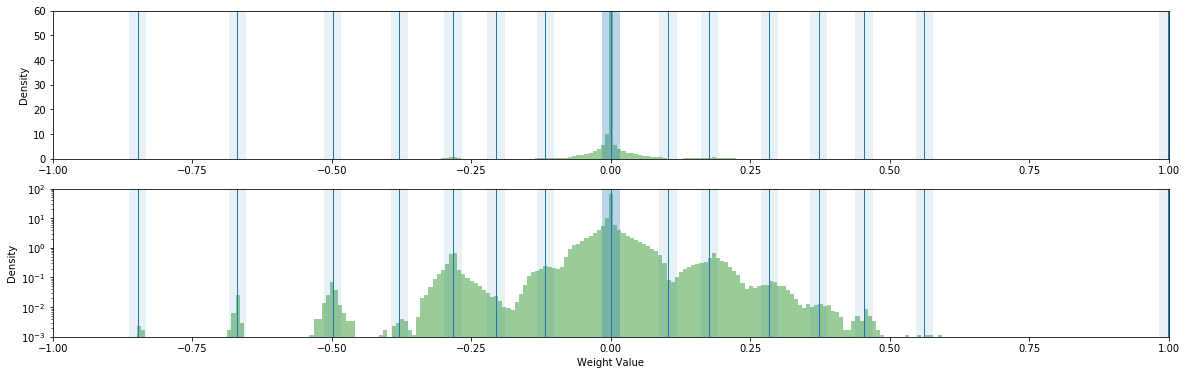

Original: 98.26% - Retrain: 97.89% - Prune: 97.11% - Quantize: 96.95% - Sparsity: 85.45%
Epoch: 50. Loss: -5.82


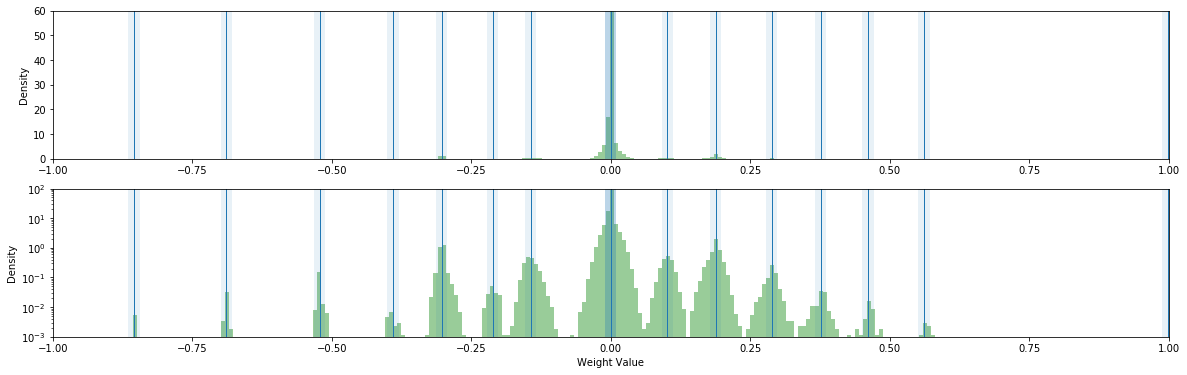

Original: 98.26% - Retrain: 97.53% - Prune: 96.61% - Quantize: 96.34% - Sparsity: 91.06%
Original: 98.15% - Retrain: 97.48% - Prune: 96.76% - Quantize: 96.55% - Sparsity: 91.06%
Original: 98.26% - Retrain: 97.53% - Prune: 96.61% - Quantize: 96.34% - Sparsity: 91.06%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -14145.81


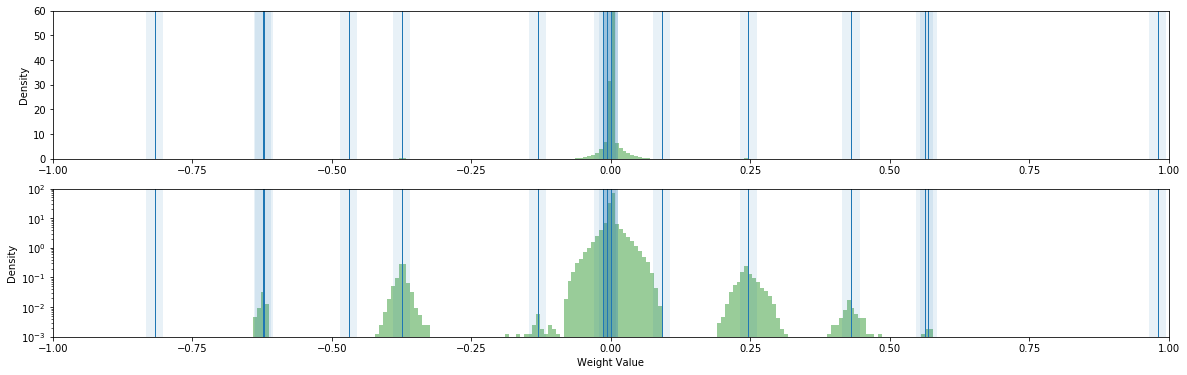

Original: 98.26% - Retrain: 96.79% - Prune: 94.76% - Quantize: 90.93% - Sparsity: 93.19%
Epoch: 50. Loss: -16260.55


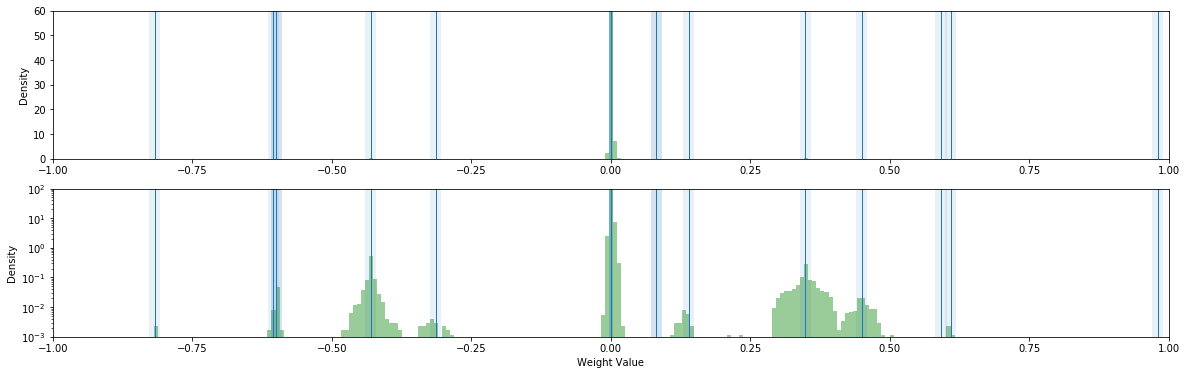

Original: 98.26% - Retrain: 91.37% - Prune: 78.63% - Quantize: 76.65% - Sparsity: 98.57%
Original: 98.15% - Retrain: 91.37% - Prune: 78.36% - Quantize: 76.24% - Sparsity: 98.57%
Original: 98.26% - Retrain: 91.37% - Prune: 78.63% - Quantize: 76.65% - Sparsity: 98.57%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -14145.10


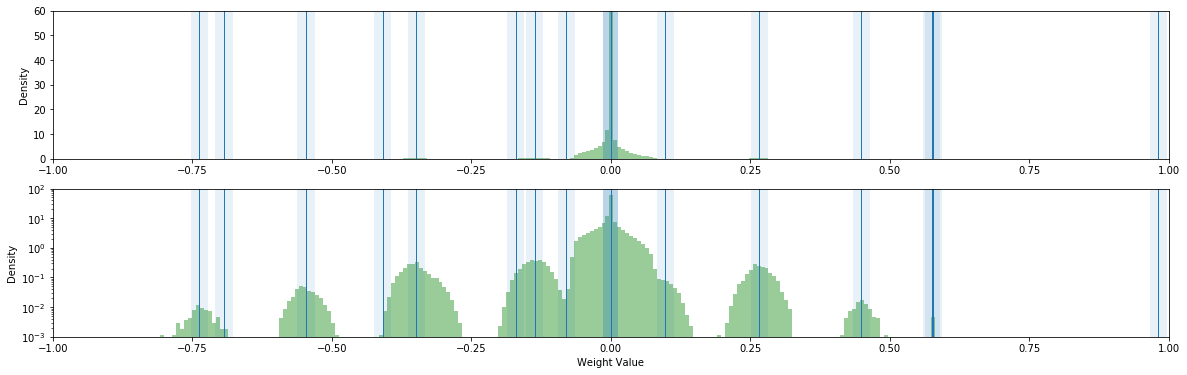

Original: 98.26% - Retrain: 98.06% - Prune: 97.21% - Quantize: 97.68% - Sparsity: 84.27%
Epoch: 50. Loss: -16260.25


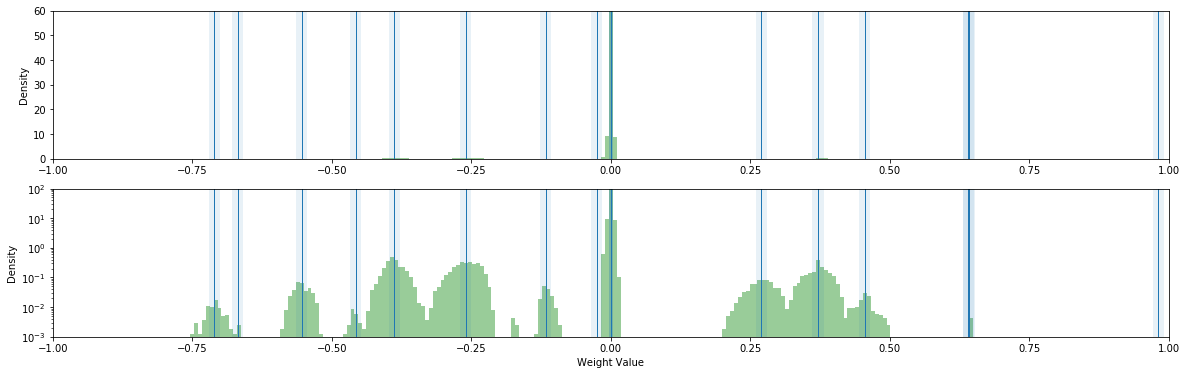

Original: 98.26% - Retrain: 97.46% - Prune: 96.97% - Quantize: 96.34% - Sparsity: 93.98%
Original: 98.15% - Retrain: 97.46% - Prune: 97.05% - Quantize: 96.57% - Sparsity: 93.98%
Original: 98.26% - Retrain: 97.46% - Prune: 96.97% - Quantize: 96.34% - Sparsity: 93.98%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 25. Loss: -14.10


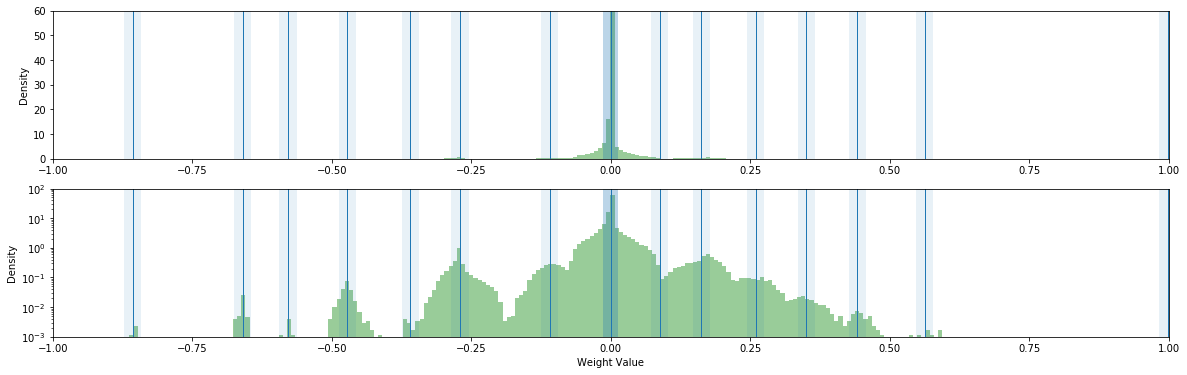

Original: 98.26% - Retrain: 97.87% - Prune: 96.87% - Quantize: 96.82% - Sparsity: 85.21%
Epoch: 50. Loss: -16.13


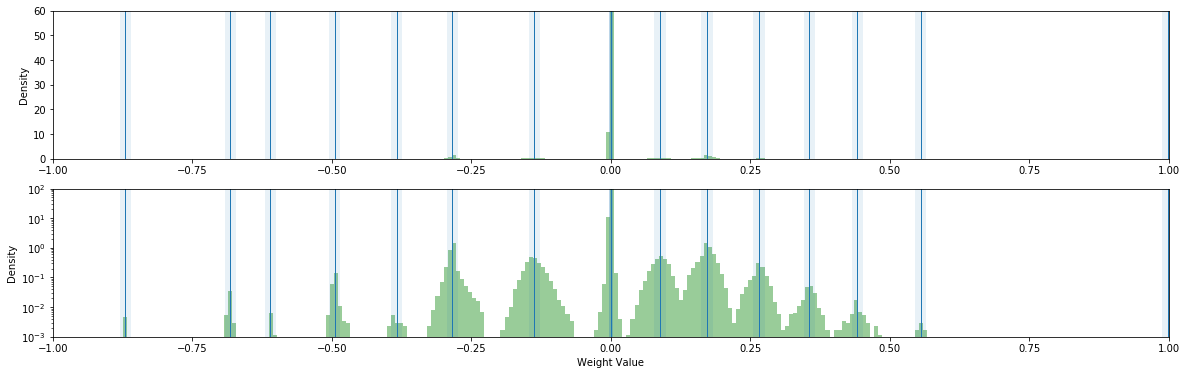

Original: 98.26% - Retrain: 97.23% - Prune: 97.06% - Quantize: 96.78% - Sparsity: 89.59%
Original: 98.15% - Retrain: 97.40% - Prune: 97.25% - Quantize: 97.02% - Sparsity: 89.59%
Original: 98.26% - Retrain: 97.23% - Prune: 97.06% - Quantize: 96.78% - Sparsity: 89.59%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601901.88


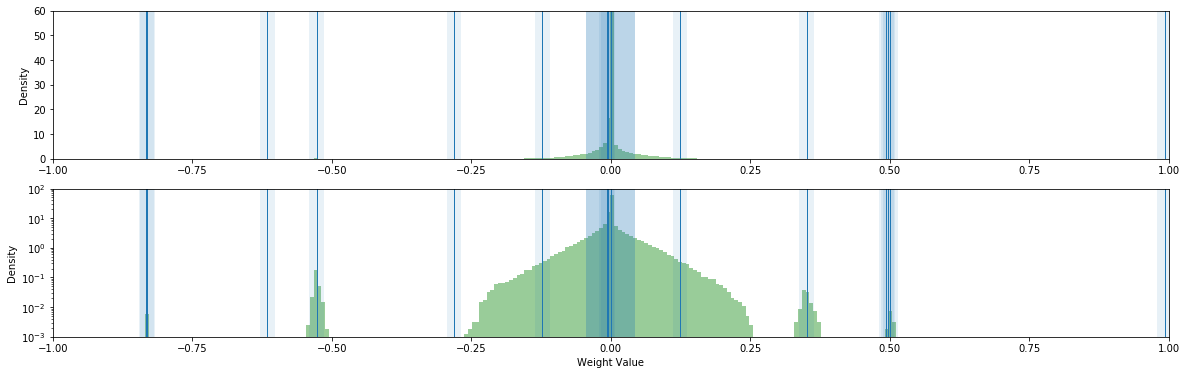

Original: 98.26% - Retrain: 98.11% - Prune: 97.54% - Quantize: 97.29% - Sparsity: 78.74%
Epoch: 50. Loss: -735904.19


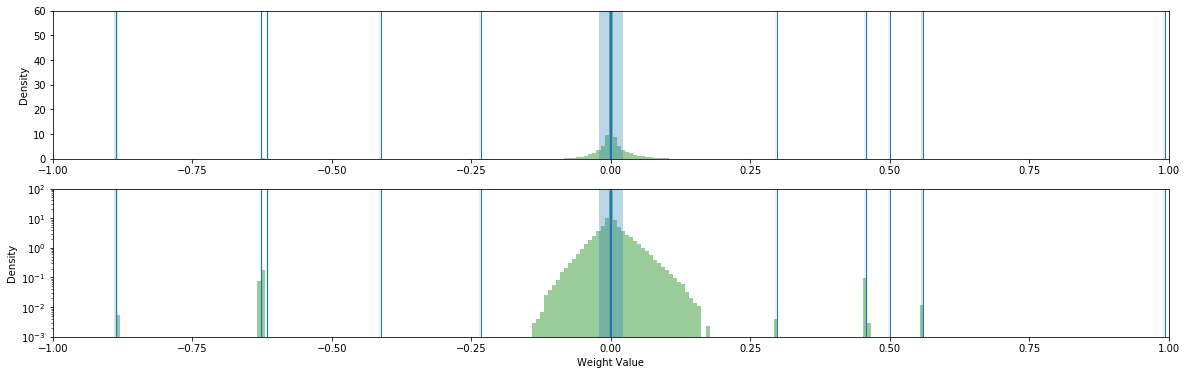

Original: 98.26% - Retrain: 96.70% - Prune: 18.00% - Quantize: 32.18% - Sparsity: 93.36%
Original: 98.15% - Retrain: 96.68% - Prune: 18.05% - Quantize: 31.89% - Sparsity: 93.36%
Original: 98.26% - Retrain: 96.70% - Prune: 18.00% - Quantize: 32.18% - Sparsity: 93.36%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601901.81


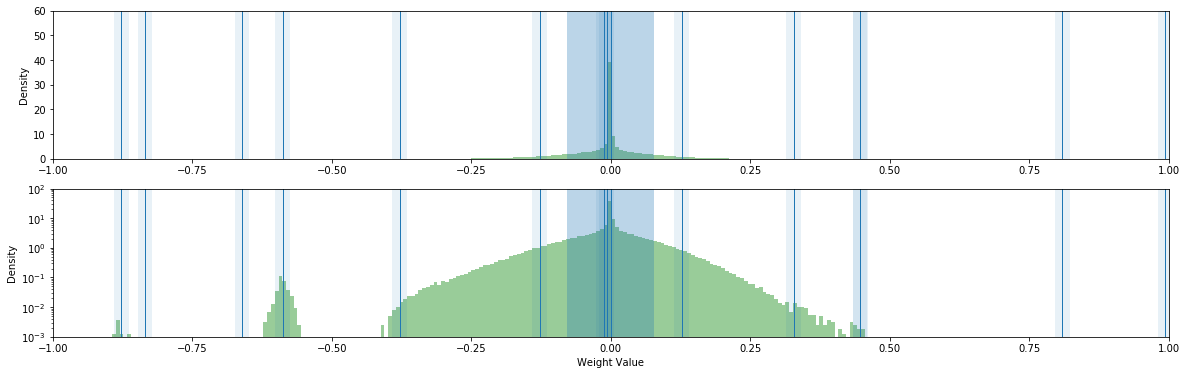

Original: 98.26% - Retrain: 98.28% - Prune: 97.92% - Quantize: 98.10% - Sparsity: 59.00%
Epoch: 50. Loss: -735904.00


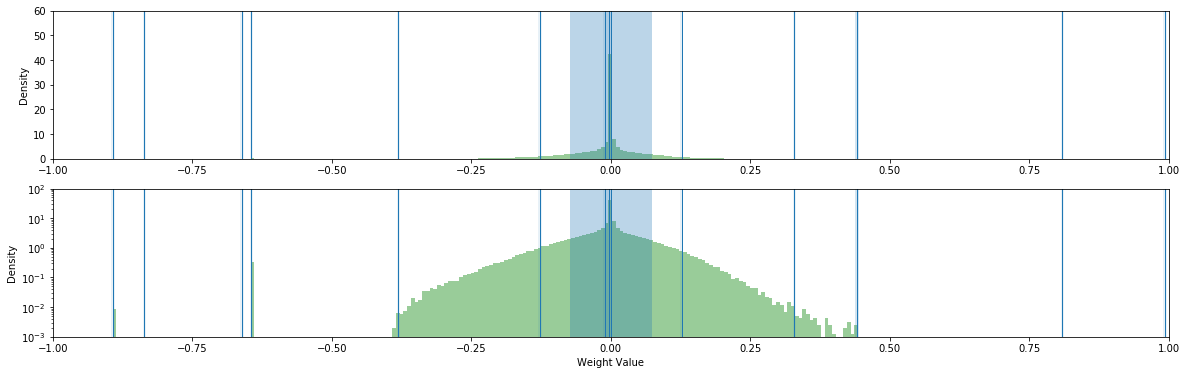

Original: 98.26% - Retrain: 98.28% - Prune: 97.86% - Quantize: 98.13% - Sparsity: 60.75%
Original: 98.15% - Retrain: 98.27% - Prune: 97.89% - Quantize: 98.09% - Sparsity: 60.75%
Original: 98.26% - Retrain: 98.28% - Prune: 97.86% - Quantize: 98.13% - Sparsity: 60.75%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601.63


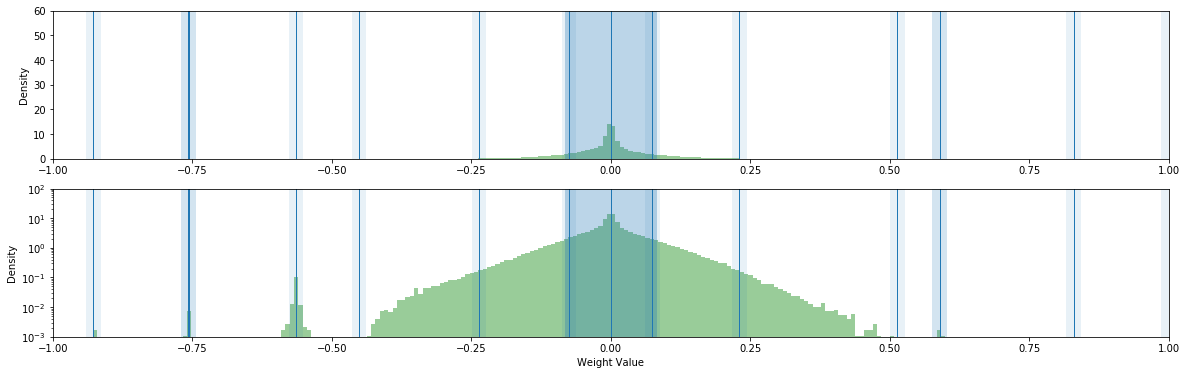

Original: 98.26% - Retrain: 98.17% - Prune: 98.11% - Quantize: 98.11% - Sparsity: 53.16%
Epoch: 50. Loss: -735.84


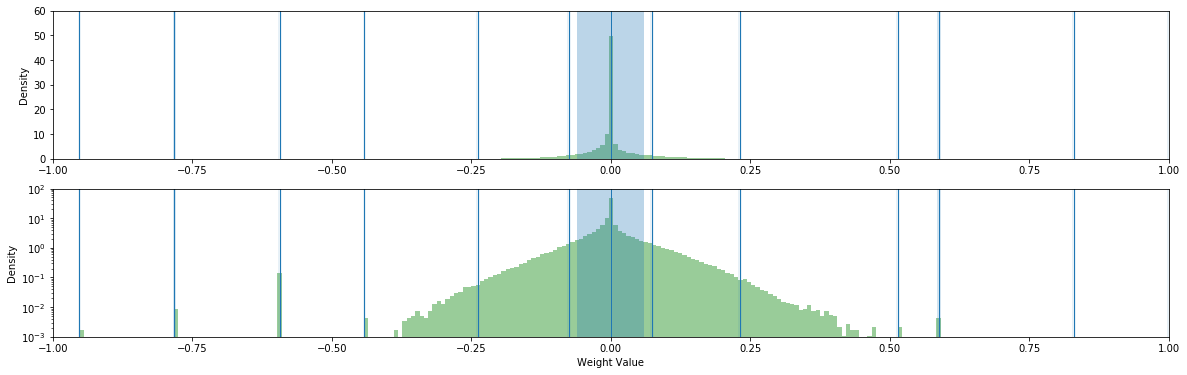

Original: 98.26% - Retrain: 98.02% - Prune: 97.97% - Quantize: 97.92% - Sparsity: 69.67%
Original: 98.15% - Retrain: 97.86% - Prune: 97.87% - Quantize: 97.91% - Sparsity: 69.67%
Original: 98.26% - Retrain: 98.02% - Prune: 97.97% - Quantize: 97.92% - Sparsity: 69.67%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601901.88


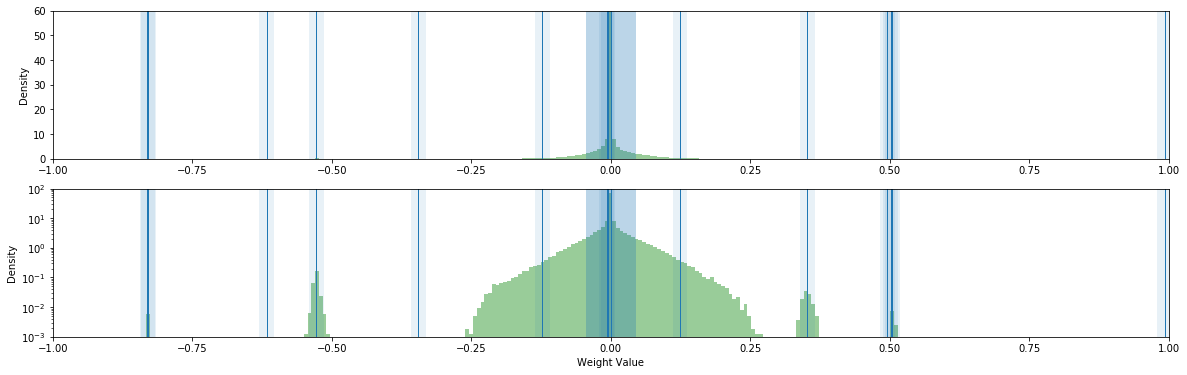

Original: 98.26% - Retrain: 98.12% - Prune: 97.52% - Quantize: 97.29% - Sparsity: 78.49%
Epoch: 50. Loss: -735904.19


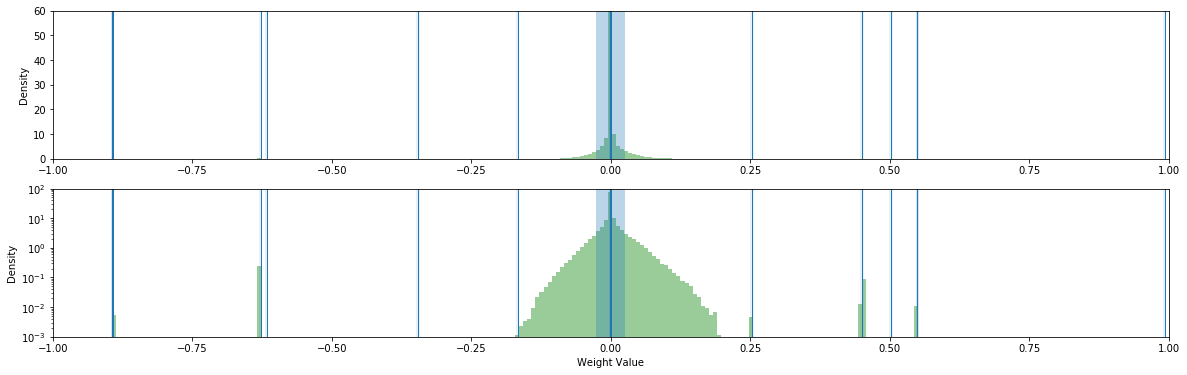

Original: 98.26% - Retrain: 97.02% - Prune: 30.83% - Quantize: 44.02% - Sparsity: 91.83%
Original: 98.15% - Retrain: 96.93% - Prune: 30.48% - Quantize: 44.76% - Sparsity: 91.83%
Original: 98.26% - Retrain: 97.02% - Prune: 30.83% - Quantize: 44.02% - Sparsity: 91.83%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601901.81


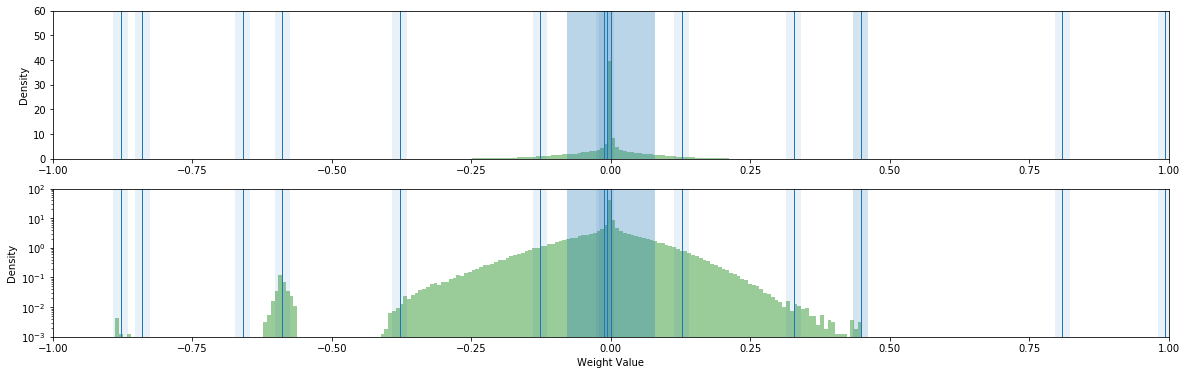

Original: 98.26% - Retrain: 98.29% - Prune: 97.93% - Quantize: 98.05% - Sparsity: 58.94%
Epoch: 50. Loss: -735904.00


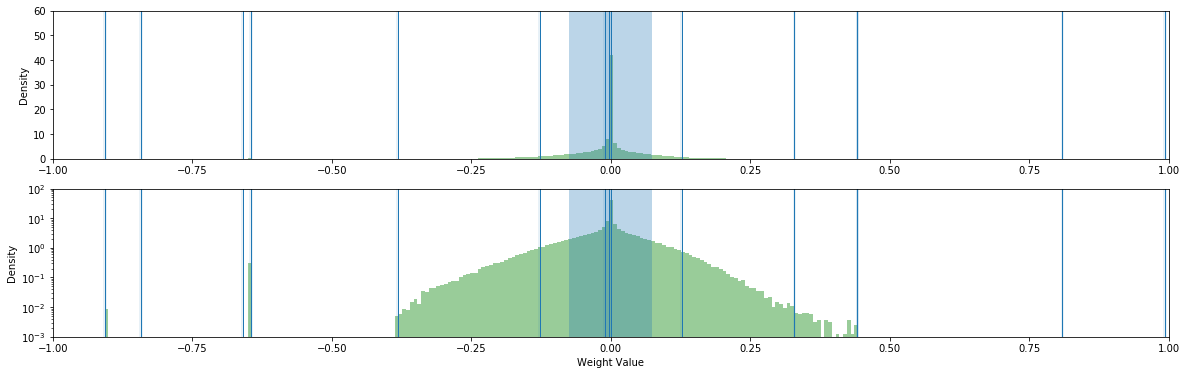

Original: 98.26% - Retrain: 98.31% - Prune: 97.90% - Quantize: 98.11% - Sparsity: 60.74%
Original: 98.15% - Retrain: 98.25% - Prune: 97.91% - Quantize: 98.06% - Sparsity: 60.74%
Original: 98.26% - Retrain: 98.31% - Prune: 97.90% - Quantize: 98.11% - Sparsity: 60.74%
0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601.67


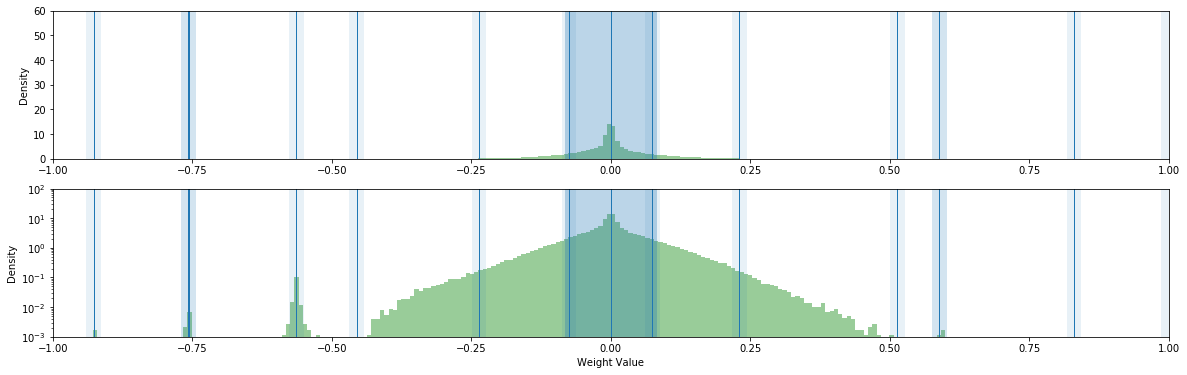

Original: 98.26% - Retrain: 98.18% - Prune: 98.12% - Quantize: 98.11% - Sparsity: 53.17%
Epoch: 50. Loss: -735.64


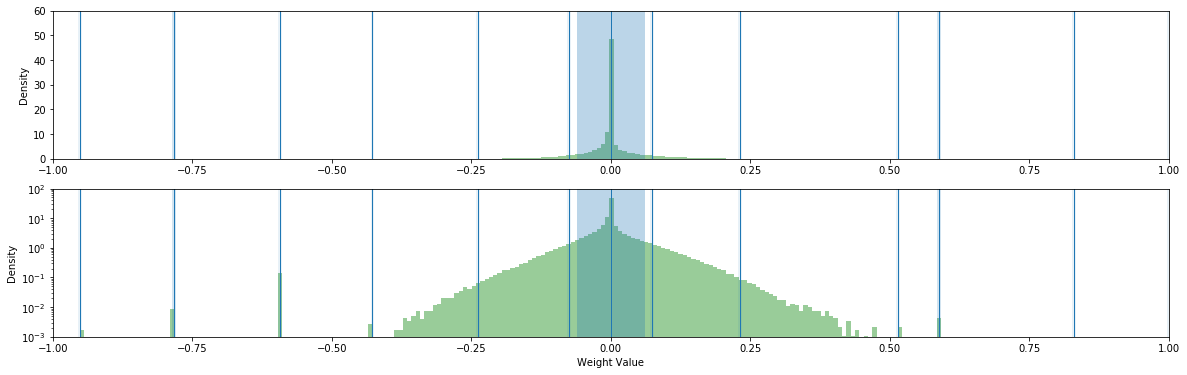

Original: 98.26% - Retrain: 97.99% - Prune: 97.97% - Quantize: 97.93% - Sparsity: 69.62%
Original: 98.15% - Retrain: 97.88% - Prune: 97.86% - Quantize: 97.94% - Sparsity: 69.62%
Original: 98.26% - Retrain: 97.99% - Prune: 97.97% - Quantize: 97.93% - Sparsity: 69.62%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601902.50


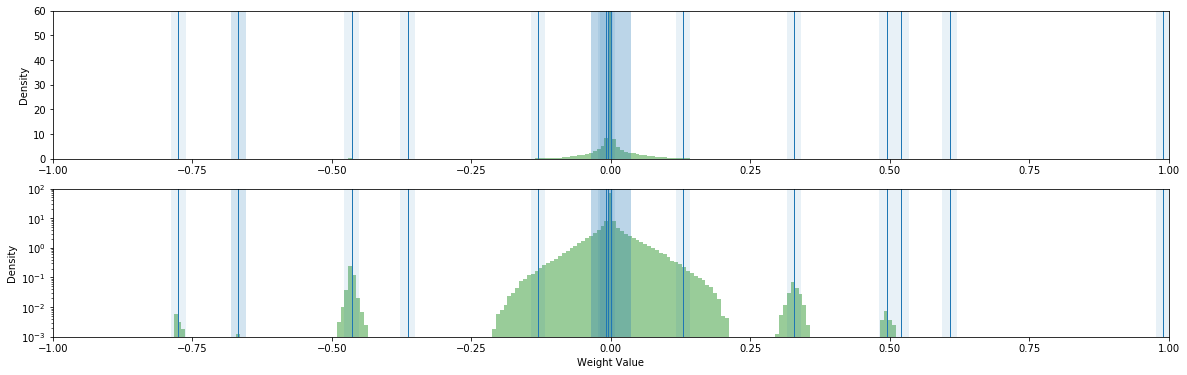

Original: 98.26% - Retrain: 97.82% - Prune: 96.88% - Quantize: 96.99% - Sparsity: 82.52%
Epoch: 50. Loss: -735904.88


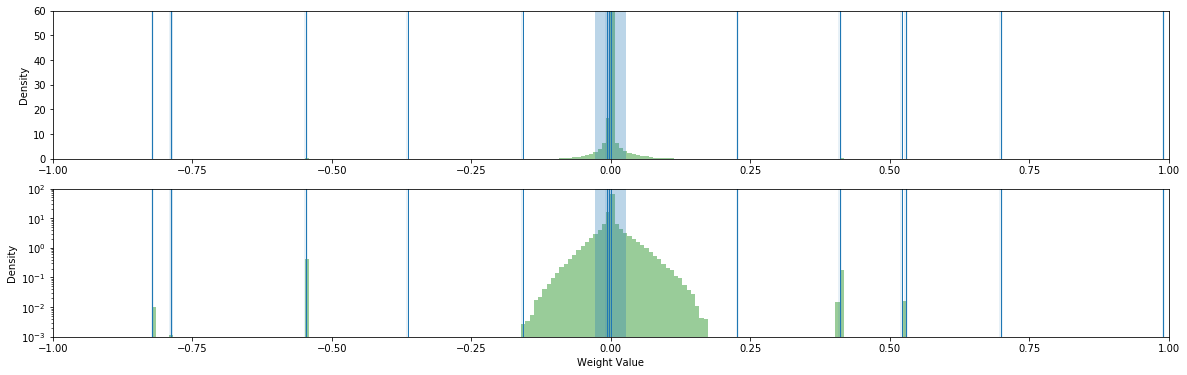

Original: 98.26% - Retrain: 97.26% - Prune: 44.67% - Quantize: 58.19% - Sparsity: 91.53%
Original: 98.15% - Retrain: 97.19% - Prune: 45.27% - Quantize: 58.49% - Sparsity: 91.53%
Original: 98.26% - Retrain: 97.26% - Prune: 44.67% - Quantize: 58.19% - Sparsity: 91.53%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601902.31


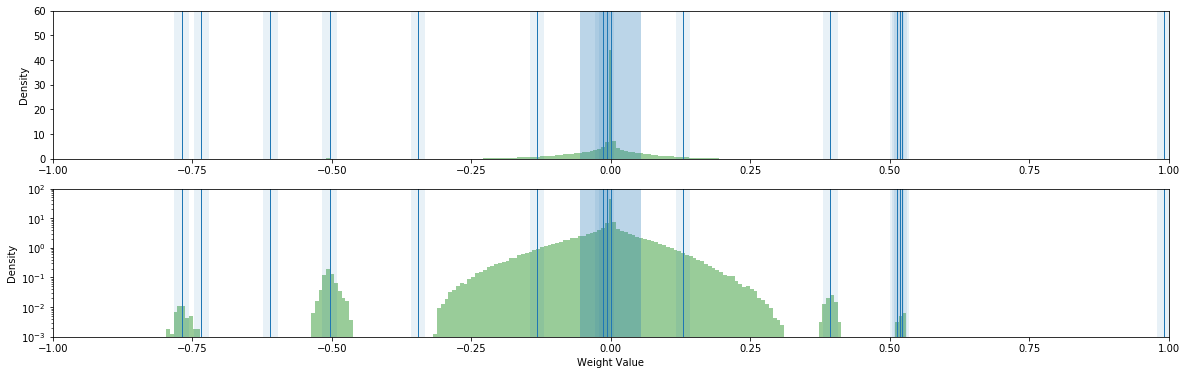

Original: 98.26% - Retrain: 98.30% - Prune: 97.66% - Quantize: 98.07% - Sparsity: 62.56%
Epoch: 50. Loss: -735904.62


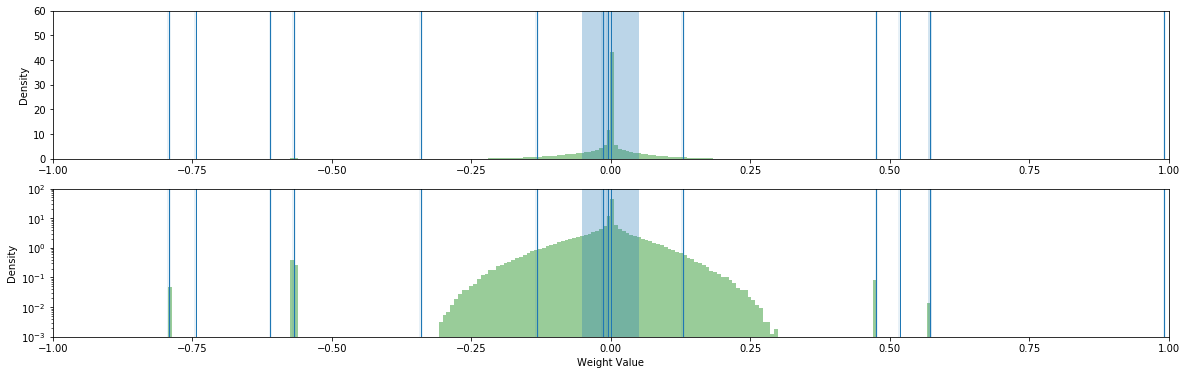

Original: 98.26% - Retrain: 98.33% - Prune: 97.68% - Quantize: 98.00% - Sparsity: 64.66%
Original: 98.15% - Retrain: 98.23% - Prune: 97.78% - Quantize: 98.02% - Sparsity: 64.66%
Original: 98.26% - Retrain: 98.33% - Prune: 97.68% - Quantize: 98.00% - Sparsity: 64.66%
0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601.72


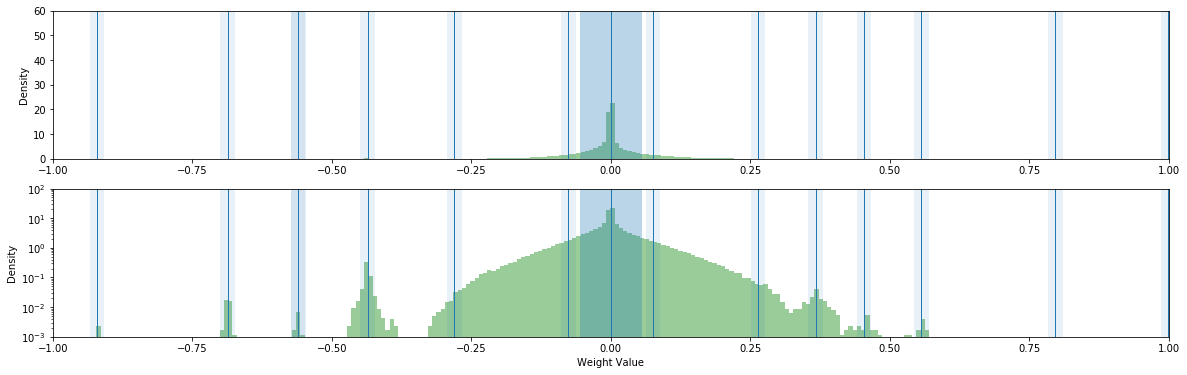

Original: 98.26% - Retrain: 98.12% - Prune: 98.08% - Quantize: 97.96% - Sparsity: 60.40%
Epoch: 50. Loss: -735.90


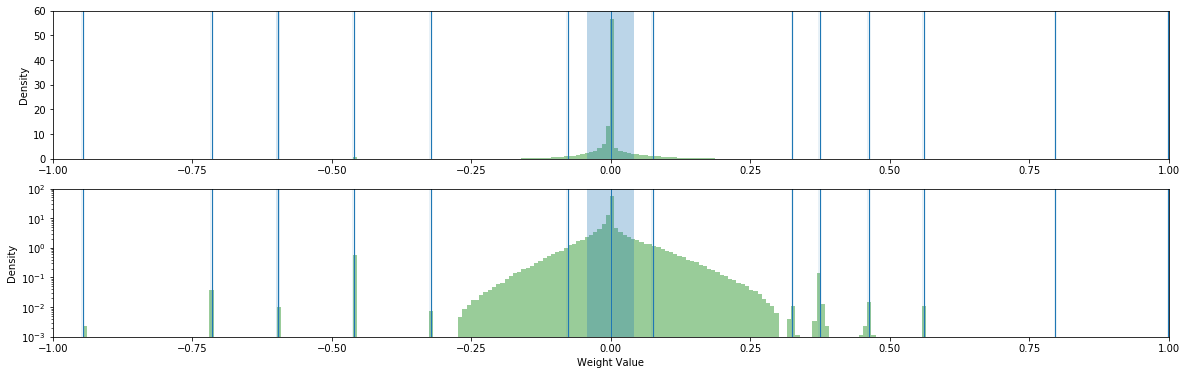

Original: 98.26% - Retrain: 97.91% - Prune: 97.85% - Quantize: 97.53% - Sparsity: 75.28%
Original: 98.15% - Retrain: 97.78% - Prune: 97.75% - Quantize: 97.33% - Sparsity: 75.28%
Original: 98.26% - Retrain: 97.91% - Prune: 97.85% - Quantize: 97.53% - Sparsity: 75.28%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601981.19


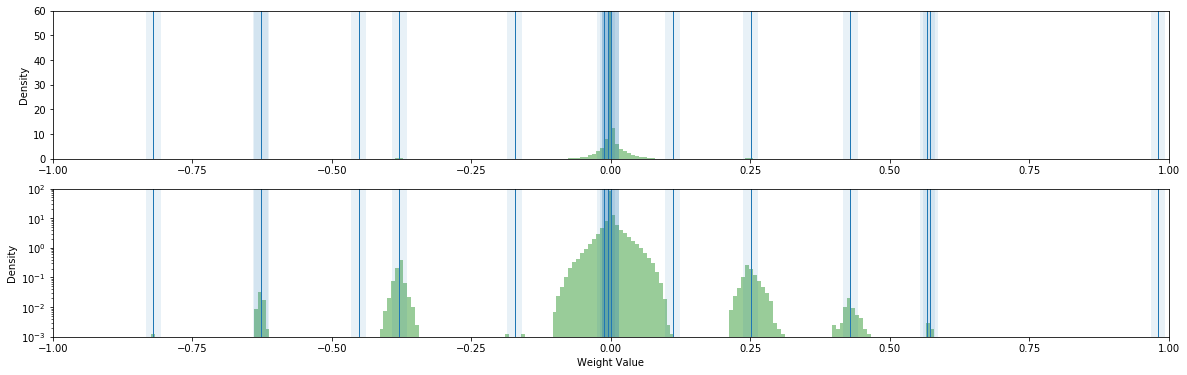

Original: 98.26% - Retrain: 97.05% - Prune: 93.50% - Quantize: 88.60% - Sparsity: 92.52%
Epoch: 50. Loss: -735986.38


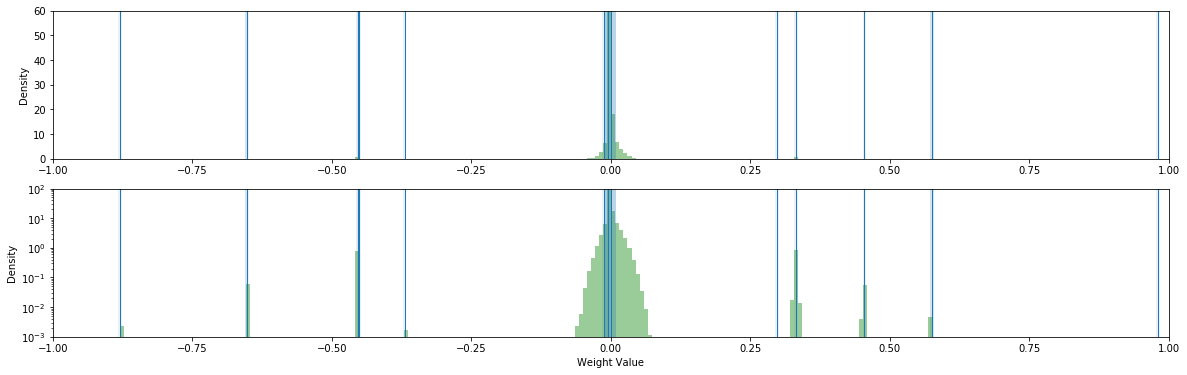

Original: 98.26% - Retrain: 95.75% - Prune: 77.89% - Quantize: 68.61% - Sparsity: 97.86%
Original: 98.15% - Retrain: 95.73% - Prune: 77.58% - Quantize: 68.98% - Sparsity: 97.86%
Original: 98.26% - Retrain: 95.75% - Prune: 77.89% - Quantize: 68.61% - Sparsity: 97.86%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601980.56


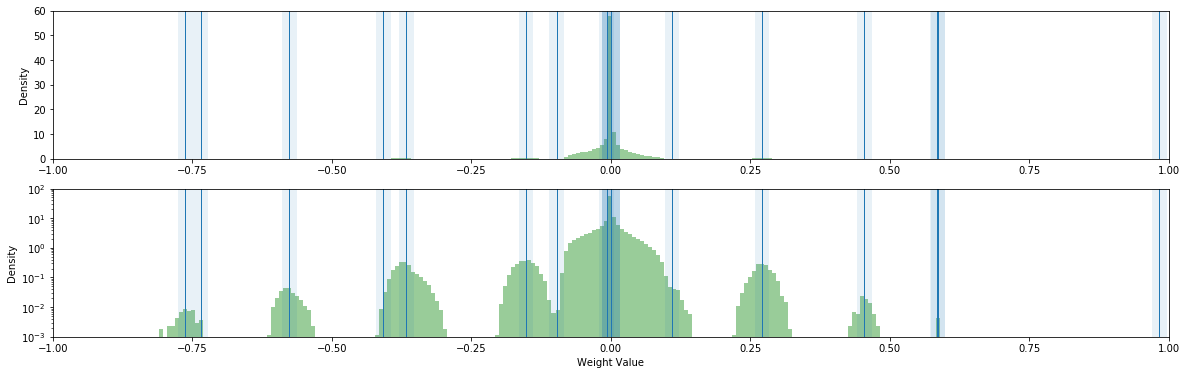

Original: 98.26% - Retrain: 98.16% - Prune: 97.02% - Quantize: 97.74% - Sparsity: 76.61%
Epoch: 50. Loss: -735986.06


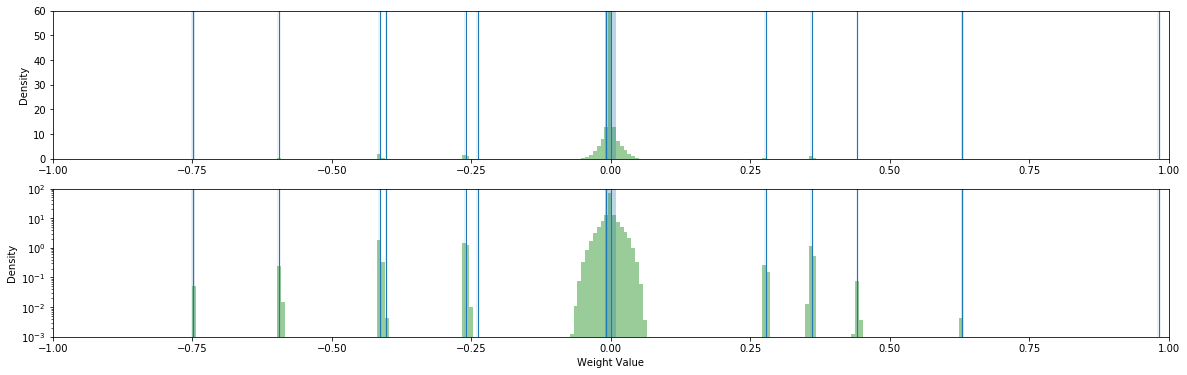

Original: 98.26% - Retrain: 97.76% - Prune: 95.81% - Quantize: 94.76% - Sparsity: 90.41%
Original: 98.15% - Retrain: 97.84% - Prune: 95.74% - Quantize: 94.96% - Sparsity: 90.41%
Original: 98.26% - Retrain: 97.76% - Prune: 95.81% - Quantize: 94.76% - Sparsity: 90.41%
0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -601.88


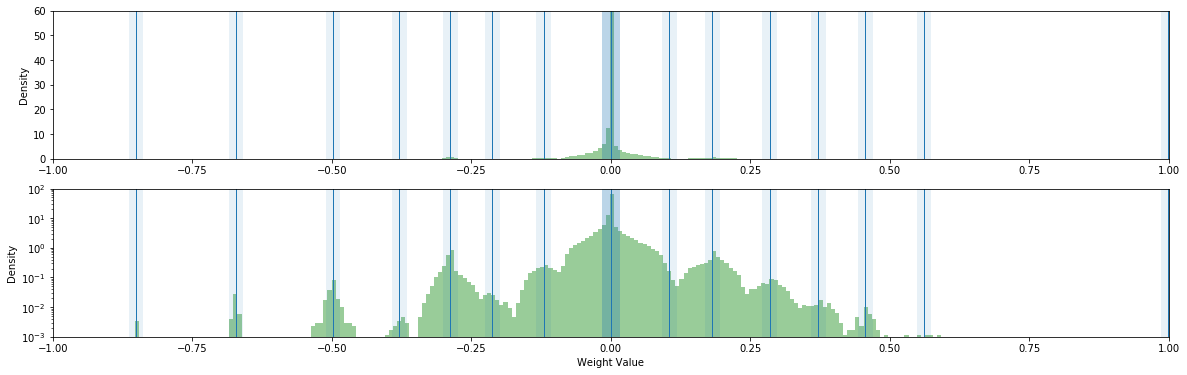

Original: 98.26% - Retrain: 97.93% - Prune: 97.05% - Quantize: 96.85% - Sparsity: 85.87%
Epoch: 50. Loss: -735.99


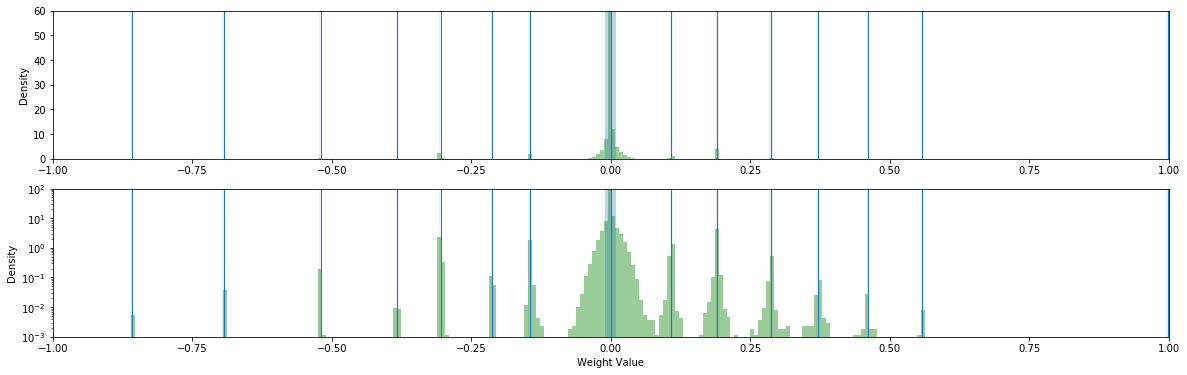

Original: 98.26% - Retrain: 97.44% - Prune: 96.48% - Quantize: 96.41% - Sparsity: 91.35%
Original: 98.15% - Retrain: 97.54% - Prune: 96.50% - Quantize: 96.47% - Sparsity: 91.35%
Original: 98.26% - Retrain: 97.44% - Prune: 96.48% - Quantize: 96.41% - Sparsity: 91.35%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -610500.50


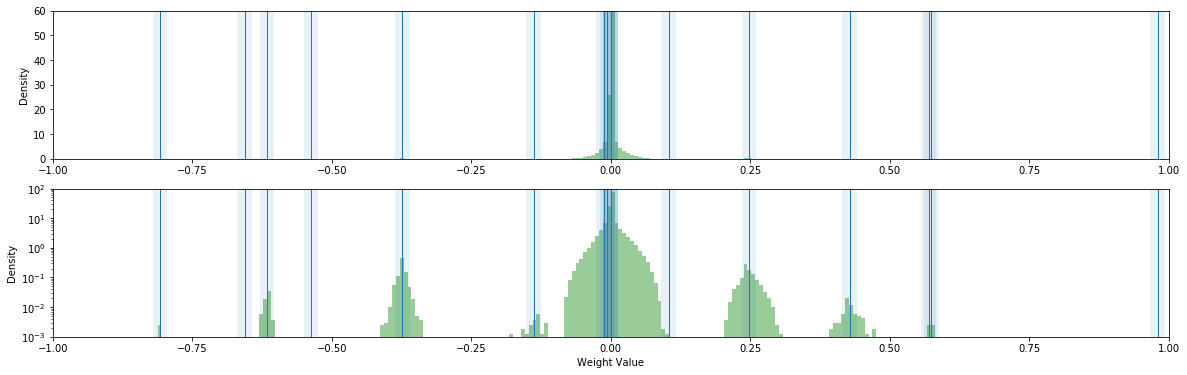

Original: 98.26% - Retrain: 96.75% - Prune: 93.14% - Quantize: 89.99% - Sparsity: 93.80%
Epoch: 50. Loss: -746417.38


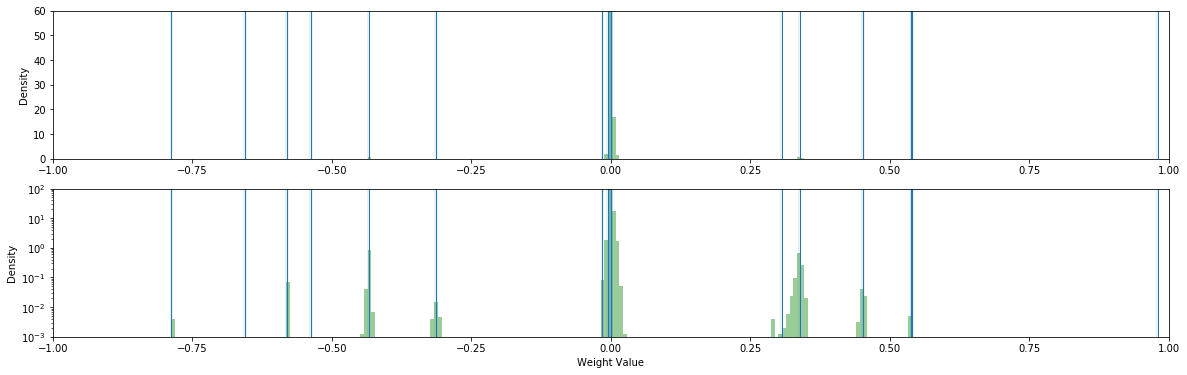

Original: 98.26% - Retrain: 90.40% - Prune: 75.16% - Quantize: 74.72% - Sparsity: 98.58%
Original: 98.15% - Retrain: 90.61% - Prune: 74.57% - Quantize: 74.08% - Sparsity: 98.58%
Original: 98.26% - Retrain: 90.40% - Prune: 75.16% - Quantize: 74.72% - Sparsity: 98.58%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -610499.56


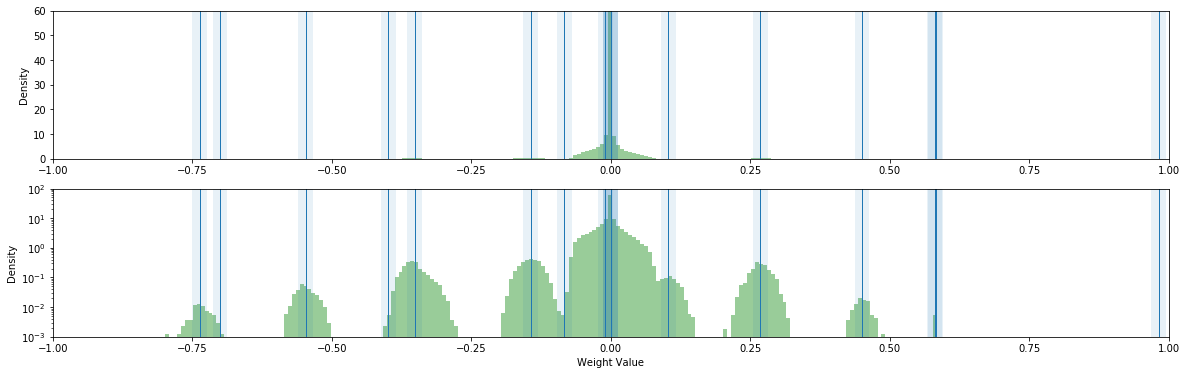

Original: 98.26% - Retrain: 98.08% - Prune: 96.91% - Quantize: 97.40% - Sparsity: 78.97%
Epoch: 50. Loss: -746416.81


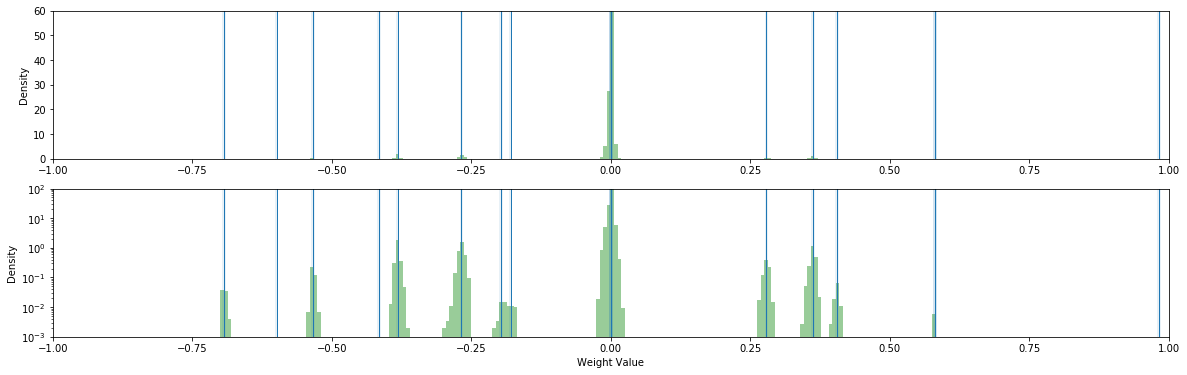

Original: 98.26% - Retrain: 97.26% - Prune: 96.13% - Quantize: 95.90% - Sparsity: 94.15%
Original: 98.15% - Retrain: 97.32% - Prune: 96.40% - Quantize: 96.15% - Sparsity: 94.15%
Original: 98.26% - Retrain: 97.26% - Prune: 96.13% - Quantize: 95.90% - Sparsity: 94.15%
0-component Mean: 100000.0 Variance: 10.0
Non-zero component Mean: 100000.0 Variance: 2.0
Epoch: 25. Loss: -610.42


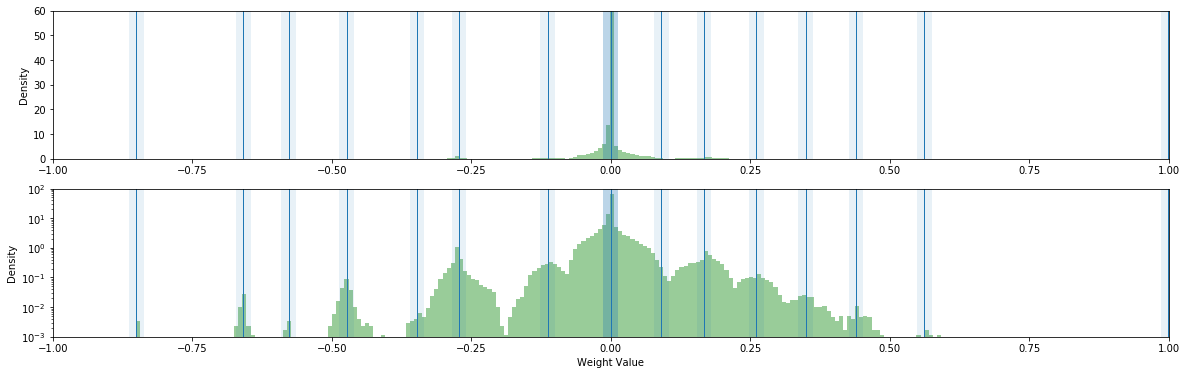

Original: 98.26% - Retrain: 97.92% - Prune: 96.94% - Quantize: 96.73% - Sparsity: 85.68%
Epoch: 50. Loss: -746.41


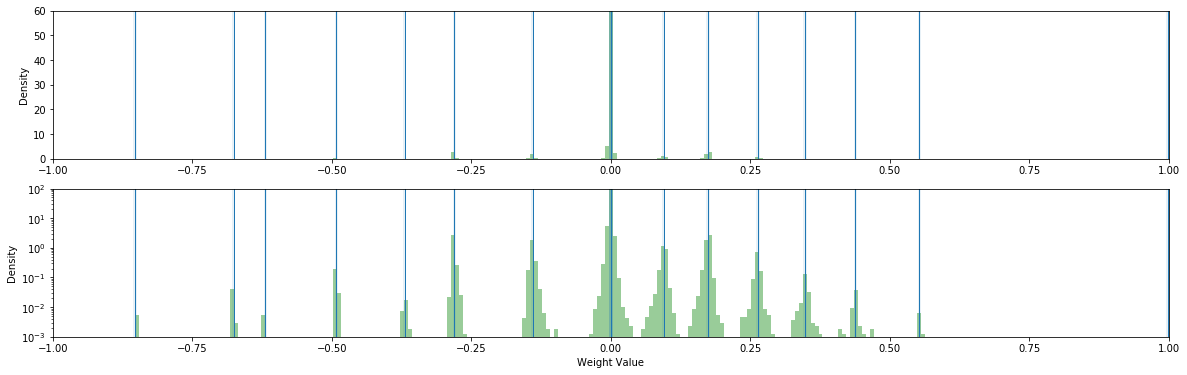

Original: 98.26% - Retrain: 97.18% - Prune: 96.74% - Quantize: 96.57% - Sparsity: 89.92%
Original: 98.15% - Retrain: 97.20% - Prune: 96.97% - Quantize: 96.89% - Sparsity: 89.92%
Original: 98.26% - Retrain: 97.18% - Prune: 96.74% - Quantize: 96.57% - Sparsity: 89.92%
Mean: 10.00 ZMean: 10.00
MSEHA - Retrain Test: 95.18, Retrain Validation: 95.41, Prune Test: 89.01, Prune Validation: 88.81, Prune Sparsity: 98.70
MSEHNA - Retrain Test: 98.25, Retrain Validation: 98.30, Prune Test: 98.11, Prune Validation: 97.96, Prune Sparsity: 64.07
CESH - Retrain Test: 97.91, Retrain Validation: 98.02, Prune Test: 97.57, Prune Validation: 97.40, Prune Sparsity: 77.26
Mean: 10.00 ZMean: 100.00
MSEHA - Retrain Test: 96.81, Retrain Validation: 96.98, Prune Test: 95.60, Prune Validation: 95.42, Prune Sparsity: 95.73
MSEHNA - Retrain Test: 98.25, Retrain Validation: 98.31, Prune Test: 98.12, Prune Validation: 97.89, Prune Sparsity: 64.02
CESH - Retrain Test: 97.92, Retrain Validation: 98.01, Prune Test: 97.5

In [5]:
mixtures = 15
temp = 4
var = 2
zvar = 10

out_str = ""
for mean in [10, 100, 1000, 10000, 100000]:
    for zmean in [10, 100, 1000, 10000, 100000]:
        
        title = "Mean: {:.2f} ZMean: {:.2f}\n".format(mean, zmean)
        out_str += title
        
        layer_model, gmp, res_sws = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-6, 1, 'MSEHA')
        sws_res = "MSEHA - Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
        
        layer_model, gmp, res_sws = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-6, 1, 'MSEHNA')
        sws_res = "MSEHNA - Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
        
        layer_model, gmp, res_sws = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-9, 1, 'CESH')
        sws_res = "CESH - Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
print(out_str)

In [22]:
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
full_model = torch.load(model_load_dir + model_file + ".m")
layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)

Original: 98.26% - Retrain: 97.24% - Prune: 95.52% - Quantize: 94.95% - Sparsity: 97.40%


(97.24, 95.52, 94.95, 97.40382165605097)

In [6]:
data_size = 'search'
model_name = 'LeNet_300_100'
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)

test_data_full = Variable(test_data(fetch = "data")).cuda()
test_labels_full = Variable(test_data(fetch = "labels")).cuda()

(x_start, x_end) = (40000, 50000)
images = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
targets = (get_targets(model_file, 0, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
targets = nn.ReLU()(targets)
targets = nn.Softmax(dim=1)(targets/temp)

forward = layer_model(test_data_full)
outputs = nn.LogSoftmax(dim=1)((nn.ReLU()(forward))/temp)
loss_soft_target = -torch.mean(torch.sum(targets * outputs, dim=1))

In [7]:
%%notify
res_str = []
res_str.append(layer_exp(50000, 2, 20000, 10000, 15, 4, 1e-8))
res_str.append(layer_exp(20000, 2, 80000, 10, 15, 5, 1e-8))
fin = "\n".join(res_str)
fin

0-component Mean: 20000.0 Variance: 10000.0
Non-zero component Mean: 50000.0 Variance: 2.0


KeyboardInterrupt: 

<IPython.core.display.Javascript object>